# Expore data

## Import & definitions

In [1]:
import os
import sys
from pathlib import Path
import re
import random
import time
import math
from datetime import timedelta
from datetime import timezone
from datetime import datetime
import json
import joblib
# Third Party
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
# from helpers.ocean_helpers import save_list
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import L1L2
# PLOT
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_theme()

# definitions
PAST_HISTORY = int(60 / 5) * 6 #  6 hours in 5mins units : used to predict next values in future
FUTURE_TARGET = 12 + 3 # number of 5 min to predict  : 15
STEP = 1
BATCH_SIZE = 256 #128 #32
TRAIN_SPLIT_RATIO = 0.995 #0.8 #0.9891 # 1-(60/5*24)/50977

#LIST_SEEDS = [1,2,3,4,5]
LIST_SEEDS = [1]
MODE_TRAIN_AE = False #  True
MODE_AUTO_SELECT = 0 #1 #   #0 # 0: False, 1: True, 2: from disk
MODE_TRAIN_PREDICTOR = False # False

EPOCHS_AE = 14#30
PATIENCE_AE = 0#10
LIST_UNITS_AE = [512]
LIST_UNITS_ENC_AE = [32]
LIST_DROPOUT_AE = [0.2]

EPOCHS_PRED = 9#30
PATIENCE_PRED = 0#10
LIST_UNITS_PRED = [512]
LIST_DROPOUT_PRED = [0.2]

MODE_TRAIN_LSTM = False

# paths
path_data = "data"
path_save_df_feat = os.path.join(path_data, "df_features_05m.csv")

path_save_pred_vals = "data/pred_vals.csv"
path_save_auto_select = "data/list_auto_select.csv"

path_mdl_autoencoder =  os.path.join(path_data, "mdl_autoencoder")
path_mdl_encoder  =  os.path.join(path_data, "mdl_encoder")
path_mdl_predict_lstm  =  os.path.join(path_data, "mdl_predict_lstm")
path_mdl_predict_autoenc_lstm  =  os.path.join(
    path_data, "mdl_predict_autoenc_lstm")

path_scaler = os.path.join(path_data, "scaler.bin")
path_scaler_y = os.path.join(path_data, "scaler_y.bin")
path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")

In [2]:
PAST_HISTORY

72

In [3]:
print(60/5*24*2)
1-(60/5*24*2)/52981

576.0


0.9891281780260848

In [4]:
# helpers: save/load list
def save_list(list_: list, file_name: str):
    """Save a file shaped: [1.2, 3.4, 5.6, ..]"""
    p = Path(file_name)
    p.write_text(str(list_))
    
def load_list(file_name: str) -> list:
    """Load from a file shaped: [1.2, 3.4, 5.6, ..]"""
    p = Path(file_name)
    s = p.read_text()
    list_ = eval(s)
    return list_

In [5]:
def plot_train_history(history, title, saveFolder=None):
    """
    Plot train errors
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    fig = plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    ax = fig.gca()
    ax.set_xlabel("epoch[-]")
    if saveFolder is not None:
        title_clean = re.sub('[^-a-zA-Z0-9 \.]', ' ', title)
        plt.savefig(os.path.join(saveFolder, f"output_{title_clean}.jpg")) 
    plt.show()


def naming_plot(n_unit_enc, encoding_dim, dropout_autoenc):
    return f"TS {TRAIN_SPLIT_RATIO} - units {n_unit_enc} - enc_dim {encoding_dim} - drop {dropout_autoenc}"

## Load raw features

In [6]:
# load
df_feat_raw = pd.read_csv(path_save_df_feat)
df_feat_raw

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_66690/3998402900.py:2: DtypeWarning: Columns (118,119,120,121,122,123,124,134) have mixed types. Specify dtype option on import or set low_memory=False.
  df_feat_raw = pd.read_csv(path_save_df_feat)


Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
89849  1699485900000   1893.78   1895.48  1893.78    1895.21    631.7886   
89850  1699486200000   1895.21   1895.64  1892.22    1892.57    764.3963   
89851  1699486500000   1892.56   1893.85  1892.03    1893.04    536.4546   
89852  1699486800000   1893.03   1894.33  1892.22    1893.58    879.8833   
89853  1699487100000   1893.57   1898.49  1888.27    1889.59   4428.4056   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1730.155069       1729.729634   
1      2023-01-01 00:05:00       1730.155069       1729.729634   
2      2023-01-01 00:10:00       1730.155069       1729.729634   
3      2023-01-01 00:15:00       1730.155069       1729.729634   
4      2023-01-01 00:20:00       1730.155069       1729.729634   
...                    ...               ...               ...   
89849  2023-11-08 23:25:00       1897.370000       1897.275000   
89850  2023-11-08 23:30:00       1896.025000       1896.075000   
89851  2023-11-08 23:35:00       1894.935000       1894.985000   
89852  2023-11-08 23:40:00       1894.015000       1894.065000   
89853  2023-11-08 23:45:00       1894.015000       1894.065000   

       ichi_kijun_ETH  ...  keep  Actual_num  Consensus_num  Previous_num  \
0                 NaN  ...   NaN         NaN            NaN           NaN   
1                 NaN  ...   NaN         NaN            NaN           NaN   
2                 NaN  ...   NaN         NaN            NaN           NaN   
3                 NaN  ...   NaN         NaN            NaN           NaN   
4                 NaN  ...   NaN         NaN            NaN           NaN   
...               ...  ...   ...         ...            ...           ...   
89849        1889.565  ...   NaN         NaN            NaN           NaN   
89850        1889.565  ...   NaN         NaN            NaN           NaN   
89851        1889.565  ...   NaN         NaN            NaN           NaN   
89852        1889.565  ...   NaN         NaN            NaN           NaN   
89853        1890.750  ...   NaN         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   NaN         0.0               NaN         0.0      0.0   
1                   NaN         0.0               NaN         0.0      0.0   
2                   NaN         0.0               NaN         0.0      0.0   
3                   NaN         0.0               NaN         0.0      0.0   
4                   NaN         0.0               NaN         0.0      0.0   
...                 ...         ...               ...         ...      ...   
89849               NaN         0.0               NaN         0.0      0.0   
89850               NaN         0.0               NaN         0.0      0.0   
89851               NaN         0.0               NaN         0.0      0.0   
89852               NaN         0.0               NaN         0.0      0.0   
89853               NaN         0.0               NaN         0.0      0.0   

       date  
0       NaN  
1       NaN  
2       NaN  
3       NaN  
4       NaN  
...     ...  
89849   NaN  
89850   NaN  
89851   NaN  
89852   NaN  
89853   NaN  

[89854 rows x 135 columns]

### drop nan

In [7]:
def get_missing(df):
    nb_missing = df.isnull().sum()
    nb_missing = nb_missing.sort_values()
    nb_missing = nb_missing[nb_missing.values > 0]
    print("missing data : ")
    print(nb_missing)
    print("")
    print("on {} samples".format(df.shape[0]))
    return nb_missing

nb_missing = get_missing(df_feat_raw)

missing data : 
vwap_z_score_ETH        1
vwap_z_score_BTC        1
ichi_tenkan_ETH         8
ichi_tenkan_BTC         8
rsi_h_ETH              13
                    ...  
Actual              89816
Event               89816
Country             89816
keep                89816
date                89816
Length: 65, dtype: int64

on 89854 samples


#### Cheat Backward Filling

In [8]:
df_feat = df_feat_raw.copy()

In [9]:
df_feat = df_feat.bfill(axis ='rows')

In [10]:
df_feat

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
89849  1699485900000   1893.78   1895.48  1893.78    1895.21    631.7886   
89850  1699486200000   1895.21   1895.64  1892.22    1892.57    764.3963   
89851  1699486500000   1892.56   1893.85  1892.03    1893.04    536.4546   
89852  1699486800000   1893.03   1894.33  1892.22    1893.58    879.8833   
89853  1699487100000   1893.57   1898.49  1888.27    1889.59   4428.4056   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1730.155069       1729.729634   
1      2023-01-01 00:05:00       1730.155069       1729.729634   
2      2023-01-01 00:10:00       1730.155069       1729.729634   
3      2023-01-01 00:15:00       1730.155069       1729.729634   
4      2023-01-01 00:20:00       1730.155069       1729.729634   
...                    ...               ...               ...   
89849  2023-11-08 23:25:00       1897.370000       1897.275000   
89850  2023-11-08 23:30:00       1896.025000       1896.075000   
89851  2023-11-08 23:35:00       1894.935000       1894.985000   
89852  2023-11-08 23:40:00       1894.015000       1894.065000   
89853  2023-11-08 23:45:00       1894.015000       1894.065000   

       ichi_kijun_ETH  ...  keep  Actual_num  Consensus_num  Previous_num  \
0            1194.710  ...   1.0         0.0            0.0           0.0   
1            1194.710  ...   1.0         0.0            0.0           0.0   
2            1194.710  ...   1.0         0.0            0.0           0.0   
3            1194.710  ...   1.0         0.0            0.0           0.0   
4            1194.710  ...   1.0         0.0            0.0           0.0   
...               ...  ...   ...         ...            ...           ...   
89849        1889.565  ...   NaN         NaN            NaN           NaN   
89850        1889.565  ...   NaN         NaN            NaN           NaN   
89851        1889.565  ...   NaN         NaN            NaN           NaN   
89852        1889.565  ...   NaN         NaN            NaN           NaN   
89853        1890.750  ...   NaN         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
89849               NaN         0.0               NaN         0.0      0.0   
89850               NaN         0.0               NaN         0.0      0.0   
89851               NaN         0.0               NaN         0.0      0.0   
89852               NaN         0.0               NaN         0.0      0.0   
89853               NaN         0.0               NaN         0.0      0.0   

                      date  
0      2023-01-02 05:00:00  
1      2023-01-02 05:00:00  
2      2023-01-02 05:00:00  
3      2023-01-02 05:00:00  
4      2023-01-02 05:00:00  
...                    ...  
89849                  NaN  
89850                  NaN  
89851                  NaN  
89852                  NaN  
89853                  NaN  

[89854 rows x 135 columns]

In [11]:
nb_missing = get_missing(df_feat)

missing data : 
Consensus_num       1785
delta_event_real    1785
delta_event_pred    1785
Previous_num        1785
Actual_num          1785
Event               1785
Date                1785
Previous            1785
Consensus           1785
Actual              1785
Country             1785
Time (ET)           1785
keep                1785
date                1785
dtype: int64

on 89854 samples


In [12]:
#print(df_feat.shape)
#df_feat = df_feat.dropna(subset=["Consensus_num"]).copy()
#df_feat.reset_index(inplace=True)
#df_feat.shape

## Features Selection

### Proportional to the Price

In [13]:
list_col = df_feat.columns.to_list()
list_col

['Time',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Close_ETH',
 'Volume_ETH',
 'date_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'rsi_h_ETH',
 'rsi_d_ETH',
 'rsi_w_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'atr_h_ETH',
 'chop_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'atr_d_ETH',
 'chop_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'atr_w_ETH',
 'chop_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'vwap_z_score_ETH',
 'nupl_ETH',
 'fear_greed',
 'fear_greed_class',
 'fvx',
 'spx',
 'dxy',
 'supply_ETH',
 'act_addr_ETH',
 'market_dom_ETH',
 'hour',
 'hour_cos',
 'hour_sin',
 'weekday',
 'weekday_cos',
 'weekday_sin',
 'day',
 'days_in_month',
 'day_ratio',
 'da

In [14]:
list_col_ETH = [col for col in list_col if re.search("_ETH", col) is not None]
list_col_ETH

['Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Close_ETH',
 'Volume_ETH',
 'date_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'rsi_h_ETH',
 'rsi_d_ETH',
 'rsi_w_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'atr_h_ETH',
 'chop_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'atr_d_ETH',
 'chop_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'atr_w_ETH',
 'chop_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'vwap_z_score_ETH',
 'nupl_ETH',
 'supply_ETH',
 'act_addr_ETH',
 'market_dom_ETH']

In [15]:
df_feat[list_col_ETH]

Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0       1196.13   1196.32  1195.65    1196.32    334.5592   
1       1196.31   1196.69  1194.90    1195.38    682.3876   
2       1195.38   1195.81  1194.55    1194.55    228.9387   
3       1194.55   1195.98  1194.31    1195.98    601.8903   
4       1195.98   1196.37  1195.97    1196.06    144.8048   
...         ...       ...      ...        ...         ...   
89849   1893.78   1895.48  1893.78    1895.21    631.7886   
89850   1895.21   1895.64  1892.22    1892.57    764.3963   
89851   1892.56   1893.85  1892.03    1893.04    536.4546   
89852   1893.03   1894.33  1892.22    1893.58    879.8833   
89853   1893.57   1898.49  1888.27    1889.59   4428.4056   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1730.155069       1729.729634   
1      2023-01-01 00:05:00       1730.155069       1729.729634   
2      2023-01-01 00:10:00       1730.155069       1729.729634   
3      2023-01-01 00:15:00       1730.155069       1729.729634   
4      2023-01-01 00:20:00       1730.155069       1729.729634   
...                    ...               ...               ...   
89849  2023-11-08 23:25:00       1897.370000       1897.275000   
89850  2023-11-08 23:30:00       1896.025000       1896.075000   
89851  2023-11-08 23:35:00       1894.935000       1894.985000   
89852  2023-11-08 23:40:00       1894.015000       1894.065000   
89853  2023-11-08 23:45:00       1894.015000       1894.065000   

       ichi_kijun_ETH  ichi_tenkan_ETH  ...   vwap_m_ETH  vwap_3m_ETH  \
0            1194.710         1194.710  ...  1196.096667  1196.096667   
1            1194.710         1194.710  ...  1195.801420  1195.801420   
2            1194.710         1194.710  ...  1195.648641  1195.648641   
3            1194.710         1194.710  ...  1195.575250  1195.575250   
4            1194.710         1194.710  ...  1195.615807  1195.615807   
...               ...              ...  ...          ...          ...   
89849        1889.565         1892.085  ...  1810.596797  1699.755658   
89850        1889.565         1891.845  ...  1810.628180  1699.773441   
89851        1889.565         1891.845  ...  1810.677409  1699.788584   
89852        1889.565         1891.845  ...  1810.710107  1699.804962   
89853        1890.750         1893.270  ...  1810.799989  1699.871773   

       vwap_6m_ETH   vwap_y_ETH  vwap_all_ETH  vwap_z_score_ETH  nupl_ETH  \
0      1196.096667  1196.096667   1196.096667         -0.634018  0.000187   
1      1195.801420  1195.801420   1195.801420         -0.634018 -0.000353   
2      1195.648641  1195.648641   1195.648641         -1.240604 -0.000920   
3      1195.575250  1195.575250   1195.575250          0.521593  0.000338   
4      1195.615807  1195.615807   1195.615807          0.626856  0.000371   
...            ...          ...           ...               ...       ...   
89849  1704.855843  1731.857827   1724.144506          1.053621  0.090262   
89850  1704.858236  1731.894856   1724.145628          1.037354  0.088992   
89851  1704.859293  1731.919227   1724.146413          1.040244  0.089218   
89852  1704.861559  1731.953262   1724.147704          1.043562  0.089477   
89853  1704.890105  1732.042096   1724.154152          1.018947  0.087551   

         supply_ETH  act_addr_ETH  market_dom_ETH  
0      1.204826e+08      566025.0       17.597475  
1      1.204826e+08      566025.0       17.597475  
2      1.204826e+08      566025.0       17.597475  
3      1.204826e+08      566025.0       17.597475  
4      1.204826e+08      566025.0       17.597475  
...             ...           ...             ...  
89849  1.202677e+08      452905.0       16.552626  
89850  1.202677e+08      452905.0       16.552626  
89851  1.202677e+08      452905.0       16.552626  
89852  1.202677e+08      452905.0       16.552626  
89853  1.202677e+08      452905.0       16.552626  

[89854 rows x 46 columns]

In [16]:
list_price_dep_ETH = [
    "Close_ETH",
    "Open_ETH",
    "High_ETH",
    "Low_ETH",
    'ichi_cloud_a_ETH',
    'ichi_cloud_b_ETH',
    'ichi_kijun_ETH',
    'ichi_tenkan_ETH',
    'ichi_cloud_a_day_ETH',
    'ichi_cloud_b_day_ETH',
    'ichi_kijun_day_ETH',
    'ichi_tenkan_day_ETH',
    'ichi_cloud_a_week_ETH',
    'ichi_cloud_b_week_ETH',
    'ichi_kijun_week_ETH',
    'ichi_tenkan_week_ETH',
    'max_high_h_ETH',
    'min_low_h_ETH',
    'max_high_d_ETH',
    'min_low_d_ETH',
    'max_high_w_ETH',
    'min_low_w_ETH',
    'vwap_h_ETH',
    'vwap_d_ETH',
    'vwap_w_ETH',
    'vwap_m_ETH',
    'vwap_3m_ETH',
    'vwap_6m_ETH',
    'vwap_y_ETH',
    'vwap_all_ETH',
]


#    'max_high_h_ETH',
#    'ichi_tenkan_week_ETH',

In [17]:
list_col_BTC = [col for col in list_col if re.search("_BTC", col) is not None]
list_col_BTC

['Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'Volume_BTC',
 'date_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'rsi_h_BTC',
 'rsi_d_BTC',
 'rsi_w_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'atr_h_BTC',
 'chop_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'atr_d_BTC',
 'chop_d_BTC',
 'max_high_w_BTC',
 'min_low_w_BTC',
 'atr_w_BTC',
 'chop_w_BTC',
 'vwap_h_BTC',
 'vwap_d_BTC',
 'vwap_w_BTC',
 'vwap_m_BTC',
 'vwap_3m_BTC',
 'vwap_6m_BTC',
 'vwap_y_BTC',
 'vwap_all_BTC',
 'vwap_z_score_BTC',
 'nupl_BTC',
 'supply_BTC',
 'act_addr_BTC',
 'market_dom_BTC']

In [18]:
list_price_dep_BTC = [
    'Open_BTC',
    'High_BTC',
    'Low_BTC',
    'Close_BTC',
    'ichi_cloud_a_BTC',
    'ichi_cloud_b_BTC',
    'ichi_kijun_BTC',
    'ichi_tenkan_BTC',
    'ichi_cloud_a_day_BTC',
    'ichi_cloud_b_day_BTC',
    'ichi_kijun_day_BTC',
    'ichi_tenkan_day_BTC',
    'ichi_cloud_a_week_BTC',
    'ichi_cloud_b_week_BTC',
    'ichi_kijun_week_BTC',
    'ichi_tenkan_week_BTC',
    'max_high_h_BTC',
    'min_low_h_BTC',
    'max_high_d_BTC',
    'min_low_d_BTC',
    'max_high_w_BTC',
    'min_low_w_BTC',
    'vwap_h_BTC',
    'vwap_d_BTC',
    'vwap_w_BTC',
    'vwap_m_BTC',
    'vwap_3m_BTC',
    'vwap_6m_BTC',
    'vwap_y_BTC',
    'vwap_all_BTC',
    'vwap_z_score_BTC',
]

In [19]:
list_col_BNB = [col for col in list_col if re.search("_BNB", col) is not None]
list_col_BNB

['Open_BNB', 'High_BNB', 'Low_BNB', 'Close_BNB', 'Volume_BNB', 'date_BNB']

In [20]:
list_price_dep_BNB = ['Open_BNB', 'High_BNB', 'Low_BNB', 'Close_BNB']

#### add special indices

In [21]:
df_feat[["fvx", "spx", "dxy"]]

fvx          spx         dxy
0      3.910  3823.179932  103.494003
1      3.910  3823.179932  103.494003
2      3.910  3823.179932  103.494003
3      3.910  3823.179932  103.494003
4      3.910  3823.179932  103.494003
...      ...          ...         ...
89849  4.522  4382.779785  105.541000
89850  4.522  4382.779785  105.541000
89851  4.522  4382.779785  105.541000
89852  4.522  4382.779785  105.541000
89853  4.522  4382.779785  105.541000

[89854 rows x 3 columns]

In [22]:
list_price_dep_special = ["fvx", "spx", "dxy"]

### Not proportional to the Price 

In [23]:
set(list_col) - set(list_price_dep_ETH) - set(list_price_dep_BTC) - set(list_price_dep_BNB) - set(list_price_dep_special)

{'Actual',
 'Actual_num',
 'Consensus',
 'Consensus_num',
 'Country',
 'Date',
 'Event',
 'Previous',
 'Previous_num',
 'Time',
 'Time (ET)',
 'Volume_BNB',
 'Volume_BTC',
 'Volume_ETH',
 'act_addr_BTC',
 'act_addr_ETH',
 'atr_d_BTC',
 'atr_d_ETH',
 'atr_h_BTC',
 'atr_h_ETH',
 'atr_w_BTC',
 'atr_w_ETH',
 'chop_d_BTC',
 'chop_d_ETH',
 'chop_h_BTC',
 'chop_h_ETH',
 'chop_w_BTC',
 'chop_w_ETH',
 'date',
 'date_BNB',
 'date_BTC',
 'date_ETH',
 'day',
 'day_in_month_cos',
 'day_in_month_sin',
 'day_off',
 'day_ratio',
 'days_in_month',
 'delta_event_pred',
 'delta_event_real',
 'event_pred',
 'event_real',
 'fear_greed',
 'fear_greed_class',
 'hour',
 'hour_cos',
 'hour_sin',
 'keep',
 'market_dom_BTC',
 'market_dom_ETH',
 'month',
 'month_cos',
 'month_sin',
 'nupl_BTC',
 'nupl_ETH',
 'rsi_d_BTC',
 'rsi_d_ETH',
 'rsi_h_BTC',
 'rsi_h_ETH',
 'rsi_w_BTC',
 'rsi_w_ETH',
 'supply_BTC',
 'supply_ETH',
 'vwap_z_score_ETH',
 'weekday',
 'weekday_cos',
 'weekday_sin'}

In [24]:
list_col_other = [
    'Volume_BNB',
    'Volume_BTC',
    'Volume_ETH',
    'chop_d_BTC',
    'chop_d_ETH',
    'chop_h_BTC',
    'chop_h_ETH',
    'chop_w_BTC',
    'chop_w_ETH',
    'rsi_d_BTC',
    'rsi_d_ETH',
    'rsi_h_BTC',
    'rsi_h_ETH',
    'rsi_w_BTC',
    'rsi_w_ETH',
    'vwap_z_score_ETH',
    #'dxy',
    #'spx',
    #'fvx',
    'act_addr_BTC',
    'act_addr_ETH',
    'market_dom_BTC',
    'market_dom_ETH',
    'nupl_BTC',
    'nupl_ETH',
    'fear_greed',
    'supply_BTC',
    'supply_ETH',
    'hour_cos',
    'hour_sin',
    'weekday_cos',
    'weekday_sin',
    'day_in_month_cos',
    'day_in_month_sin',
    #'month_cos',
    #'month_sin',
    'day_off',
    'event_pred',
    'event_real',
]

### Final selection

In [25]:
list_col_select_simple = [
    "Close_ETH",
    "Open_ETH",
    "High_ETH",
    "Low_ETH",
]

list_col_select_global = (
    list_price_dep_ETH +
    list_price_dep_BTC +
    list_price_dep_BNB +  
    list_price_dep_special +  
    list_col_other
)


# selection
list_col_select = list_col_select_global

# only col in df_feat
list_col_select = [feat for feat in list_col_select if feat in df_feat.columns]
print("num features : ", len(list_col_select))

num features :  102


In [26]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

## Features preparation

df_feat [selected features]   
--> X_train_raw, X_test_raw, y_train_raw, y_test_raw  
--> X_train (with prices ratio of ETH Close price at last lag) <-- used by autoencoder 


X [nb samples, nb lags, nb features]


In [27]:
df_feat.shape[0]

89854

In [28]:
TRAIN_SPLIT = round(TRAIN_SPLIT_RATIO * df_feat.shape[0])
TRAIN_SPLIT

89405

In [29]:
bol_train = [True if I <= TRAIN_SPLIT else False \
                       for I in range(df_feat.shape[0])]
df_feat["train"] = bol_train
df_feat

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
89849  1699485900000   1893.78   1895.48  1893.78    1895.21    631.7886   
89850  1699486200000   1895.21   1895.64  1892.22    1892.57    764.3963   
89851  1699486500000   1892.56   1893.85  1892.03    1893.04    536.4546   
89852  1699486800000   1893.03   1894.33  1892.22    1893.58    879.8833   
89853  1699487100000   1893.57   1898.49  1888.27    1889.59   4428.4056   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1730.155069       1729.729634   
1      2023-01-01 00:05:00       1730.155069       1729.729634   
2      2023-01-01 00:10:00       1730.155069       1729.729634   
3      2023-01-01 00:15:00       1730.155069       1729.729634   
4      2023-01-01 00:20:00       1730.155069       1729.729634   
...                    ...               ...               ...   
89849  2023-11-08 23:25:00       1897.370000       1897.275000   
89850  2023-11-08 23:30:00       1896.025000       1896.075000   
89851  2023-11-08 23:35:00       1894.935000       1894.985000   
89852  2023-11-08 23:40:00       1894.015000       1894.065000   
89853  2023-11-08 23:45:00       1894.015000       1894.065000   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
0            1194.710  ...         0.0            0.0           0.0   
1            1194.710  ...         0.0            0.0           0.0   
2            1194.710  ...         0.0            0.0           0.0   
3            1194.710  ...         0.0            0.0           0.0   
4            1194.710  ...         0.0            0.0           0.0   
...               ...  ...         ...            ...           ...   
89849        1889.565  ...         NaN            NaN           NaN   
89850        1889.565  ...         NaN            NaN           NaN   
89851        1889.565  ...         NaN            NaN           NaN   
89852        1889.565  ...         NaN            NaN           NaN   
89853        1890.750  ...         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
89849               NaN         0.0               NaN         0.0      0.0   
89850               NaN         0.0               NaN         0.0      0.0   
89851               NaN         0.0               NaN         0.0      0.0   
89852               NaN         0.0               NaN         0.0      0.0   
89853               NaN         0.0               NaN         0.0      0.0   

                      date  train  
0      2023-01-02 05:00:00   True  
1      2023-01-02 05:00:00   True  
2      2023-01-02 05:00:00   True  
3      2023-01-02 05:00:00   True  
4      2023-01-02 05:00:00   True  
...                    ...    ...  
89849                  NaN  False  
89850                  NaN  False  
89851                  NaN  False  
89852                  NaN  False  
89853                  NaN  False  

[89854 rows x 136 columns]

In [30]:
df_feat[df_feat["train"] == True]

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
89401  1699351500000   1876.35   1876.35  1870.54    1872.73   3288.1037   
89402  1699351800000   1872.73   1876.79  1870.00    1874.86   2531.0486   
89403  1699352100000   1874.87   1877.52  1874.20    1876.00    979.2812   
89404  1699352400000   1876.01   1877.71  1874.79    1877.16   1178.5611   
89405  1699352700000   1877.17   1879.19  1876.36    1878.55    966.6620   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1730.155069       1729.729634   
1      2023-01-01 00:05:00       1730.155069       1729.729634   
2      2023-01-01 00:10:00       1730.155069       1729.729634   
3      2023-01-01 00:15:00       1730.155069       1729.729634   
4      2023-01-01 00:20:00       1730.155069       1729.729634   
...                    ...               ...               ...   
89401  2023-11-07 10:05:00       1891.012500       1891.030000   
89402  2023-11-07 10:10:00       1890.787500       1891.030000   
89403  2023-11-07 10:15:00       1891.005000       1891.030000   
89404  2023-11-07 10:20:00       1891.005000       1891.030000   
89405  2023-11-07 10:25:00       1891.045000       1891.030000   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
0            1194.710  ...         0.0            0.0           0.0   
1            1194.710  ...         0.0            0.0           0.0   
2            1194.710  ...         0.0            0.0           0.0   
3            1194.710  ...         0.0            0.0           0.0   
4            1194.710  ...         0.0            0.0           0.0   
...               ...  ...         ...            ...           ...   
89401        1882.760  ...         NaN            NaN           NaN   
89402        1882.490  ...         NaN            NaN           NaN   
89403        1882.490  ...         NaN            NaN           NaN   
89404        1882.490  ...         NaN            NaN           NaN   
89405        1881.525  ...         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
89401               NaN         0.0               NaN         0.0      0.0   
89402               NaN         0.0               NaN         0.0      0.0   
89403               NaN         0.0               NaN         0.0      0.0   
89404               NaN         0.0               NaN         0.0      0.0   
89405               NaN         0.0               NaN         0.0      0.0   

                      date  train  
0      2023-01-02 05:00:00   True  
1      2023-01-02 05:00:00   True  
2      2023-01-02 05:00:00   True  
3      2023-01-02 05:00:00   True  
4      2023-01-02 05:00:00   True  
...                    ...    ...  
89401                  NaN   True  
89402                  NaN   True  
89403                  NaN   True  
89404                  NaN   True  
89405                  NaN   True  

[89406 rows x 136 columns]

In [31]:
df_feat[df_feat["train"] == False]

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
89406  1699353000000   1878.56   1879.57  1876.91    1879.35    823.6610   
89407  1699353300000   1879.36   1880.13  1877.36    1878.02   1109.8028   
89408  1699353600000   1878.02   1879.56  1875.95    1876.35    924.9277   
89409  1699353900000   1876.35   1877.00  1868.68    1871.64   3026.6209   
89410  1699354200000   1871.64   1871.90  1867.01    1870.50   2804.0729   
...              ...       ...       ...      ...        ...         ...   
89849  1699485900000   1893.78   1895.48  1893.78    1895.21    631.7886   
89850  1699486200000   1895.21   1895.64  1892.22    1892.57    764.3963   
89851  1699486500000   1892.56   1893.85  1892.03    1893.04    536.4546   
89852  1699486800000   1893.03   1894.33  1892.22    1893.58    879.8833   
89853  1699487100000   1893.57   1898.49  1888.27    1889.59   4428.4056   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
89406  2023-11-07 10:30:00         1891.0450          1891.030   
89407  2023-11-07 10:35:00         1891.3825          1891.030   
89408  2023-11-07 10:40:00         1891.3825          1891.030   
89409  2023-11-07 10:45:00         1891.1000          1891.030   
89410  2023-11-07 10:50:00         1891.1000          1891.030   
...                    ...               ...               ...   
89849  2023-11-08 23:25:00         1897.3700          1897.275   
89850  2023-11-08 23:30:00         1896.0250          1896.075   
89851  2023-11-08 23:35:00         1894.9350          1894.985   
89852  2023-11-08 23:40:00         1894.0150          1894.065   
89853  2023-11-08 23:45:00         1894.0150          1894.065   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
89406        1880.880  ...         NaN            NaN           NaN   
89407        1880.880  ...         NaN            NaN           NaN   
89408        1879.860  ...         NaN            NaN           NaN   
89409        1879.200  ...         NaN            NaN           NaN   
89410        1878.365  ...         NaN            NaN           NaN   
...               ...  ...         ...            ...           ...   
89849        1889.565  ...         NaN            NaN           NaN   
89850        1889.565  ...         NaN            NaN           NaN   
89851        1889.565  ...         NaN            NaN           NaN   
89852        1889.565  ...         NaN            NaN           NaN   
89853        1890.750  ...         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
89406               NaN         0.0               NaN         0.0      0.0   
89407               NaN         0.0               NaN         0.0      0.0   
89408               NaN         0.0               NaN         0.0      0.0   
89409               NaN         0.0               NaN         0.0      0.0   
89410               NaN         0.0               NaN         0.0      0.0   
...                 ...         ...               ...         ...      ...   
89849               NaN         0.0               NaN         0.0      0.0   
89850               NaN         0.0               NaN         0.0      0.0   
89851               NaN         0.0               NaN         0.0      0.0   
89852               NaN         0.0               NaN         0.0      0.0   
89853               NaN         0.0               NaN         0.0      0.0   

       date  train  
89406   NaN  False  
89407   NaN  False  
89408   NaN  False  
89409   NaN  False  
89410   NaN  False  
...     ...    ...  
89849   NaN  False  
89850   NaN  False  
89851   NaN  False  
89852   NaN  False  
89853   NaN  False  

[448 rows x 136 columns]

In [32]:
def gen_sequence(id_df, seq_length, len_pred, seq_cols, i_price_dep=None):

    data_matrix = id_df[seq_cols].values # data of selected col
    num_elements = data_matrix.shape[0] # nb samples

    for start, stop in zip(
            range(0, num_elements - seq_length - len_pred), 
            range(seq_length, num_elements - len_pred)
        ):
            out_matrix = data_matrix[start:stop, :].copy()
            if i_price_dep is not None:
                out_matrix[:, i_price_dep] = (
                    out_matrix[:, i_price_dep] / out_matrix[-1, 0]
                )
            yield out_matrix

def gen_labels(id_df, seq_length, len_pred, label, divide_price=False):

    data_matrix = id_df[label].values 
    num_elements = data_matrix.shape[0]

    for start, stop in zip(
            range(seq_length, num_elements - len_pred), 
            range(seq_length + len_pred, num_elements)
        ):
        out_matrix = data_matrix[start:stop, :].copy()
        if divide_price:
            out_matrix = out_matrix / data_matrix[start-1, 0]
        yield np.swapaxes(out_matrix,0,1).squeeze()

In [33]:
x = np.array([[1,2,3]])
x = np.swapaxes(x,0,1)
x = np.swapaxes(x,0,1).squeeze()
x

array([1, 2, 3])

In [34]:
i_col_price_dep = [
    (
        (col in list_price_dep_ETH) 
        or (col in list_price_dep_BTC) 
        or (col in list_price_dep_BNB)
        or (col in list_price_dep_special)
    ) 
    for col in list_col_select ]

In [35]:
X_train, X_test = [], []
y_train, y_test = [], []

for is_train, _df in df_feat.groupby("train"):

    for seq in gen_sequence(
        _df, 
        PAST_HISTORY,
        FUTURE_TARGET,
        list_col_select,
        i_col_price_dep
        ):
            if is_train:
                X_train.append(seq)
            else:
                X_test.append(seq)
    
    for seq_y in gen_labels(_df, PAST_HISTORY, FUTURE_TARGET, ['Close_ETH'], divide_price=True):

        if is_train:
            y_train.append(seq_y)
        else:
            y_test.append(seq_y)    

X_train = np.asarray(X_train)
y_train = np.array(y_train)
X_test = np.asarray(X_test)
y_test = np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(89319, 72, 102) (89319, 15)
(361, 72, 102) (361, 15)


In [36]:
X_train

array([[[1.00149011, 1.00133106, 1.00149011, ..., 0.        ,
         0.        , 0.        ],
        [1.0007032 , 1.00148174, 1.00179986, ..., 0.        ,
         0.        , 0.        ],
        [1.00000837, 1.0007032 , 1.00106317, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.99983257, 0.99962329, 0.99984094, ..., 0.        ,
         0.        , 0.        ],
        [0.99977397, 0.99984094, 0.99987443, ..., 0.        ,
         0.        , 0.        ],
        [1.        , 0.99978234, 1.00010883, ..., 0.        ,
         0.        , 0.        ]],

       [[1.00024266, 1.00102084, 1.00133881, ..., 0.        ,
         0.        , 0.        ],
        [0.99954815, 1.00024266, 1.00060247, ..., 0.        ,
         0.        , 0.        ],
        [1.00074471, 0.99954815, 1.00074471, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.99931386, 0.9993808 , 0.99941427, ..., 0.        ,
         0.        , 0.        ],
        [0.9

In [37]:
seq_y

array([0.99846829, 0.99827749, 0.99822979, 0.99803369, 0.99655498,
       0.99521407, 0.99601967, 0.99799129, 0.99713268, 0.99373536,
       0.99446676, 0.99255345, 0.99368236, 0.99428656, 0.99490137])

In [38]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [0.99874506, 0.99907335, 0.99754306, ..., 0.99354524, 0.9916337 ,
        0.99276157],
       [1.00032871, 0.9987965 , 0.99860563, ..., 0.99287971, 0.99400899,
        0.99461339],
       [0.99846829, 0.99827749, 0.99822979, ..., 0.99368236, 0.99428656,
        0.99490137]])

In [39]:
seq_y

array([0.99846829, 0.99827749, 0.99822979, 0.99803369, 0.99655498,
       0.99521407, 0.99601967, 0.99799129, 0.99713268, 0.99373536,
       0.99446676, 0.99255345, 0.99368236, 0.99428656, 0.99490137])

In [40]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [0.99874506, 0.99907335, 0.99754306, ..., 0.99354524, 0.9916337 ,
        0.99276157],
       [1.00032871, 0.9987965 , 0.99860563, ..., 0.99287971, 0.99400899,
        0.99461339],
       [0.99846829, 0.99827749, 0.99822979, ..., 0.99368236, 0.99428656,
        0.99490137]])

In [41]:
df_feat["Close_ETH"].iloc[PAST_HISTORY] / df_feat["Close_ETH"].iloc[PAST_HISTORY-1] == y_train[0,0]

True

In [42]:
X_train.shape

(89319, 72, 102)

In [43]:
X_train_raw, X_test_raw = [], []
y_train_raw, y_test_raw = [], []

for is_train, _df in df_feat.groupby("train"):

    for seq in gen_sequence(
        _df, 
        PAST_HISTORY,
        FUTURE_TARGET,
        list_col_select,
        ):
            if is_train:
                X_train_raw.append(seq)
            else:
                X_test_raw.append(seq)
    
    for seq_y in gen_labels(_df, PAST_HISTORY, FUTURE_TARGET, ['Close_ETH']):

        if is_train:
            y_train_raw.append(seq_y)
        else:
            y_test_raw.append(seq_y)    

X_train_raw = np.asarray(X_train_raw)
y_train_raw = np.array(y_train_raw)
X_test_raw = np.asarray(X_test_raw)
y_test_raw = np.array(y_test_raw)

print(X_train_raw.shape, y_train_raw.shape)
print(X_test_raw.shape, y_test_raw.shape)

(89319, 72, 102) (89319, 15)
(361, 72, 102) (361, 15)


## Standardization

In [44]:
path_scaler

'data/scaler.bin'

In [45]:
if MODE_TRAIN_AE:
    scaler = StandardScaler()
    X_train_sca = scaler.fit_transform(X_train.reshape(-1,X_train.shape[-1])).reshape(X_train.shape)
    X_test_sca = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)
    joblib.dump(scaler, path_scaler)
    
    scaler_y = StandardScaler()
    y_train_sca = scaler_y.fit_transform(y_train.ravel().reshape(-1, 1)).reshape(y_train.shape)
    y_test_sca = scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)
    joblib.dump(scaler_y, path_scaler_y)
else:
    print("Load standardization from disk...")
    scaler = joblib.load(path_scaler)
    X_train_sca = scaler.transform(X_train.reshape(-1,X_train.shape[-1])).reshape(X_train.shape)
    X_test_sca = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)

    scaler_y =  joblib.load(path_scaler_y)
    y_train_sca = scaler_y.transform(y_train.ravel().reshape(-1, 1)).reshape(y_train.shape)
    y_test_sca = scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)

Load standardization from disk...


In [46]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [0.99874506, 0.99907335, 0.99754306, ..., 0.99354524, 0.9916337 ,
        0.99276157],
       [1.00032871, 0.9987965 , 0.99860563, ..., 0.99287971, 0.99400899,
        0.99461339],
       [0.99846829, 0.99827749, 0.99822979, ..., 0.99368236, 0.99428656,
        0.99490137]])

In [47]:
np.mean(y_train_sca)

-0.00012982720024647132

In [48]:
np.std(y_train_sca)

0.9999712298107944

In [49]:
np.mean(y_test_sca)

0.07956990882492677

In [50]:
np.std(y_test_sca)

0.7725751913116202

### Check unscaling

In [51]:
df_feat[list_col_select].head(10)

Close_ETH  Open_ETH  High_ETH  Low_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0    1196.32   1196.13   1196.32  1195.65       1730.155069       1729.729634   
1    1195.38   1196.31   1196.69  1194.90       1730.155069       1729.729634   
2    1194.55   1195.38   1195.81  1194.55       1730.155069       1729.729634   
3    1195.98   1194.55   1195.98  1194.31       1730.155069       1729.729634   
4    1196.06   1195.98   1196.37  1195.97       1730.155069       1729.729634   
5    1196.61   1196.06   1196.70  1196.06       1730.155069       1729.729634   
6    1194.36   1196.62   1196.62  1193.72       1730.155069       1729.729634   
7    1194.22   1194.37   1194.43  1192.72       1730.155069       1729.729634   
8    1193.64   1194.22   1194.22  1193.02       1730.155069       1729.729634   
9    1194.64   1193.64   1195.06  1193.63       1730.155069       1729.729634   

   ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0         1194.71          1194.71           1732.070034   
1         1194.71          1194.71           1732.070034   
2         1194.71          1194.71           1732.070034   
3         1194.71          1194.71           1732.070034   
4         1194.71          1194.71           1732.070034   
5         1194.71          1194.71           1732.070034   
6         1194.71          1194.71           1732.070034   
7         1194.71          1194.71           1732.070034   
8         1194.71          1194.71           1732.070034   
9         1194.71          1194.71           1732.070034   

   ichi_cloud_b_day_ETH  ...    supply_ETH  hour_cos  hour_sin  weekday_cos  \
0            1725.36437  ...  1.204826e+08       1.0       0.0      0.62349   
1            1725.36437  ...  1.204826e+08       1.0       0.0      0.62349   
2            1725.36437  ...  1.204826e+08       1.0       0.0      0.62349   
3            1725.36437  ...  1.204826e+08       1.0       0.0      0.62349   
4            1725.36437  ...  1.204826e+08       1.0       0.0      0.62349   
5            1725.36437  ...  1.204826e+08       1.0       0.0      0.62349   
6            1725.36437  ...  1.204826e+08       1.0       0.0      0.62349   
7            1725.36437  ...  1.204826e+08       1.0       0.0      0.62349   
8            1725.36437  ...  1.204826e+08       1.0       0.0      0.62349   
9            1725.36437  ...  1.204826e+08       1.0       0.0      0.62349   

   weekday_sin  day_in_month_cos  day_in_month_sin  day_off  event_pred  \
0    -0.781831           0.97953          0.201299      0.0         0.0   
1    -0.781831           0.97953          0.201299      0.0         0.0   
2    -0.781831           0.97953          0.201299      0.0         0.0   
3    -0.781831           0.97953          0.201299      0.0         0.0   
4    -0.781831           0.97953          0.201299      0.0         0.0   
5    -0.781831           0.97953          0.201299      0.0         0.0   
6    -0.781831           0.97953          0.201299      0.0         0.0   
7    -0.781831           0.97953          0.201299      0.0         0.0   
8    -0.781831           0.97953          0.201299      0.0         0.0   
9    -0.781831           0.97953          0.201299      0.0         0.0   

   event_real  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0  
5         0.0  
6         0.0  
7         0.0  
8         0.0  
9         0.0  

[10 rows x 102 columns]

In [52]:
df_feat["Close_ETH"].iloc[0:10]

0    1196.32
1    1195.38
2    1194.55
3    1195.98
4    1196.06
5    1196.61
6    1194.36
7    1194.22
8    1193.64
9    1194.64
Name: Close_ETH, dtype: float64

In [53]:
X_train_raw[0,:10, 0] == df_feat["Close_ETH"].iloc[0:10].values

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [54]:
# Check unscaling
# X [nb samples, nb lags, nb features]
# X_train_sca -> unscaler -> X_train -> multiply by  Close price last lag
X_train_unscaled = scaler.inverse_transform(X_train_sca.reshape(-1,X_train_sca.shape[-1])).reshape(X_train_sca.shape)
print("X train unscaled : ", X_train_unscaled[:,-1,0])
print("X train          : ", X_train[:,-1,0])
# Close price ?
if np.testing.assert_array_almost_equal(X_train[0,:10, 0] * X_train_raw[0,-1, 0],
                                     df_feat["Close_ETH"].iloc[0:10].values, decimal=5) is None:
    print("Almost equal")
print("unscaled to raw: ", X_train[0,:10, 0] * X_train_raw[0,-1, 0])
print("X_train_raw:     ", X_train_raw[0,:10, 0])

X train unscaled :  [1. 1. 1. ... 1. 1. 1.]
X train          :  [1. 1. 1. ... 1. 1. 1.]
Almost equal
unscaled to raw:  [1196.32 1195.38 1194.55 1195.98 1196.06 1196.61 1194.36 1194.22 1193.64
 1194.64]
X_train_raw:      [1196.32 1195.38 1194.55 1195.98 1196.06 1196.61 1194.36 1194.22 1193.64
 1194.64]


In [55]:
# Check unscaling
# X  _raw : df feat raw data
# X : price normalized
# X  _sca : standardized use by model
# X      _pred : predict
# X [nb samples, nb lags, nb features]
# X_train_sca -> unscaler -> X_train -> multiply by Close price last lag => X_raw
X_test_unscaled = scaler.inverse_transform(X_test_sca.reshape(-1,X_test_sca.shape[-1])).reshape(X_test_sca.shape)
print("X test unscaled: ", X_test_unscaled[:,-1,0])
print("X test         : ", X_test[:,-1,0])
# Close price ?
#if np.testing.assert_array_almost_equal(X_test[0,:10, 0] * X_test_raw[0,-1, 0],
#                                     df_feat["Close_ETH"].iloc[0:10].values, decimal=5) is None:
#    print("Almost equal")
print("unscaled to raw: ", X_test[0,:10, 0] * X_test_raw[0,-1, 0])
print("X_test_raw     : ", X_test_raw[0,:10, 0])

X test unscaled:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

## Check Inputs TRAIN/TEST 

In [56]:
X_train.reshape(-1, X_train.shape[-1]).shape

(6430968, 102)

In [57]:
X_train[:,-1,:].shape

(89319, 102)

In [58]:
X_test[:,-1,:].shape

(361, 102)

In [59]:
df = pd.DataFrame(np.vstack((np.hstack((X_train_sca[:,-1,:], np.ones((X_train_sca.shape[0], 1)))),
           np.hstack((X_test_sca[:,-1,:], np.zeros((X_test_sca.shape[0], 1)))))),
           columns=list_col_select + ["TRAIN"])
df

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0       0.018206 -0.007730 -0.060641  0.085411         -0.040280   
1       0.018206 -0.035903 -0.072826  0.057153         -0.073748   
2       0.018206  0.028521 -0.050496  0.093500         -0.067236   
3       0.018206  0.111140  0.019610  0.100559          0.002827   
4       0.018206 -0.062088 -0.070795  0.031897         -0.039716   
...          ...       ...       ...       ...               ...   
89675   0.018206  0.178851  0.139219  0.064164          0.414587   
89676   0.018206  0.003180  0.028185  0.089704          0.404008   
89677   0.018206 -0.120760 -0.052049 -0.026954          0.303401   
89678   0.018206  0.156556  0.218115 -0.090949          0.434343   
89679   0.018206  0.020364  0.127643  0.032890          0.458275   

       ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
0              0.020841       -0.144923        -0.035790   
1             -0.016920       -0.176496        -0.069011   
2             -0.010743       -0.161864        -0.034276   
3              0.051761       -0.075951         0.056075   
4             -0.003193       -0.151486        -0.023362   
...                 ...             ...              ...   
89675          0.205971        0.262456        -0.043157   
89676          0.240686        0.248687        -0.057581   
89677          0.173236        0.117753        -0.194753   
89678          0.278023        0.247490        -0.057267   
89679          0.278894        0.248687        -0.013340   

       ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  hour_cos  hour_sin  \
0                  8.859785              8.228924  ...   0.36584  1.365782   
1                  8.846667              8.216678  ...  -0.00019  1.413970   
2                  8.848813              8.218682  ...  -0.00019  1.413970   
3                  8.870527              8.238952  ...  -0.00019  1.413970   
4                  8.851436              8.221130  ...  -0.00019  1.413970   
...                     ...                   ...  ...       ...       ...   
89675             -0.077310             -0.389964  ...   1.22457 -0.707325   
89676             -0.079691             -0.392153  ...   1.22457 -0.707325   
89677             -0.102332             -0.412969  ...   1.22457 -0.707325   
89678             -0.079898             -0.392343  ...   1.22457 -0.707325   
89679             -0.079691             -0.392153  ...   1.22457 -0.707325   

       weekday_cos  weekday_sin  day_in_month_cos  day_in_month_sin   day_off  \
0         0.873090    -1.104610          1.366518          0.266859 -0.050259   
1         0.873090    -1.104610          1.366518          0.266859 -0.050259   
2         0.873090    -1.104610          1.366518          0.266859 -0.050259   
3         0.873090    -1.104610          1.366518          0.266859 -0.050259   
4         0.873090    -1.104610          1.366518          0.266859 -0.050259   
...            ...          ...               ...               ...       ...   
89675    -0.321918     1.382886         -0.166410          1.389140 -0.050259   
89676    -0.321918     1.382886         -0.166410          1.389140 -0.050259   
89677    -0.321918     1.382886         -0.166410          1.389140 -0.050259   
89678    -0.321918     1.382886         -0.166410          1.389140 -0.050259   
89679    -0.321918     1.382886         -0.166410          1.389140 -0.050259   

       event_pred  event_real  TRAIN  
0       -0.001577    0.000812    1.0  
1       -0.001577    0.000812    1.0  
2       -0.001577    0.000812    1.0  
3       -0.001577    0.000812    1.0  
4       -0.001577    0.000812    1.0  
...           ...         ...    ...  
89675   -0.001577    0.000812    0.0  
89676   -0.001577    0.000812    0.0  
89677   -0.001577    0.000812    0.0  
89678   -0.001577    0.000812    0.0  
89679   -0.001577    0.000812    0.0  

[89680 rows x 103 columns]

In [60]:
df[df["TRAIN"] == 1].describe()

Close_ETH      Open_ETH      High_ETH       Low_ETH  \
count  8.931900e+04  89319.000000  89319.000000  89319.000000   
mean   1.820574e-02      0.017965      0.018166      0.017952   
std    3.400424e-14      0.172888      0.135766      0.133876   
min    1.820574e-02     -5.811081     -0.073841     -5.755578   
25%    1.820574e-02     -0.046557     -0.057492     -0.010390   
50%    1.820574e-02      0.018454     -0.018963      0.056188   
75%    1.820574e-02      0.080862      0.046046      0.095471   
max    1.820574e-02     11.334443     11.575964      0.112685   

       ichi_cloud_a_ETH  ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
count      89319.000000      89319.000000    89319.000000     89319.000000   
mean           0.010714          0.010213        0.016793         0.017712   
std            0.639778          0.691233        0.365681         0.235207   
min           -6.004687         -6.201054       -4.796854        -4.007595   
25%           -0.207741         -0.231094       -0.135254        -0.081201   
50%            0.021623          0.026340        0.028045         0.022237   
75%            0.245937          0.283929        0.182037         0.123638   
max           10.047995         10.287837        6.683213         6.249886   

       ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...      hour_cos  \
count          89319.000000          89319.000000  ...  89319.000000   
mean              -0.000836             -0.000771  ...     -0.000353   
std                0.973344              0.977525  ...      0.999854   
min               -3.674462             -3.135347  ...     -1.414421   
25%               -0.392862             -0.451471  ...     -1.000203   
50%                0.012273             -0.016852  ...     -0.000190   
75%                0.314897              0.413641  ...      0.999822   
max                8.888926              8.256129  ...      1.414041   

           hour_sin   weekday_cos   weekday_sin  day_in_month_cos  \
count  89319.000000  89319.000000  89319.000000      89319.000000   
mean       0.000349      0.000176      0.001104         -0.000466   
std        1.000157      0.999982      1.000030          0.999539   
min       -1.414423     -1.280241     -1.378026         -1.432664   
25%       -1.000214     -1.280241     -1.104610         -0.964794   
50%       -0.000227     -0.321918      0.002430         -0.018600   
75%        0.999761      0.873090      1.109469          0.955643   
max        1.413970      1.404919      1.382886          1.395464   

       day_in_month_sin       day_off    event_pred    event_real    TRAIN  
count      89319.000000  89319.000000  8.931900e+04  8.931900e+04  89319.0  
mean           0.000726     -0.000010 -3.179031e-07  1.635597e-07      1.0  
std            1.000468      0.999905  9.999048e-01  9.999048e-01      0.0  
min           -1.432782     -0.050259 -7.043721e+01 -7.247679e+01      1.0  
25%           -1.043409     -0.050259 -1.577488e-03  8.116102e-04      1.0  
50%           -0.017946     -0.050259 -1.577488e-03  8.116102e-04      1.0  
75%            1.007517     -0.050259 -1.577488e-03  8.116102e-04      1.0  
max            1.396890     19.897068  7.043406e+01  7.247842e+01      1.0  

[8 rows x 103 columns]

In [61]:
df[df["TRAIN"] == 0].describe()

Close_ETH    Open_ETH    High_ETH     Low_ETH  ichi_cloud_a_ETH  \
count  3.610000e+02  361.000000  361.000000  361.000000        361.000000   
mean   1.820574e-02    0.014108    0.014918    0.014578         -0.075311   
std    1.077021e-16    0.132629    0.089382    0.092137          0.495617   
min    1.820574e-02   -0.560996   -0.073841   -0.544065         -1.711445   
25%    1.820574e-02   -0.060166   -0.050654   -0.021866         -0.298969   
50%    1.820574e-02    0.022276   -0.008107    0.032890         -0.057200   
75%    1.820574e-02    0.090151    0.048312    0.080829          0.271868   
max    1.820574e-02    0.460482    0.471515    0.112685          1.057093   

       ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
count        361.000000      361.000000       361.000000   
mean          -0.123735       -0.020891         0.010691   
std            0.433292        0.347888         0.204324   
min           -1.441274       -1.249467        -0.680649   
25%           -0.278385       -0.181585        -0.109514   
50%           -0.081363       -0.000251         0.015548   
75%            0.162338        0.185942         0.137676   
max            0.975982        0.955912         0.694685   

       ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...    hour_cos  \
count            361.000000            361.000000  ...  361.000000   
mean              -0.132716             -0.370494  ...    0.063201   
std                0.107177              0.081489  ...    0.943211   
min               -0.463834             -0.613109  ...   -1.414421   
25%               -0.176964             -0.427393  ...   -0.707306   
50%               -0.108970             -0.359237  ...   -0.000190   
75%               -0.053793             -0.319975  ...    0.999822   
max                0.034831             -0.091215  ...    1.414041   

         hour_sin  weekday_cos  weekday_sin  day_in_month_cos  \
count  361.000000   361.000000   361.000000        361.000000   
mean    -0.247503    -0.020684     1.313964         -0.091891   
std      1.024968     0.519599     0.118884          0.128538   
min     -1.414423    -0.321918     1.109469         -0.166410   
25%     -1.224956    -0.321918     1.109469         -0.166410   
50%     -0.707325    -0.321918     1.382886         -0.166410   
75%      0.706871     0.873090     1.382886          0.129210   
max      1.413970     0.873090     1.382886          0.129210   

       day_in_month_sin       day_off    event_pred    event_real  TRAIN  
count      3.610000e+02  3.610000e+02  3.610000e+02  3.610000e+02  361.0  
mean       1.389140e+00 -5.025866e-02 -1.577488e-03  8.116102e-04    0.0  
std        1.050707e-14  2.987866e-16  6.514242e-19  4.342828e-19    0.0  
min        1.389140e+00 -5.025866e-02 -1.577488e-03  8.116102e-04    0.0  
25%        1.389140e+00 -5.025866e-02 -1.577488e-03  8.116102e-04    0.0  
50%        1.389140e+00 -5.025866e-02 -1.577488e-03  8.116102e-04    0.0  
75%        1.389140e+00 -5.025866e-02 -1.577488e-03  8.116102e-04    0.0  
max        1.389140e+00 -5.025866e-02 -1.577488e-03  8.116102e-04    0.0  

[8 rows x 103 columns]

Text(0.5, 1.0, 'Features scaled boxplot')

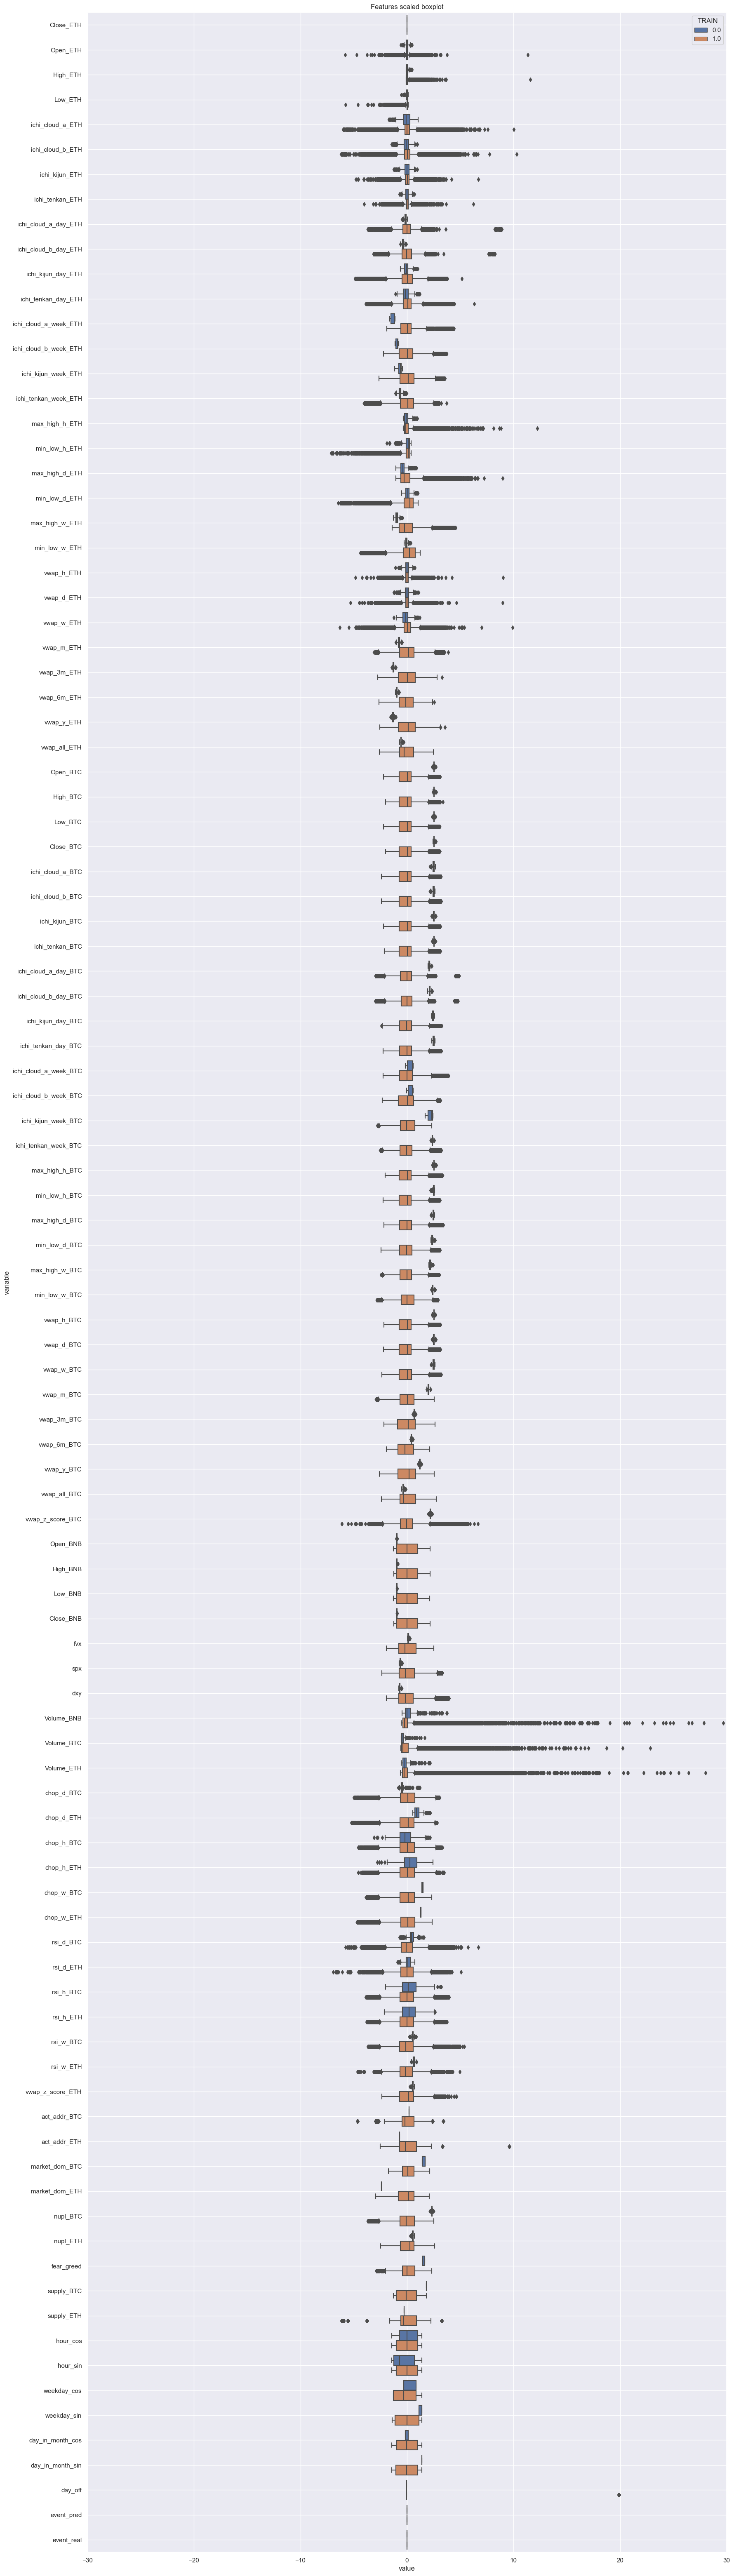

In [62]:
df_comp = df.melt(id_vars=["TRAIN"], value_vars=list_col_select, value_name="value")
plt.figure(figsize=(20, 80))
sns.boxplot(data=df_comp, x="value", y="variable" , hue="TRAIN")
fig = plt.gcf()
ax = fig.gca()
ax.set_xlim([-30,30])
ax.yaxis.grid(True)
plt.title("Features scaled boxplot")

<Axes: >

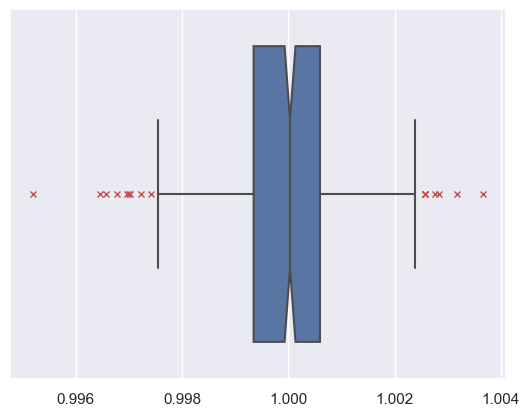

In [63]:
sns.boxplot(
    x=X_test[:,-1,:][:,1],  
    notch=True,
    flierprops={"markeredgecolor":"r", "marker": "x"}
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


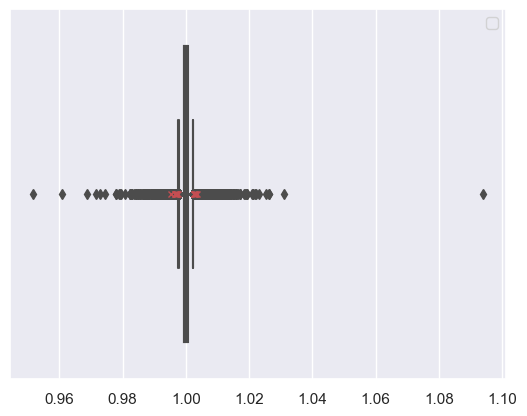

In [64]:
ax = sns.boxplot(
    x=X_train[:,-1,:][:,1],  
)
sns.boxplot(
    x=X_test[:,-1,:][:,1],  
    ax=ax, 
    flierprops={"markeredgecolor":"r", "marker": "x"},
)
plt.legend(loc='upper right')

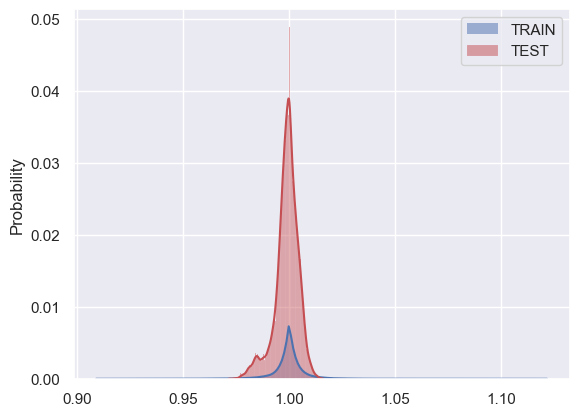

In [65]:

ax = sns.histplot(x=X_train.reshape(-1, X_train.shape[-1])[:,0],  stat="probability", kde=True, label="TRAIN")
sns.histplot(
    x=X_test.reshape(-1, X_test.shape[-1])[:,0],  
    stat="probability", 
    kde=True, 
    ax=ax, 
    color="r",
    label="TEST")
plt.legend(loc='upper right')

## Correlation

To simplify, we try to find correlation between all features X t-0 and target y t+1

In [66]:
X_train_sca.shape

(89319, 72, 102)

In [67]:
X_train_sca[:,-1,:].shape

(89319, 102)

In [68]:
y_train_sca[:,0][:, np.newaxis]

array([[ 0.10486614],
       [-0.03163928],
       [-0.20648228],
       ...,
       [-0.33221009],
       [ 0.07130442],
       [-0.4027299 ]])

In [69]:
np.hstack((X_train_sca[:,-1,:], y_train_sca[:,0][:, np.newaxis])).shape

(89319, 103)

In [70]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

In [71]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

In [72]:
def plot_corr(corr_matrix, title='Corrélation with 2 variables', aspect=None):
    # Afficher la matrice de corrélation
    if aspect is None:
        aspect = 1
    fig_size = (16, 16*len(corr_matrix.index)/len(corr_matrix.columns))
    fig, ax = plt.subplots(figsize=fig_size)
    im = ax.matshow(corr_matrix, aspect=aspect)
    plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
    plt.yticks(range(len(corr_matrix.index)), corr_matrix.index)
    plt.title(title)
    fig.colorbar(im)
    plt.show()

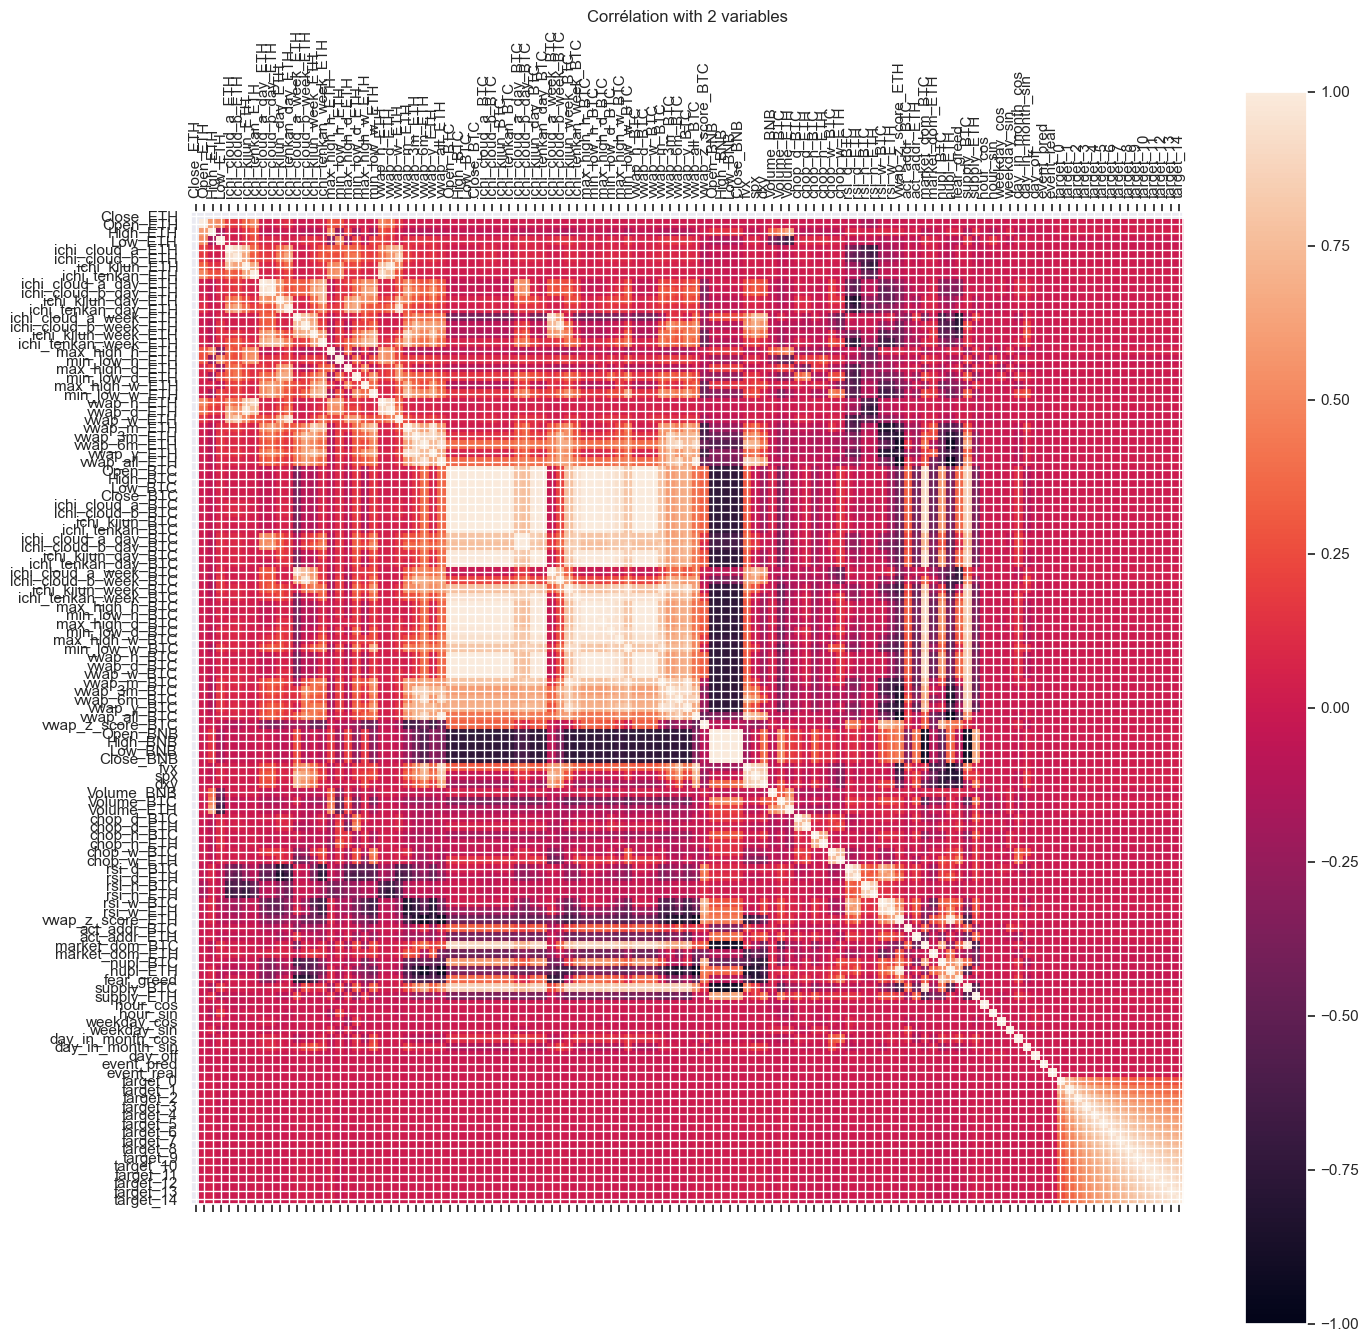

In [73]:

nb_plot = len(list_col_select)
list_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]
list_col_corr = list_col_select[:nb_plot] + list_col_targets

# Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y
#df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train[:,0][:, np.newaxis])), 
#    columns=list_col_select[:nb_plot] + ['target'])
df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train)), 
    columns=list_col_corr)
# Calculer la matrice de corrélation
corr_matrix = df.corr()

fig = plot_corr(corr_matrix)


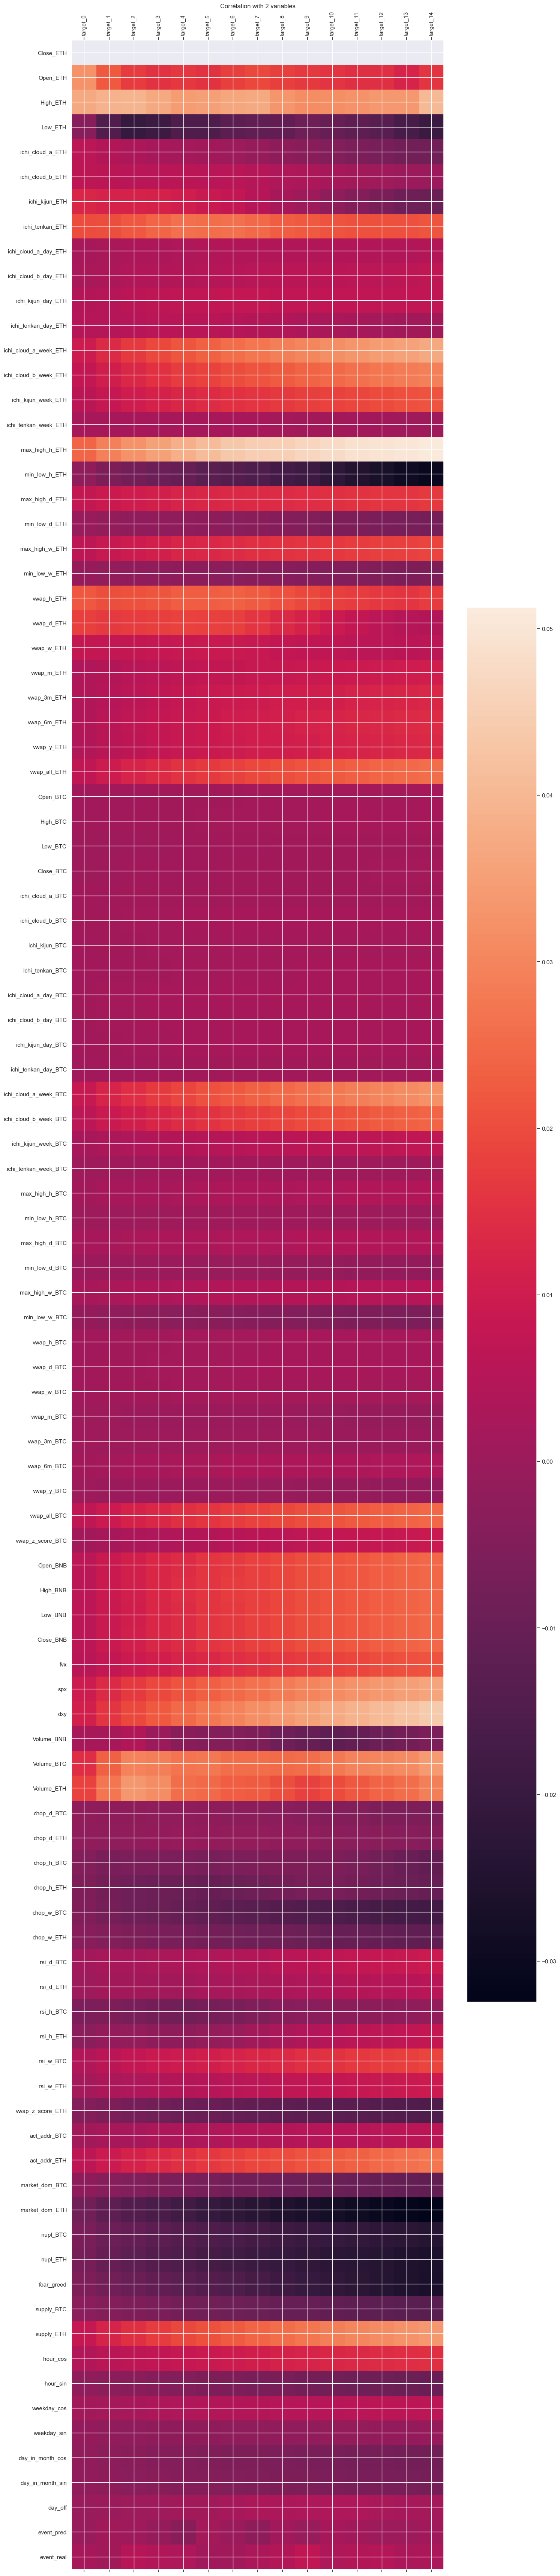

In [74]:
corr_matrix_targets = corr_matrix.copy().loc[list_col_select[:nb_plot], list_col_targets]
fig = plot_corr(corr_matrix_targets)


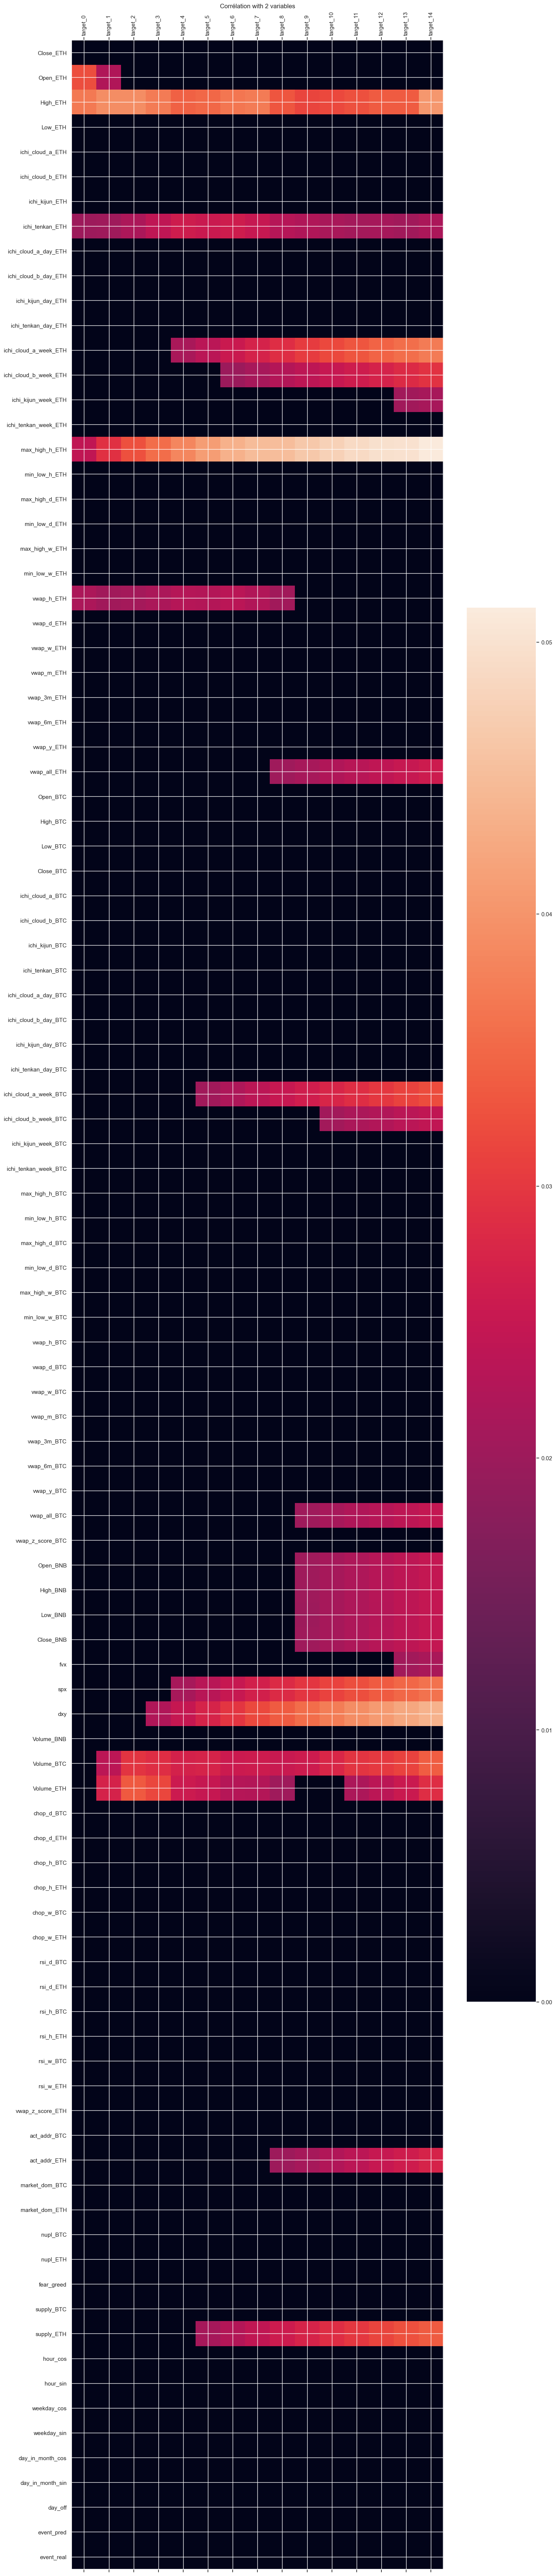

In [75]:
fig = plot_corr(corr_matrix_targets.where(corr_matrix_targets>0.02, 0))

In [76]:
list_ichi_level=["lower", "neutral", "higher"]
df["ichi_cloud_a_week_cat"] = "neutral"
df.loc[df["ichi_cloud_a_week_ETH"] >= 1.05, "ichi_cloud_a_week_cat"] = "lower"
df.loc[df["ichi_cloud_a_week_ETH"] <= 0.95, "ichi_cloud_a_week_cat"] = "higher"

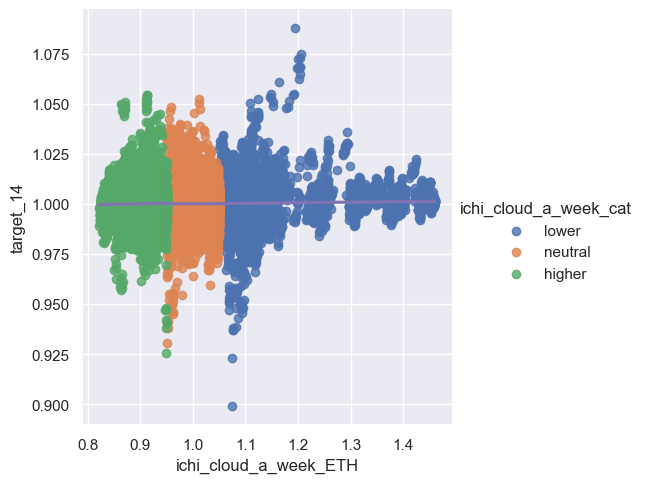

In [77]:
sns.lmplot(x="ichi_cloud_a_week_ETH", y="target_14",
            hue="ichi_cloud_a_week_cat", data=df,
           line_kws={"color": "C4"})

<Axes: xlabel='target_14', ylabel='ichi_cloud_a_week_cat'>

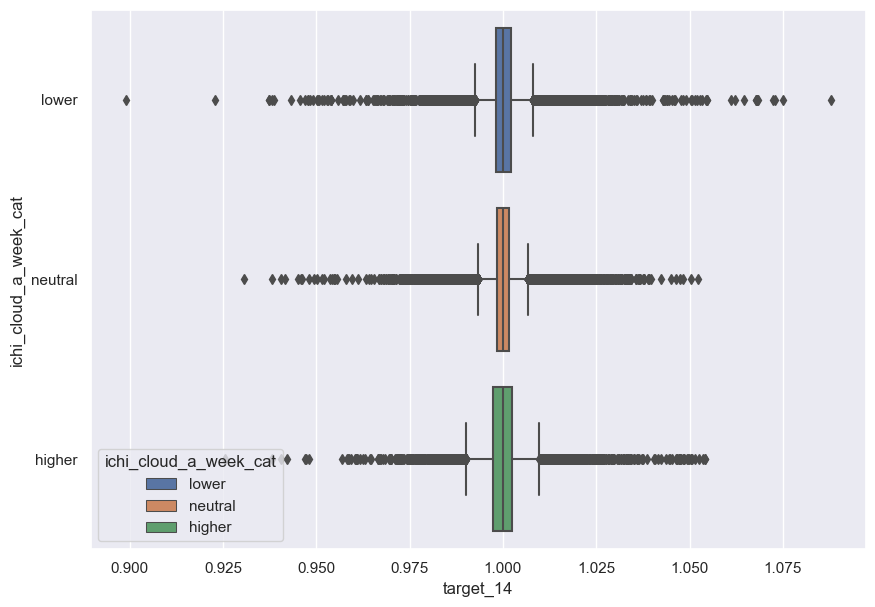

In [78]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="target_14", y="ichi_cloud_a_week_cat", 
    hue="ichi_cloud_a_week_cat", dodge=False, 
    order=list_ichi_level, hue_order=list_ichi_level)

In [79]:
"""df["vwap_all_ETH_under"] = df["vwap_all_ETH"] >= 1.05
df["vwap_all_ETH_above"] = df["vwap_all_ETH"] <= 0.95
df["vwap_all_ETH_neutral"] = ((df["vwap_all_ETH"] > 0.95) & (df["vwap_all_ETH"] < 1.05))
"""
list_vwap_level=["lower", "neutral", "higher"]
df["vwap_all_ETH_cat"] = "neutral"
df.loc[df["vwap_all_ETH"] >= 1.05, "vwap_all_ETH_cat"] = "lower"
df.loc[df["vwap_all_ETH"] <= 0.95, "vwap_all_ETH_cat"] = "higher"


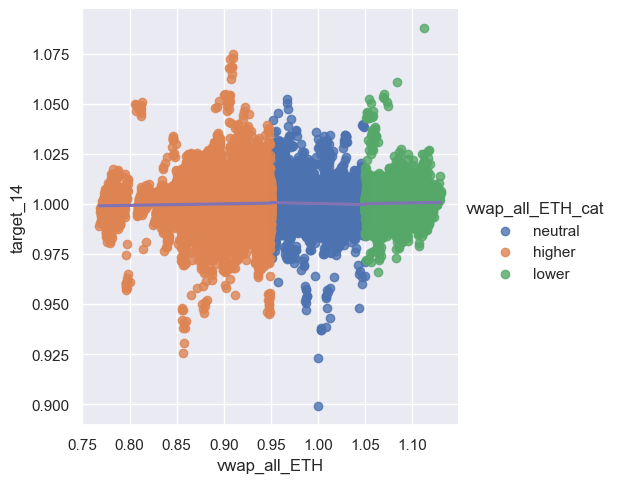

In [80]:
sns.lmplot(x="vwap_all_ETH", y="target_14", hue="vwap_all_ETH_cat", data=df,
           line_kws={"color": "C4"})

<Axes: xlabel='target_14', ylabel='vwap_all_ETH_cat'>

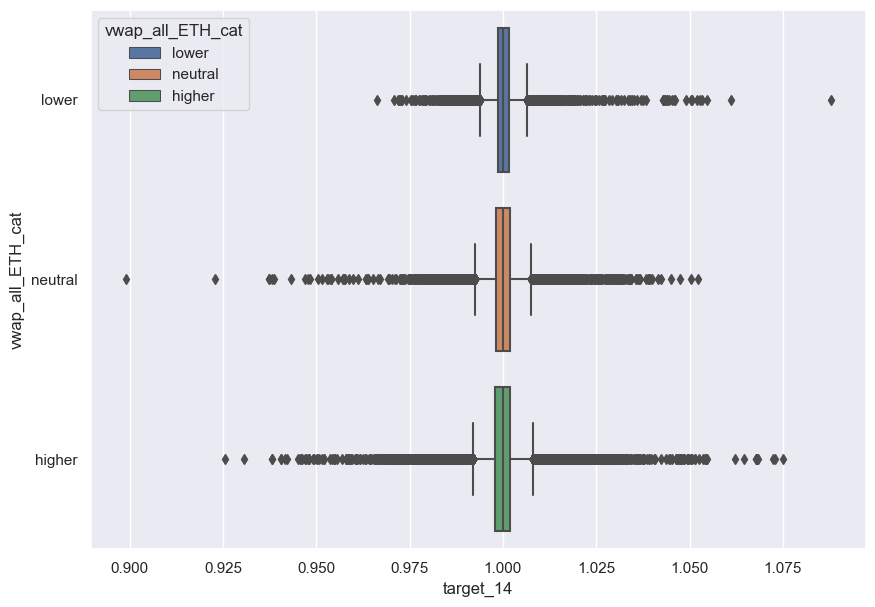

In [81]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="target_14", y="vwap_all_ETH_cat", 
    hue="vwap_all_ETH_cat", dodge=False, 
    order=list_vwap_level, hue_order=list_vwap_level)

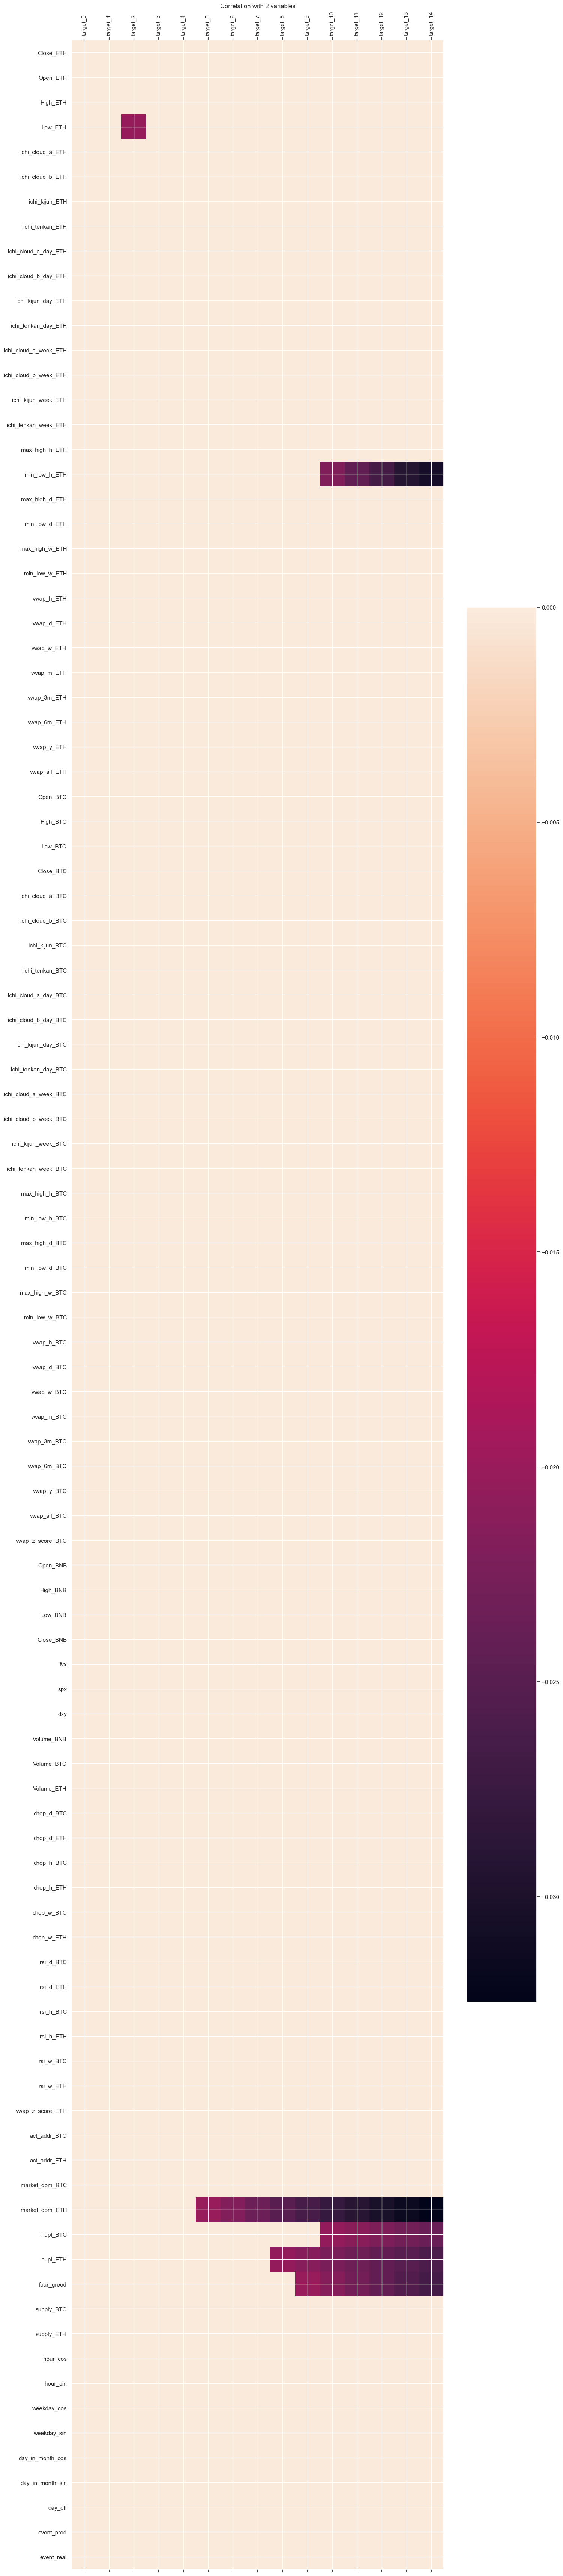

In [82]:
plot_corr(corr_matrix_targets.where(corr_matrix_targets<-0.02, 0))

Text(0.5, 1.0, 'Net Unrealized Profit/Loss impact : ETH price = f(NUPL)')

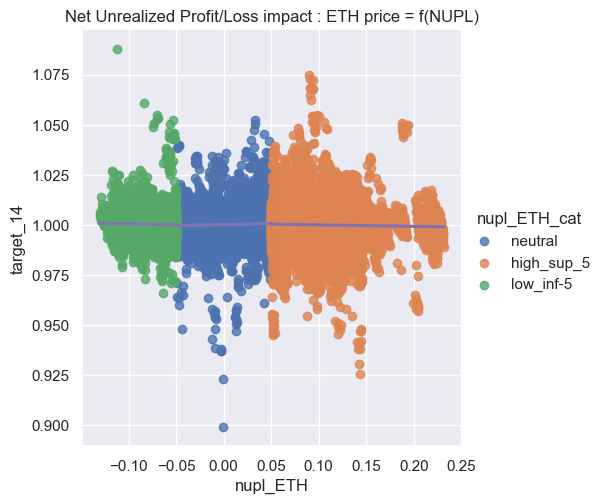

In [83]:
list_nupl_level=["low_inf-5", "neutral", "high_sup_5"]
df["nupl_ETH_cat"] = "neutral"
df.loc[df["nupl_ETH"] <= -0.05, "nupl_ETH_cat"] = "low_inf-5"
df.loc[df["nupl_ETH"] >= 0.05, "nupl_ETH_cat"] = "high_sup_5"

sns.lmplot(x="nupl_ETH", y="target_14", hue="nupl_ETH_cat", data=df,
           line_kws={"color": "C4"})
plt.title("Net Unrealized Profit/Loss impact : ETH price = f(NUPL)")

(0.98, 1.02)

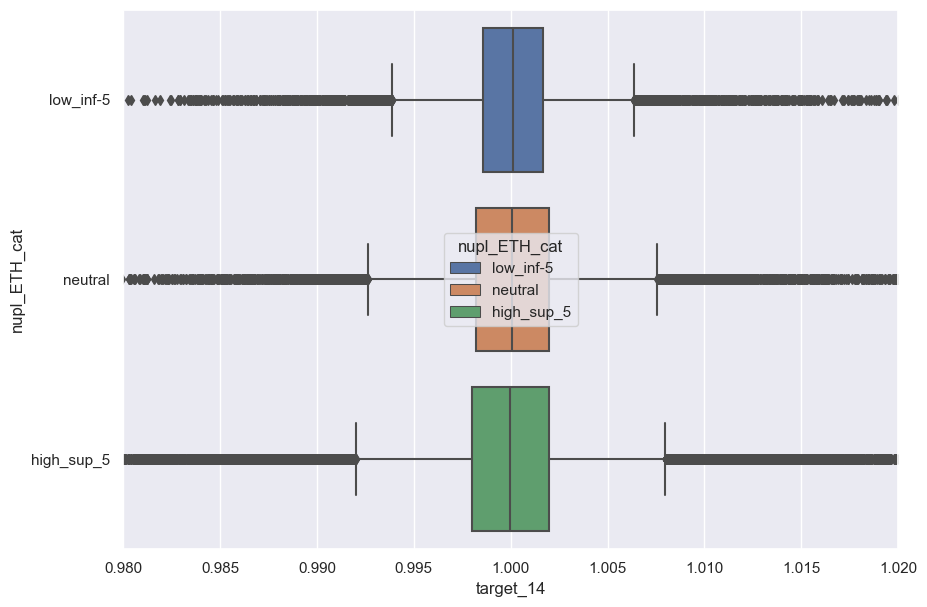

In [84]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="target_14", y="nupl_ETH_cat", 
    hue="nupl_ETH_cat", dodge=False, 
    order=list_nupl_level, hue_order=list_nupl_level)
ax = fig.gca()
ax.set_xlim([0.98,1.02])

In [85]:
df["target_14"].describe()

count    89319.000000
mean         1.000090
std          0.005343
min          0.899006
25%          0.998150
50%          1.000021
75%          1.001932
max          1.087790
Name: target_14, dtype: float64

In [86]:
df["target_1"].describe()

count    89319.000000
mean         1.000012
std          0.001994
min          0.907143
25%          0.999283
50%          1.000005
75%          1.000741
max          1.053076
Name: target_1, dtype: float64

<Axes: xlabel='target_14'>

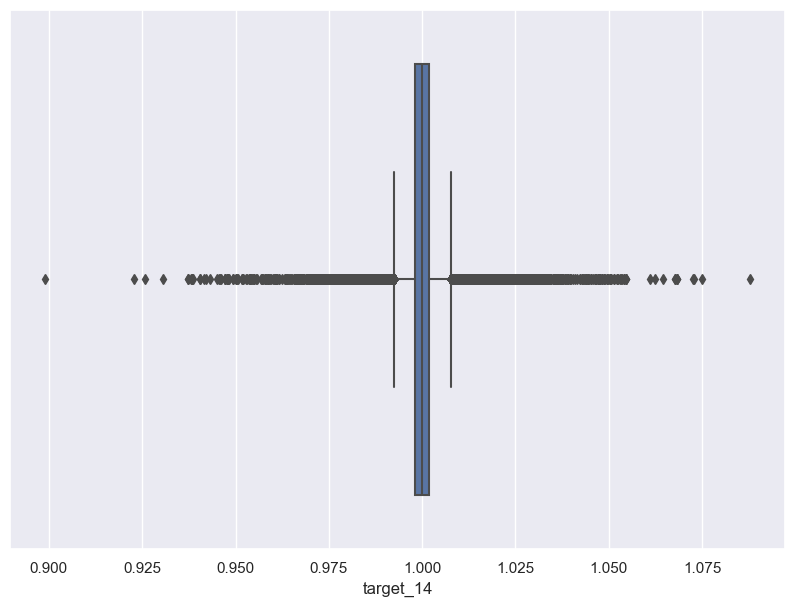

In [87]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(x=df["target_14"]) 

In [88]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [0.99874506, 0.99907335, 0.99754306, ..., 0.99354524, 0.9916337 ,
        0.99276157],
       [1.00032871, 0.9987965 , 0.99860563, ..., 0.99287971, 0.99400899,
        0.99461339],
       [0.99846829, 0.99827749, 0.99822979, ..., 0.99368236, 0.99428656,
        0.99490137]])

In [89]:
y_train_sca

array([[ 0.10486614,  0.08566882, -0.10843738, ..., -0.04018025,
         0.02594384, -0.04871239],
       [-0.03163928, -0.22565615, -0.05509187, ..., -0.09133678,
        -0.16595865, -0.31733445],
       [-0.20648228, -0.03590515, -0.15744136, ..., -0.14678029,
        -0.29816749, -0.37066277],
       ...,
       [-0.33221009, -0.24855998, -0.63847744, ..., -1.65711992,
        -2.14417944, -1.85680084],
       [ 0.07130442, -0.31910297, -0.36773503, ..., -1.82669693,
        -1.53895722, -1.38495569],
       [-0.4027299 , -0.45134598, -0.4635    , ..., -1.6221833 ,
        -1.46823238, -1.31158055]])

## Autoencoder

### Model creation

### Training

In [90]:
X_train_sca.shape

(89319, 72, 102)

In [91]:
3*3*3*10*35/3600

2.625

In [92]:
#tf.keras.optimizers.AdamW()

In [93]:
#tf.keras.optimizers.legacy.AdamW()

In [94]:
#n_unit_enc = 16
#encoding_dim = 4
#dropout_autoenc = 0.5
#epochs = 500 #100 #150 #6 #300
#patience = 0 #30 #20 #40 #3 #100
mse_curr_min = None
if MODE_TRAIN_AE:
    for n_unit_enc in LIST_UNITS_AE: #[32, 64, 128]: #[104]: #
        for encoding_dim in LIST_UNITS_ENC_AE:#[16, 20, 32]:
            for dropout_autoenc in LIST_DROPOUT_AE: #[0.05, 0.15, 0.25]: #[0.25]:
                for seed in LIST_SEEDS:
                    # check already done ? 
                    #ie: output_MSE autoencoder - units 16 - enc_dim 4 - drop 0.25.jpg
                    plt_name = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
                    path_jpg = os.path.join(path_data,
                        f"output_MSE autoencoder - {plt_name}.jpg")
                    if (MODE_TRAIN_AE == False):
                        print(f"BE CAREFUL ! training inactivated => no training done...")
                        continue
                    print(f"Training: {plt_name} ...")
                    # Init
                    tf.keras.backend.clear_session()
                    np.random.seed(seed)
                    random.seed(seed)
                    tf.random.set_seed(seed)
                    # Input dimension
                    input_dim = X_train.shape[-1]
                    # Reduced encoded input dimension
                    # 64/8/0.5
                    # Définir l'encodeur
                    encoder_inputs = keras.Input(shape=(None, input_dim))
                    encoder = layers.LSTM(n_unit_enc, return_sequences=True)(encoder_inputs)
                    #encoder = layers.LayerNormalization()(encoder)
                    #encoder = layers.Dense(encoding_dim, activation='relu')
                    encoder = layers.Dropout(dropout_autoenc)(encoder)
                    encoder_outputs = layers.Dense(encoding_dim)(encoder)
                    encoder_model = keras.Model(encoder_inputs, encoder_outputs)
                    print(encoder_model.summary())
                    # Définir le décodeur
                    decoder_inputs = keras.Input(shape=(None, encoding_dim))
                    decoder = layers.LSTM(n_unit_enc, return_sequences=True)(decoder_inputs)
                    #decoder = layers.LayerNormalization()(decoder)
                    #decoder = layers.Dense(n_unit_enc, activation='relu')
                    decoder = layers.Dropout(dropout_autoenc)(decoder)
                    decoder_outputs = layers.Dense(input_dim)(decoder)
                    decoder_model = keras.Model(decoder_inputs, decoder_outputs)
                    print(decoder_model.summary())
                    # Define complete autoencoder 
                    autoencoder_inputs = keras.Input(shape=(None, input_dim))
                    encoded = encoder_model(autoencoder_inputs)
                    decoded = decoder_model(encoded)
                    autoencoder = keras.Model(autoencoder_inputs, decoded)
                    # Compile : autoencoder
                    optim = tf.keras.optimizers.legacy.Adam()
                    #optim = tf.keras.optimizers.AdamW()
                    #optim = tf.keras.optimizers.Adam()
                    autoencoder.compile(optimizer=optim, loss="mse")
                    # earlystop 
                    es = EarlyStopping(patience=PATIENCE_AE, verbose=2, min_delta=0.001, 
                                    monitor='val_loss', mode='auto', restore_best_weights=True)
                    # Train
                    if PATIENCE_AE == 0:
                        autoenc_step_history = autoencoder.fit(X_train_sca,X_train_sca,
                        epochs=EPOCHS_AE, batch_size=BATCH_SIZE, validation_data=(X_test_sca,X_test_sca),
                        verbose=1)
                    else:
                        autoenc_step_history = autoencoder.fit(X_train_sca,X_train_sca,
                            epochs=EPOCHS_AE, batch_size=BATCH_SIZE, validation_data=(X_test_sca,X_test_sca),
                            verbose=1, callbacks=[es])

                    plot_train_history(
                        autoenc_step_history,f"MSE autoencoder - {plt_name}",
                        saveFolder=path_data)
                    #autoencoder.save(f"{path_mdl_autoencoder}_u{n_unit_enc}_e{encoding_dim}_d{dropout_autoenc}")
                    #encoder_model.save(f"{path_mdl_encoder}_u{n_unit_enc}_e{encoding_dim}_d{dropout_autoenc}")
                                # save the best
                    mse_curr = np.min(autoenc_step_history.history['val_loss'])
                    print("MSE TEST : ", mse_curr)

                    if mse_curr_min == None:
                        seed_min = seed
                        autoenc_step_history_min = autoenc_step_history
                        mse_curr_min = mse_curr
                        n_unit_enc_min = n_unit_enc
                        encoding_dim_min = encoding_dim
                        dropout_autoenc_min = dropout_autoenc
                        print("Save autoencoder: ", path_mdl_autoencoder)
                        autoencoder.save(path_mdl_autoencoder)
                        print("Save encoder: ", path_mdl_encoder)
                        encoder_model.save(path_mdl_encoder)
                    else:
                        if mse_curr < mse_curr_min:
                            seed_min = seed
                            autoenc_step_history_min = autoenc_step_history
                            mse_curr_min = mse_curr
                            n_unit_enc_min = n_unit_enc
                            encoding_dim_min = encoding_dim
                            dropout_autoenc_min = dropout_autoenc
                            print("Save autoencoder: ", path_mdl_autoencoder)
                            autoencoder.save(path_mdl_autoencoder)
                            print("Save encoder: ", path_mdl_encoder)
                            encoder_model.save(path_mdl_encoder)

    mse_curr = mse_curr_min 
    n_unit_enc = n_unit_enc_min 
    encoding_dim = encoding_dim_min
    dropout_autoenc = dropout_autoenc_min

print("Load models...")
autoencoder = tf.keras.models.load_model(path_mdl_autoencoder)
print(autoencoder.summary())
encoder_model = tf.keras.models.load_model(path_mdl_encoder)
print(encoder_model.summary())
n_unit_enc = encoder_model.layers[1].units
dropout_autoenc = encoder_model.layers[2].rate
encoding_dim = encoder_model.layers[3].units
print(f"Model : n_unit:{n_unit_enc} / enc_dim: {encoding_dim} / dropout: {dropout_autoenc}")

if MODE_TRAIN_AE:
    print(f"Best model : seed:{seed} / n_unit:{n_unit_enc} / enc_dim: {encoding_dim} / dropout: {dropout_autoenc}")
    plot_train_history(
        autoenc_step_history_min, 
        f"Best MSE autoencoder - {plt_name}",
        saveFolder=path_data,
    )

Load models...
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, 102)]       0         
                                                                 
 model (Functional)          (None, None, 32)          1275936   
                                                                 
 model_1 (Functional)        (None, None, 102)         1168486   
                                                                 
Total params: 2444422 (9.32 MB)
Trainable params: 2444422 (9.32 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 102)]       0         
                                                    

In [95]:
path_mdl_autoencoder

'data/mdl_autoencoder'

In [96]:
#autoencoder.save(path_mdl_autoencoder)
#encoder_model.save(path_mdl_encoder)


In [97]:
X_train_sca_pred = autoencoder.predict(X_train_sca)
X_train_sca_pred.shape

2792/2792 [==============================] - 60s 21ms/step


(89319, 72, 102)

### Results

In [98]:
X_train[:,-1,0]

array([1., 1., 1., ..., 1., 1., 1.])

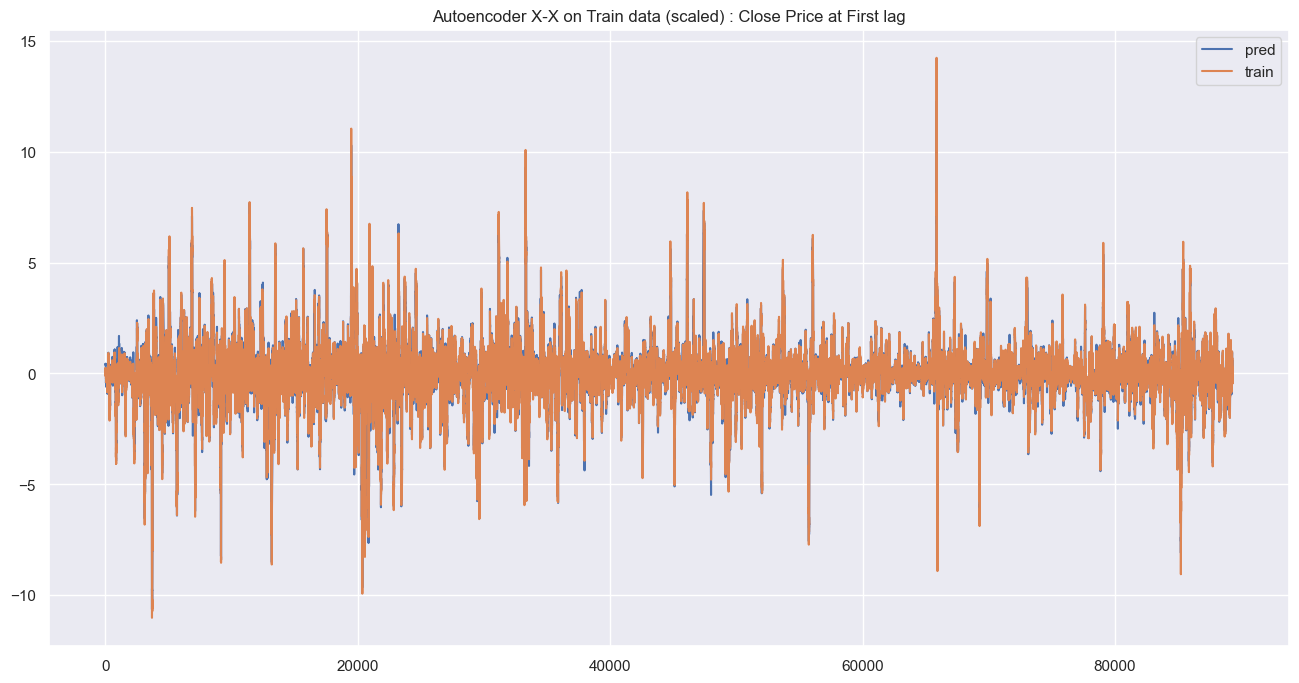

In [99]:
fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Train data (scaled) : Close Price at First lag")
plt.plot(X_train_sca_pred[:,0,0], label="pred")
plt.plot(X_train_sca[:,0,0], label="train")
plt.legend(loc='upper right')

##### MAE TRAIN by lags and by features

In [100]:
print(X_train_sca_pred.shape) 
print(X_train_sca.shape)

mae_ae_train = np.mean(np.abs(X_train_sca_pred - X_train_sca), 0)
print(mae_ae_train.shape)

df_mae_ae_train = pd.DataFrame(mae_ae_train, columns=list_col_select)
df_mae_ae_train.index = [f"lag_{i_lag}" for i_lag in range(len(df_mae_ae_train.index))]
mae_ae_train_feat = np.mean(mae_ae_train, 0)[np.newaxis,:]
print(mae_ae_train_feat.shape)

df_mae_ae_train_feat = pd.DataFrame(mae_ae_train_feat, columns=list_col_select)

(89319, 72, 102)
(89319, 72, 102)
(72, 102)
(1, 102)


In [101]:
df_mae_ae_train

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
lag_0    0.087786  0.103248  0.067099  0.072438          0.111784   
lag_1    0.070132  0.067630  0.054757  0.061145          0.100516   
lag_2    0.061673  0.061134  0.047091  0.054463          0.098122   
lag_3    0.059284  0.057009  0.043956  0.051571          0.096729   
lag_4    0.056647  0.053959  0.040641  0.048820          0.094263   
...           ...       ...       ...       ...               ...   
lag_67   0.049508  0.048085  0.033268  0.041968          0.051221   
lag_68   0.049438  0.048090  0.033239  0.041946          0.051193   
lag_69   0.049390  0.048090  0.033208  0.041915          0.051178   
lag_70   0.049359  0.048085  0.033175  0.041882          0.051165   
lag_71   0.049277  0.048101  0.033114  0.041843          0.051162   

        ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
lag_0           0.088465        0.102761         0.084120   
lag_1           0.074535        0.092074         0.076971   
lag_2           0.069276        0.086602         0.071310   
lag_3           0.067611        0.082398         0.066884   
lag_4           0.065769        0.078001         0.061030   
...                  ...             ...              ...   
lag_67          0.048909        0.048455         0.042850   
lag_68          0.048890        0.048445         0.042843   
lag_69          0.048879        0.048436         0.042837   
lag_70          0.048869        0.048431         0.042824   
lag_71          0.048865        0.048419         0.042813   

        ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  supply_ETH  hour_cos  \
lag_0               0.115242              0.103136  ...    0.129124  0.077344   
lag_1               0.083484              0.080188  ...    0.076209  0.048845   
lag_2               0.072341              0.070596  ...    0.055356  0.055071   
lag_3               0.067045              0.065646  ...    0.044857  0.054133   
lag_4               0.062927              0.061746  ...    0.038975  0.053376   
...                      ...                   ...  ...         ...       ...   
lag_67              0.039642              0.038943  ...    0.025631  0.046351   
lag_68              0.039669              0.038975  ...    0.025628  0.046336   
lag_69              0.039692              0.039010  ...    0.025626  0.046316   
lag_70              0.039727              0.039043  ...    0.025627  0.046300   
lag_71              0.039759              0.039084  ...    0.025625  0.046284   

        hour_sin  weekday_cos  weekday_sin  day_in_month_cos  \
lag_0   0.080076     0.085686     0.080931          0.098934   
lag_1   0.049554     0.048700     0.048231          0.059691   
lag_2   0.054608     0.043057     0.041761          0.044557   
lag_3   0.052671     0.038713     0.037526          0.040776   
lag_4   0.051187     0.037805     0.035983          0.040364   
...          ...          ...          ...               ...   
lag_67  0.042784     0.033831     0.033082          0.035815   
lag_68  0.042774     0.033813     0.033077          0.035816   
lag_69  0.042765     0.033801     0.033071          0.035812   
lag_70  0.042749     0.033786     0.033066          0.035810   
lag_71  0.042737     0.033766     0.033067          0.035813   

        day_in_month_sin   day_off  event_pred  event_real  
lag_0           0.094607  0.105463    0.152344    0.201749  
lag_1           0.059095  0.068112    0.088121    0.102889  
lag_2           0.045190  0.042097    0.057882    0.054460  
lag_3           0.039088  0.031241    0.038481    0.036260  
lag_4           0.038548  0.025860    0.032476    0.029373  
...                  ...       ...         ...         ...  
lag_67          0.034638  0.017389    0.022248    0.020455  
lag_68          0.034632  0.017372    0.022234    0.020454  
lag_69          0.034626  0.017352    0.022230    0.020446  
lag_70          0.034611  0.017327    0.022223    0.020445  
lag_71          0.034597  0.01731

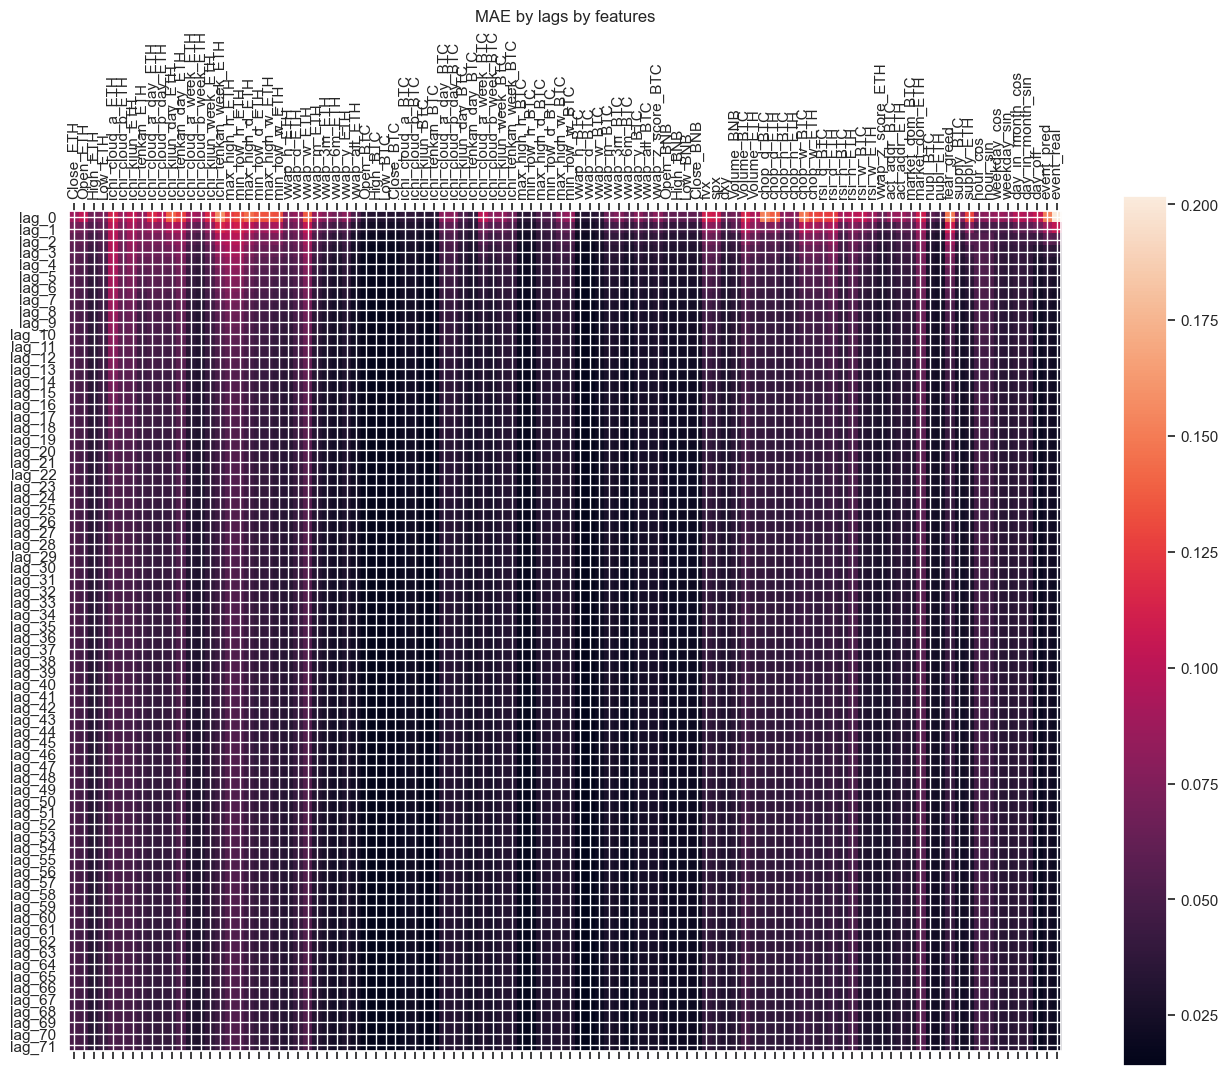

In [102]:
plot_corr(df_mae_ae_train, "MAE by lags by features", aspect=1.2 )

/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


<Axes: >

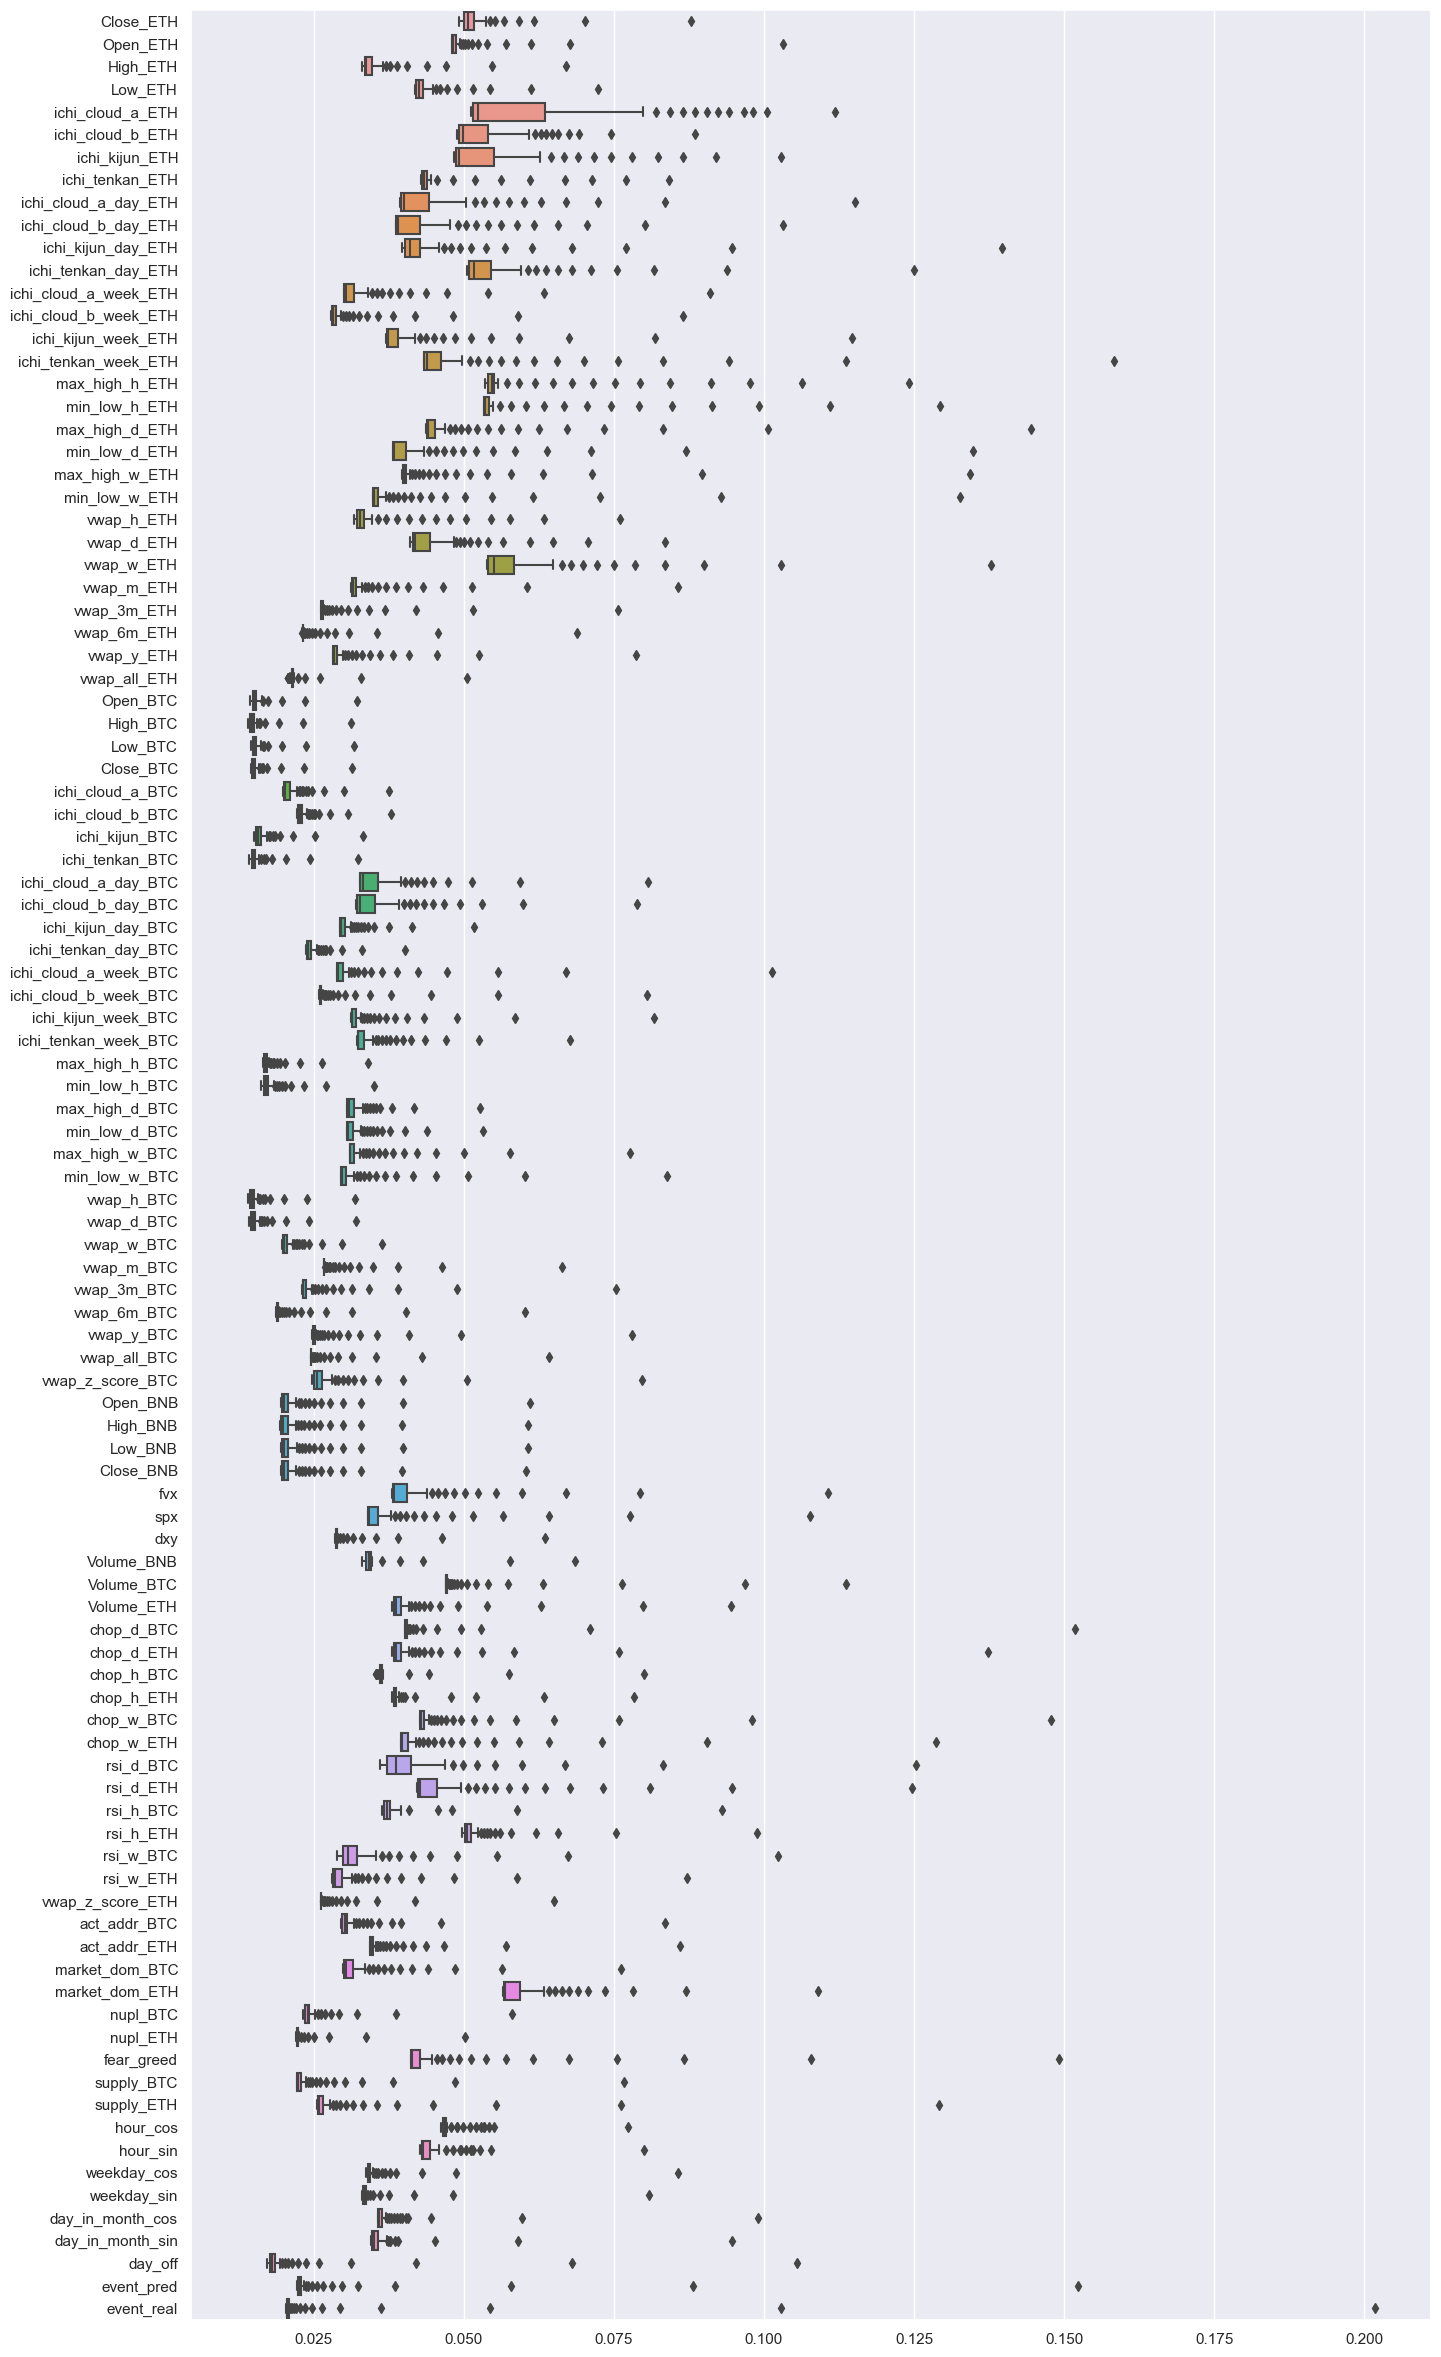

In [103]:
plt.figure(figsize=(16, 30))
sns.boxplot(data=df_mae_ae_train, orient="h")

In [104]:
df_mae_ae_train_feat

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0   0.052025  0.049897  0.035331  0.043806          0.060862   

   ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0          0.053193        0.054506         0.045754               0.04486   

   ichi_cloud_b_day_ETH  ...  supply_ETH  hour_cos  hour_sin  weekday_cos  \
0               0.04365  ...    0.029467   0.04786  0.044902     0.035475   

   weekday_sin  day_in_month_cos  day_in_month_sin   day_off  event_pred  \
0     0.034542           0.03768          0.036722  0.020829    0.026435   

   event_real  
0     0.02536  

[1 rows x 102 columns]

Text(0.5, 1.0, 'MAE per feature')

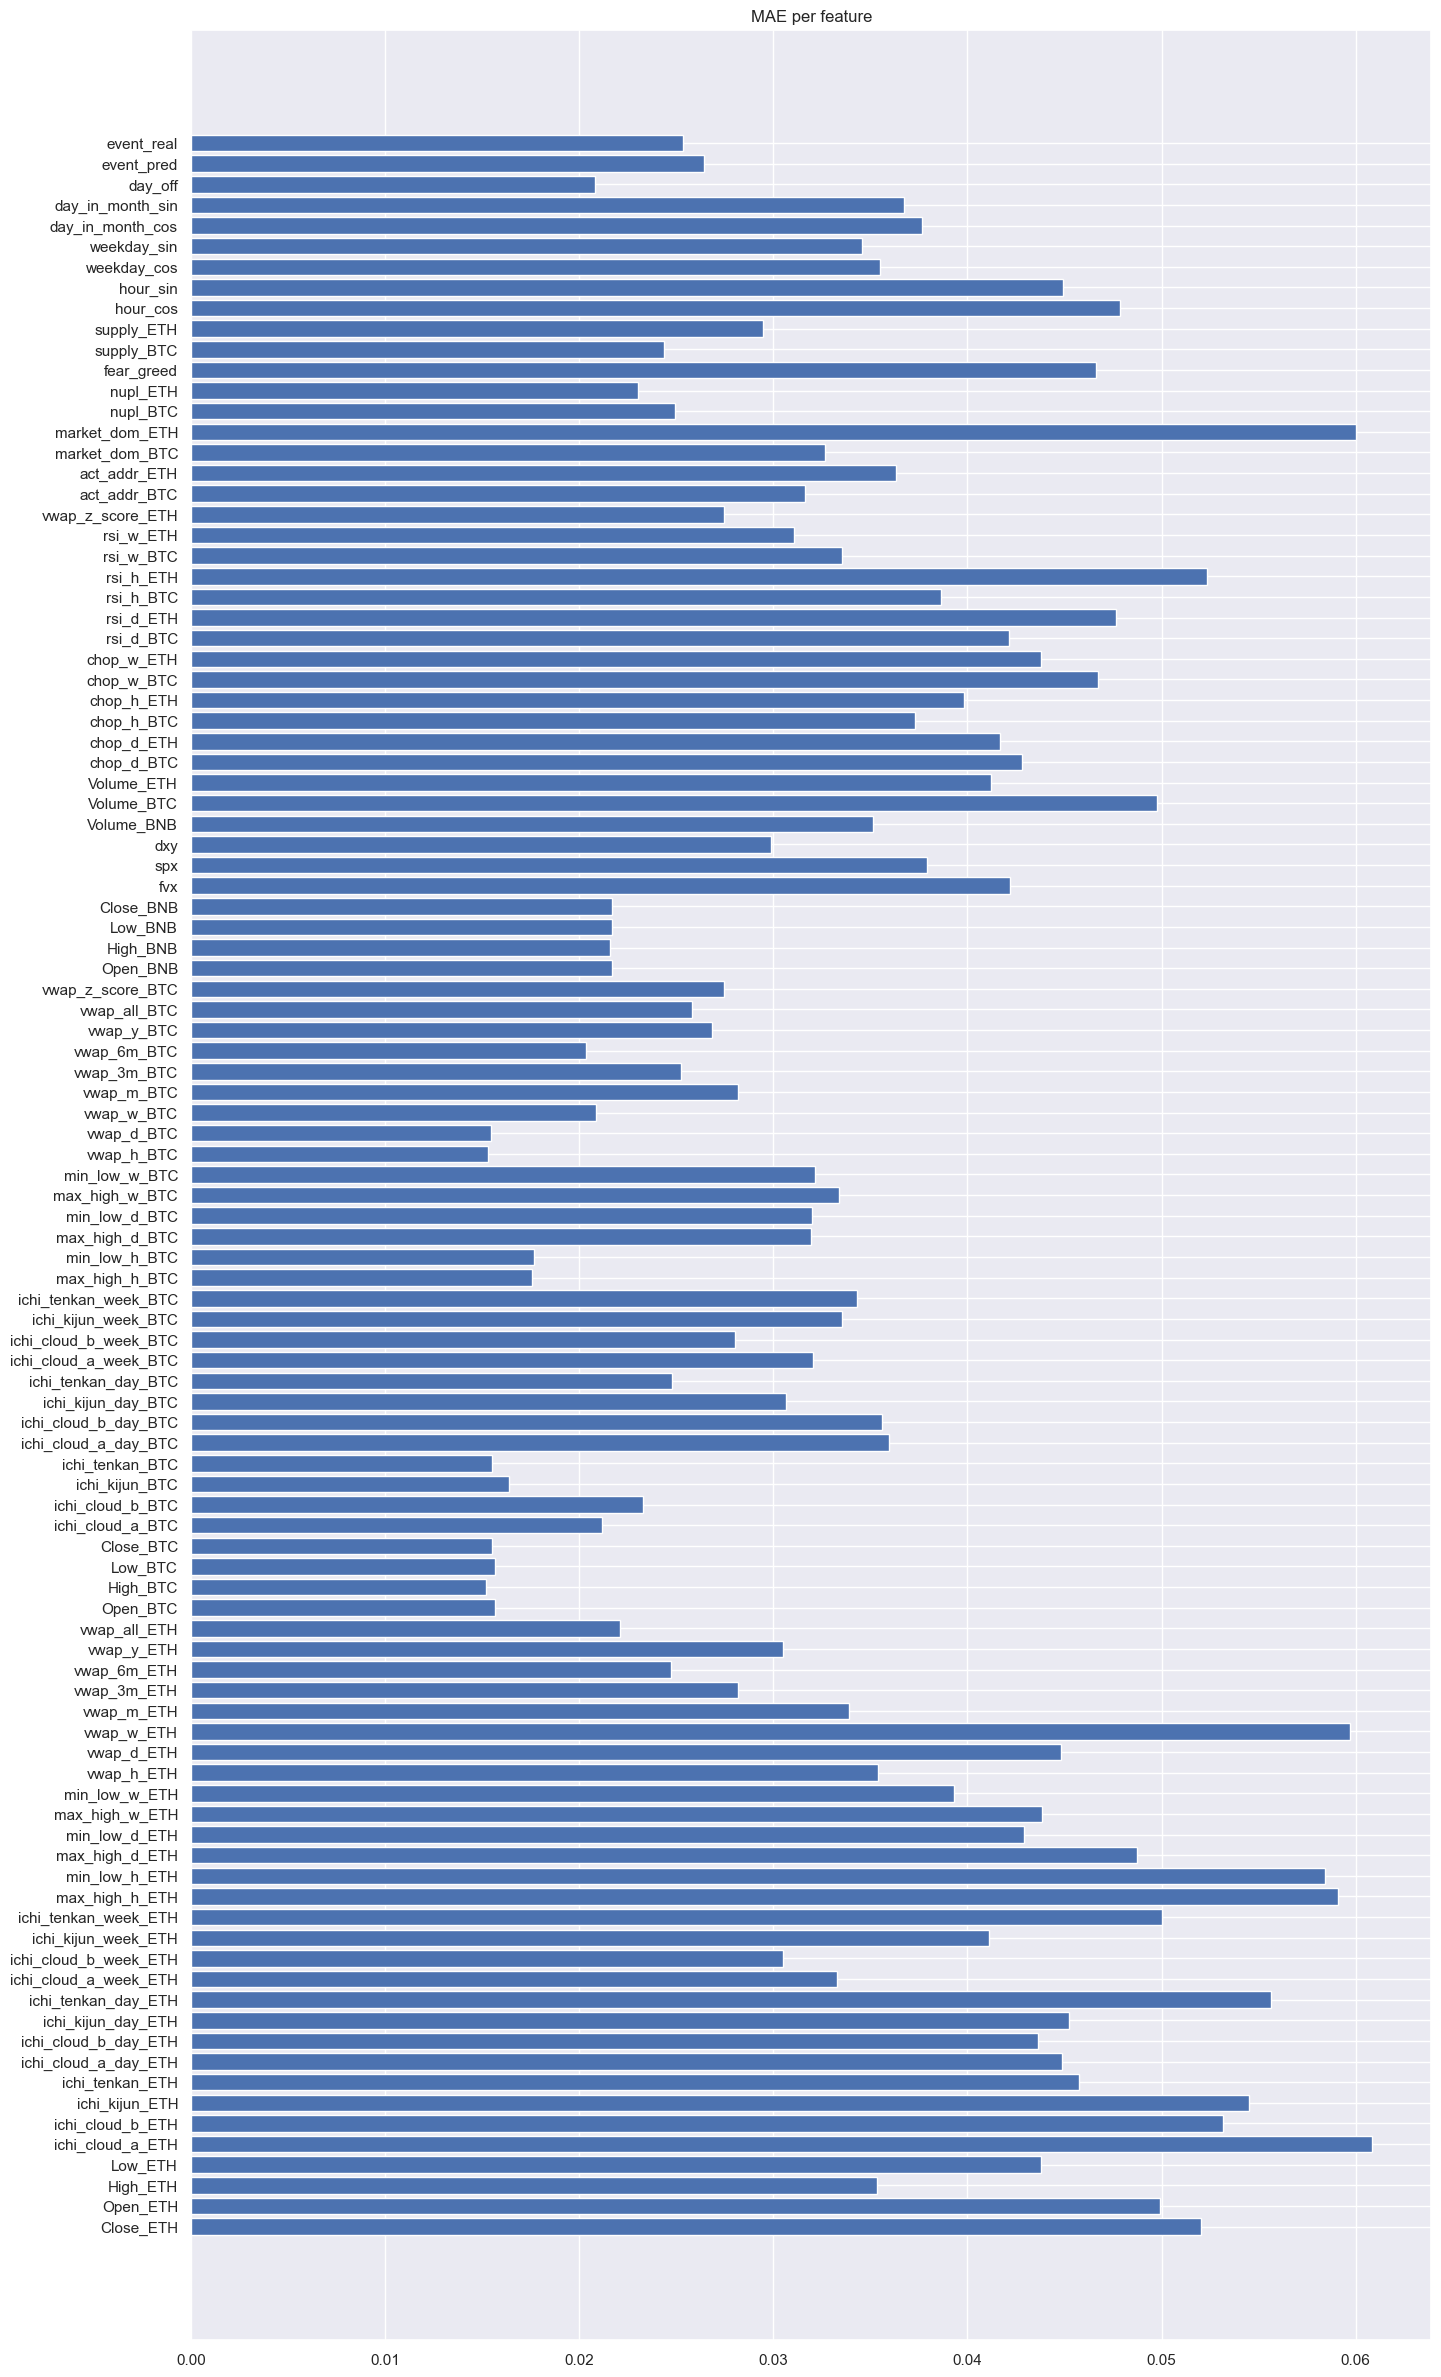

In [105]:
plt.figure(figsize=(16, 30))
plt.barh(df_mae_ae_train_feat.columns, df_mae_ae_train_feat.values[0])
plt.title("MAE per feature")

In [106]:
# X_train_raw
# X_train[0,:10, 0] * X_train_raw[0,-1, 0]
# [samples, lags, features]
print(X_train[:,0, 0].shape)
print(X_train_raw[:,-1, 0].shape)
print(X_train[:,0, 0] * X_train_raw[:,-1, 0])
print(df_feat["Close_ETH"].values[:3])

(89319,)
(89319,)
[1196.32 1195.38 1194.55 ... 1884.07 1885.33 1886.35]
[1196.32 1195.38 1194.55]


In [107]:
X_train_pred = scaler.inverse_transform(X_train_sca_pred.reshape(-1,X_train_sca_pred.shape[-1])).reshape(X_train_sca_pred.shape)
X_train_pred[:,-1,0]

array([0.99913627, 0.9994941 , 0.99988675, ..., 0.99993646, 1.0005221 ,
       0.9995703 ], dtype=float32)

[1196.32 1195.38 1194.55 ... 1884.07 1885.33 1886.35]
[1198.29352858 1198.74809511 1198.58887136 ... 1881.45100223 1883.53096717
 1885.09960995]


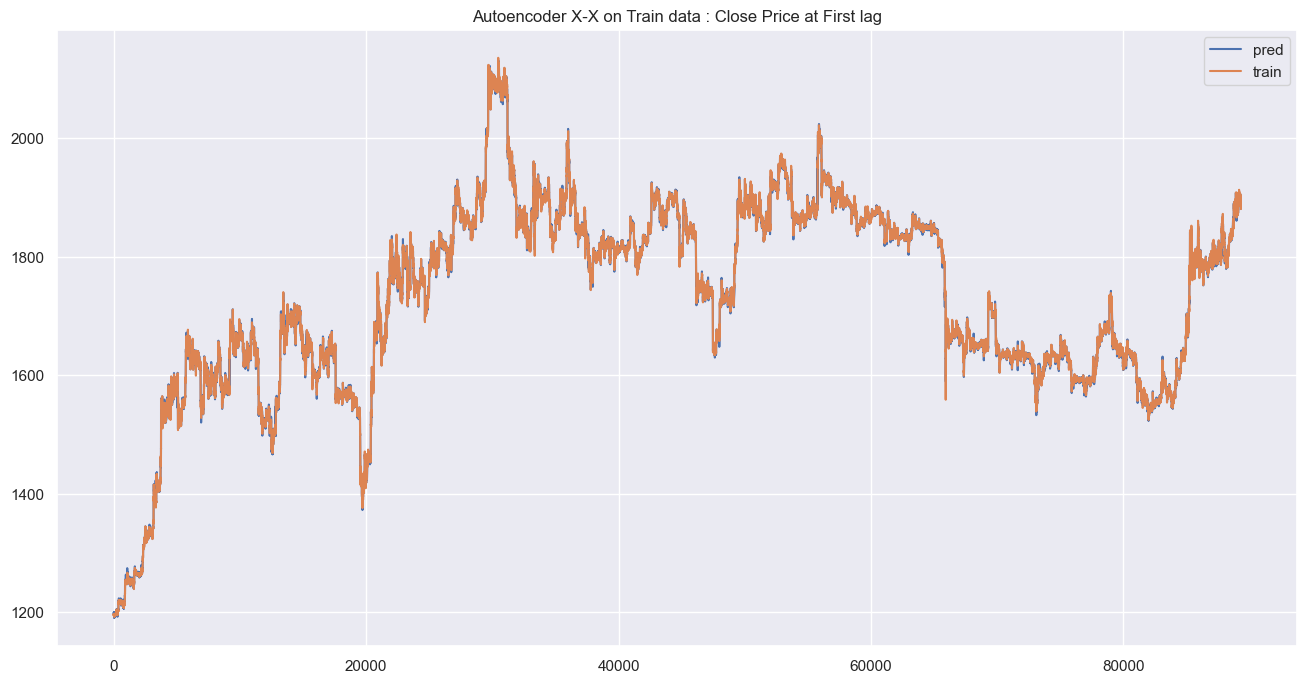

In [108]:
print(X_train_raw[:,0, 0])
print(X_train_pred[:,0, 0] * X_train_raw[:,-1, 0])

fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Train data : Close Price at First lag")
plt.plot(X_train_pred[:,0, 0] * X_train_raw[:,-1, 0], label="pred")
plt.plot(X_train_raw[:,0,0], label="train")
plt.legend(loc='upper right')

#### MAE TEST per features

In [109]:
X_test_sca_pred = autoencoder.predict(X_test_sca)
X_test_sca_pred.shape

12/12 [==============================] - 0s 35ms/step


(361, 72, 102)

In [110]:
df_feat["date_ETH"].iloc[TRAIN_SPLIT]

'2023-11-07 10:25:00'

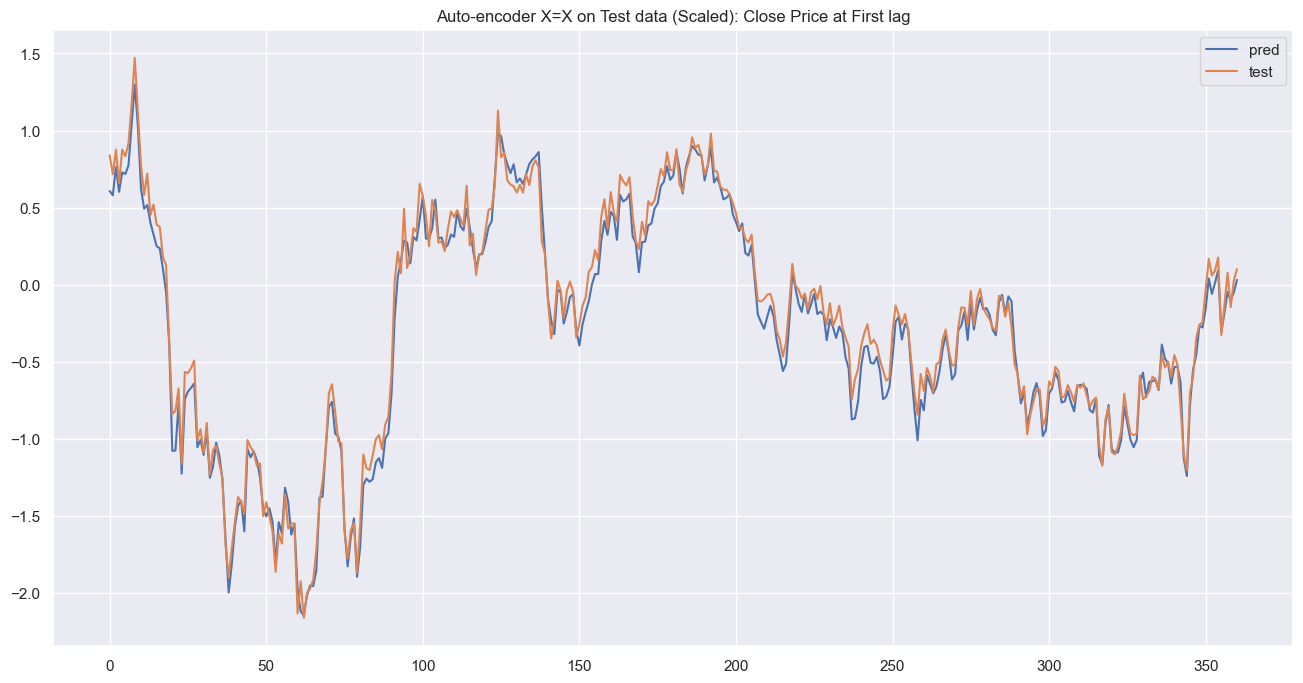

In [111]:
fig = plt.figure(figsize=(16, 8))
plt.title("Auto-encoder X=X on Test data (Scaled): Close Price at First lag")
plt.plot(X_test_sca_pred[:,0,0], label="pred")
plt.plot(X_test_sca[:,0,0], label="test")
plt.legend(loc='upper right')

In [112]:
# X  _raw : df feat raw data
# X : price normalized
# X  _sca : standardized use by model
# X      _pred : predict
X_test_pred = scaler.inverse_transform(X_test_sca_pred.reshape(-1,X_test_sca_pred.shape[-1])).reshape(X_test_sca_pred.shape)
print("X test raw  : ", X_test_raw[:,0, 0][:9])
print("X test pred : ", (X_test_pred[:,0,0] * X_test_raw[:,-1, 0])[:9])

X test raw  :  [1879.35 1878.02 1876.35 1871.64 1870.5  1869.65 1872.14 1872.88 1874.05]
X test pred :  [1875.80125997 1875.93541886 1874.62732781 1870.77938326 1868.24416767
 1867.90339512 1869.97391441 1870.79636483 1871.38905687]


[1879.35 1878.02 1876.35 1871.64 1870.5  1869.65 1872.14 1872.88 1874.05
 1874.8  1875.95 1874.81 1876.14 1873.85 1875.66 1875.79 1875.67 1873.39
 1874.85 1870.02 1871.83 1877.01 1876.48 1874.58 1876.96 1877.54 1878.29
 1879.45 1878.12 1877.53 1876.54 1876.46 1875.55 1876.95 1876.   1873.1
 1872.   1868.59 1868.64 1872.   1871.84 1873.31 1872.   1874.54 1877.13
 1877.14 1875.17 1874.73 1874.66 1871.96 1876.16 1875.21 1875.44 1876.95
 1875.66 1874.05 1875.33 1871.   1870.4  1870.7  1861.64 1864.28 1861.69
 1862.73 1863.   1863.1  1864.98 1863.87 1865.7  1864.42 1865.31 1866.79
 1867.34 1863.26 1861.87 1857.44 1857.25 1858.48 1855.38 1851.98 1858.
 1864.41 1866.18 1865.4  1867.23 1867.99 1870.11 1870.2  1870.93 1873.16
 1876.01 1885.09 1890.   1887.19 1892.95 1886.02 1886.72 1886.94 1887.36
 1894.09 1892.39 1893.78 1890.67 1894.99 1893.9  1892.52 1891.37 1891.68
 1895.16 1898.54 1898.89 1896.02 1895.01 1894.22 1897.95 1893.08 1893.81
 1892.31 1893.28 1892.96 1895.6  1898.43 1898.85 1900.

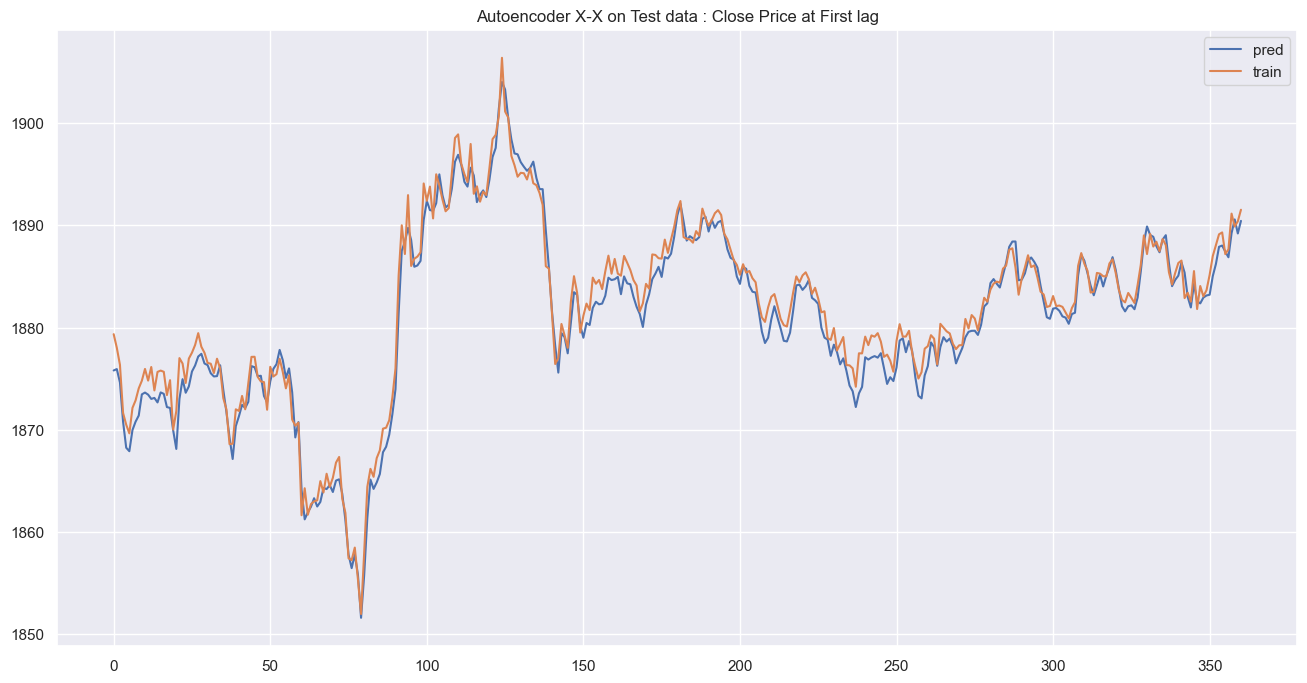

In [113]:
print(X_test_raw[:,0, 0])
print(X_test_pred[:,0, 0] * X_test_raw[:,-1, 0])

fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Test data : Close Price at First lag")
plt.plot(X_test_pred[:,0, 0] * X_test_raw[:,-1, 0], label="pred")
plt.plot(X_test_raw[:,0,0], label="train")
plt.legend(loc='upper right')

In [114]:
X_test_sca.shape

(361, 72, 102)

In [115]:
mean_absolute_error(X_test_sca[:,0,:], X_test_sca_pred[:,0,:])

0.1447731217525064

In [116]:
print(X_test_sca_pred.shape) 
print(X_test_sca.shape)
mae_ae_test = np.mean(np.abs(X_test_sca_pred - X_test_sca), 0)
print(mae_ae_test.shape)
mae_ae_test_feat = np.mean(mae_ae_test, 0)[np.newaxis,:]
print(mae_ae_test_feat.shape)
df_mae_ae_test = pd.DataFrame(mae_ae_test, columns=list_col_select)
df_mae_ae_test.index = [f"lag_{i_lag}" for i_lag in range(len(df_mae_ae_test.index))]
df_mae_ae_test_feat = pd.DataFrame(mae_ae_test_feat, columns=list_col_select)
df_mae_ae_test["dataset"] = "TEST"
df_mae_ae_train["dataset"] = "TRAIN"
df_mae_ae_comp = pd.concat([df_mae_ae_train, df_mae_ae_test], ignore_index=False)
df_mae_ae_comp

(361, 72, 102)
(361, 72, 102)
(72, 102)
(1, 102)


Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
lag_0    0.087786  0.103248  0.067099  0.072438          0.111784   
lag_1    0.070132  0.067630  0.054757  0.061145          0.100516   
lag_2    0.061673  0.061134  0.047091  0.054463          0.098122   
lag_3    0.059284  0.057009  0.043956  0.051571          0.096729   
lag_4    0.056647  0.053959  0.040641  0.048820          0.094263   
...           ...       ...       ...       ...               ...   
lag_67   0.049597  0.048972  0.027631  0.041188          0.057893   
lag_68   0.049368  0.049014  0.027637  0.041222          0.057767   
lag_69   0.049393  0.048885  0.027649  0.041444          0.057697   
lag_70   0.049430  0.049090  0.027741  0.041579          0.057615   
lag_71   0.049483  0.048994  0.027663  0.041378          0.057651   

        ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
lag_0           0.088465        0.102761         0.084120   
lag_1           0.074535        0.092074         0.076971   
lag_2           0.069276        0.086602         0.071310   
lag_3           0.067611        0.082398         0.066884   
lag_4           0.065769        0.078001         0.061030   
...                  ...             ...              ...   
lag_67          0.087855        0.050316         0.034383   
lag_68          0.087815        0.050351         0.034547   
lag_69          0.087792        0.050434         0.034573   
lag_70          0.087870        0.050510         0.034271   
lag_71          0.088103        0.050488         0.034364   

        ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  hour_cos  hour_sin  \
lag_0               0.115242              0.103136  ...  0.077344  0.080076   
lag_1               0.083484              0.080188  ...  0.048845  0.049554   
lag_2               0.072341              0.070596  ...  0.055071  0.054608   
lag_3               0.067045              0.065646  ...  0.054133  0.052671   
lag_4               0.062927              0.061746  ...  0.053376  0.051187   
...                      ...                   ...  ...       ...       ...   
lag_67              0.143359              0.030101  ...  0.054817  0.042420   
lag_68              0.143369              0.030439  ...  0.054874  0.042321   
lag_69              0.143482              0.030702  ...  0.055007  0.042257   
lag_70              0.143609              0.030903  ...  0.055215  0.042214   
lag_71              0.143726              0.031124  ...  0.055320  0.042149   

        weekday_cos  weekday_sin  day_in_month_cos  day_in_month_sin  \
lag_0      0.085686     0.080931          0.098934          0.094607   
lag_1      0.048700     0.048231          0.059691          0.059095   
lag_2      0.043057     0.041761          0.044557          0.045190   
lag_3      0.038713     0.037526          0.040776          0.039088   
lag_4      0.037805     0.035983          0.040364          0.038548   
...             ...          ...               ...               ...   
lag_67     0.052578     0.059840          0.168717          0.059383   
lag_68     0.052616     0.059783          0.168994          0.059312   
lag_69     0.052700     0.059706          0.169157          0.059225   
lag_70     0.052784     0.059674          0.169412          0.059170   
lag_71     0.052816     0.059656          0.169631          0.059169   

         day_off  event_pred  event_real  dataset  
lag_0   0.105463    0.152344    0.201749    TRAIN  
lag_1   0.068112    0.088121    0.102889    TRAIN  
lag_2   0.042097    0.057882    0.054460    TRAIN  
lag_3   0.031241    0.038481    0.036260    TRAIN  
lag_4   0.025860    0.032476    0.029373    TRAIN  
...          ...         ...         ...      ...  
lag_67  0.027342    0.027735    0.027770     TEST  
lag_68  0.027384    0.027745    0.027934     TEST  
lag_69  0.027355    0.027821    0.027918     TEST  
lag_70  0.027281    0.027615    0.027912     TEST  
lag_71  0.027262    0.027550    0.027917     TEST  

[144 ro

In [117]:
df_mae_ae_test_feat

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0    0.05222  0.049766   0.02865  0.042991          0.074894   

   ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0          0.083571        0.055176         0.037126              0.148138   

   ichi_cloud_b_day_ETH  ...  supply_ETH  hour_cos  hour_sin  weekday_cos  \
0              0.036658  ...    0.064862  0.055237  0.042287     0.054118   

   weekday_sin  day_in_month_cos  day_in_month_sin   day_off  event_pred  \
0     0.061954          0.164127          0.060603  0.032442    0.028143   

   event_real  
0    0.040938  

[1 rows x 102 columns]

Text(0.5, 1.0, 'MAE per feature on TEST')

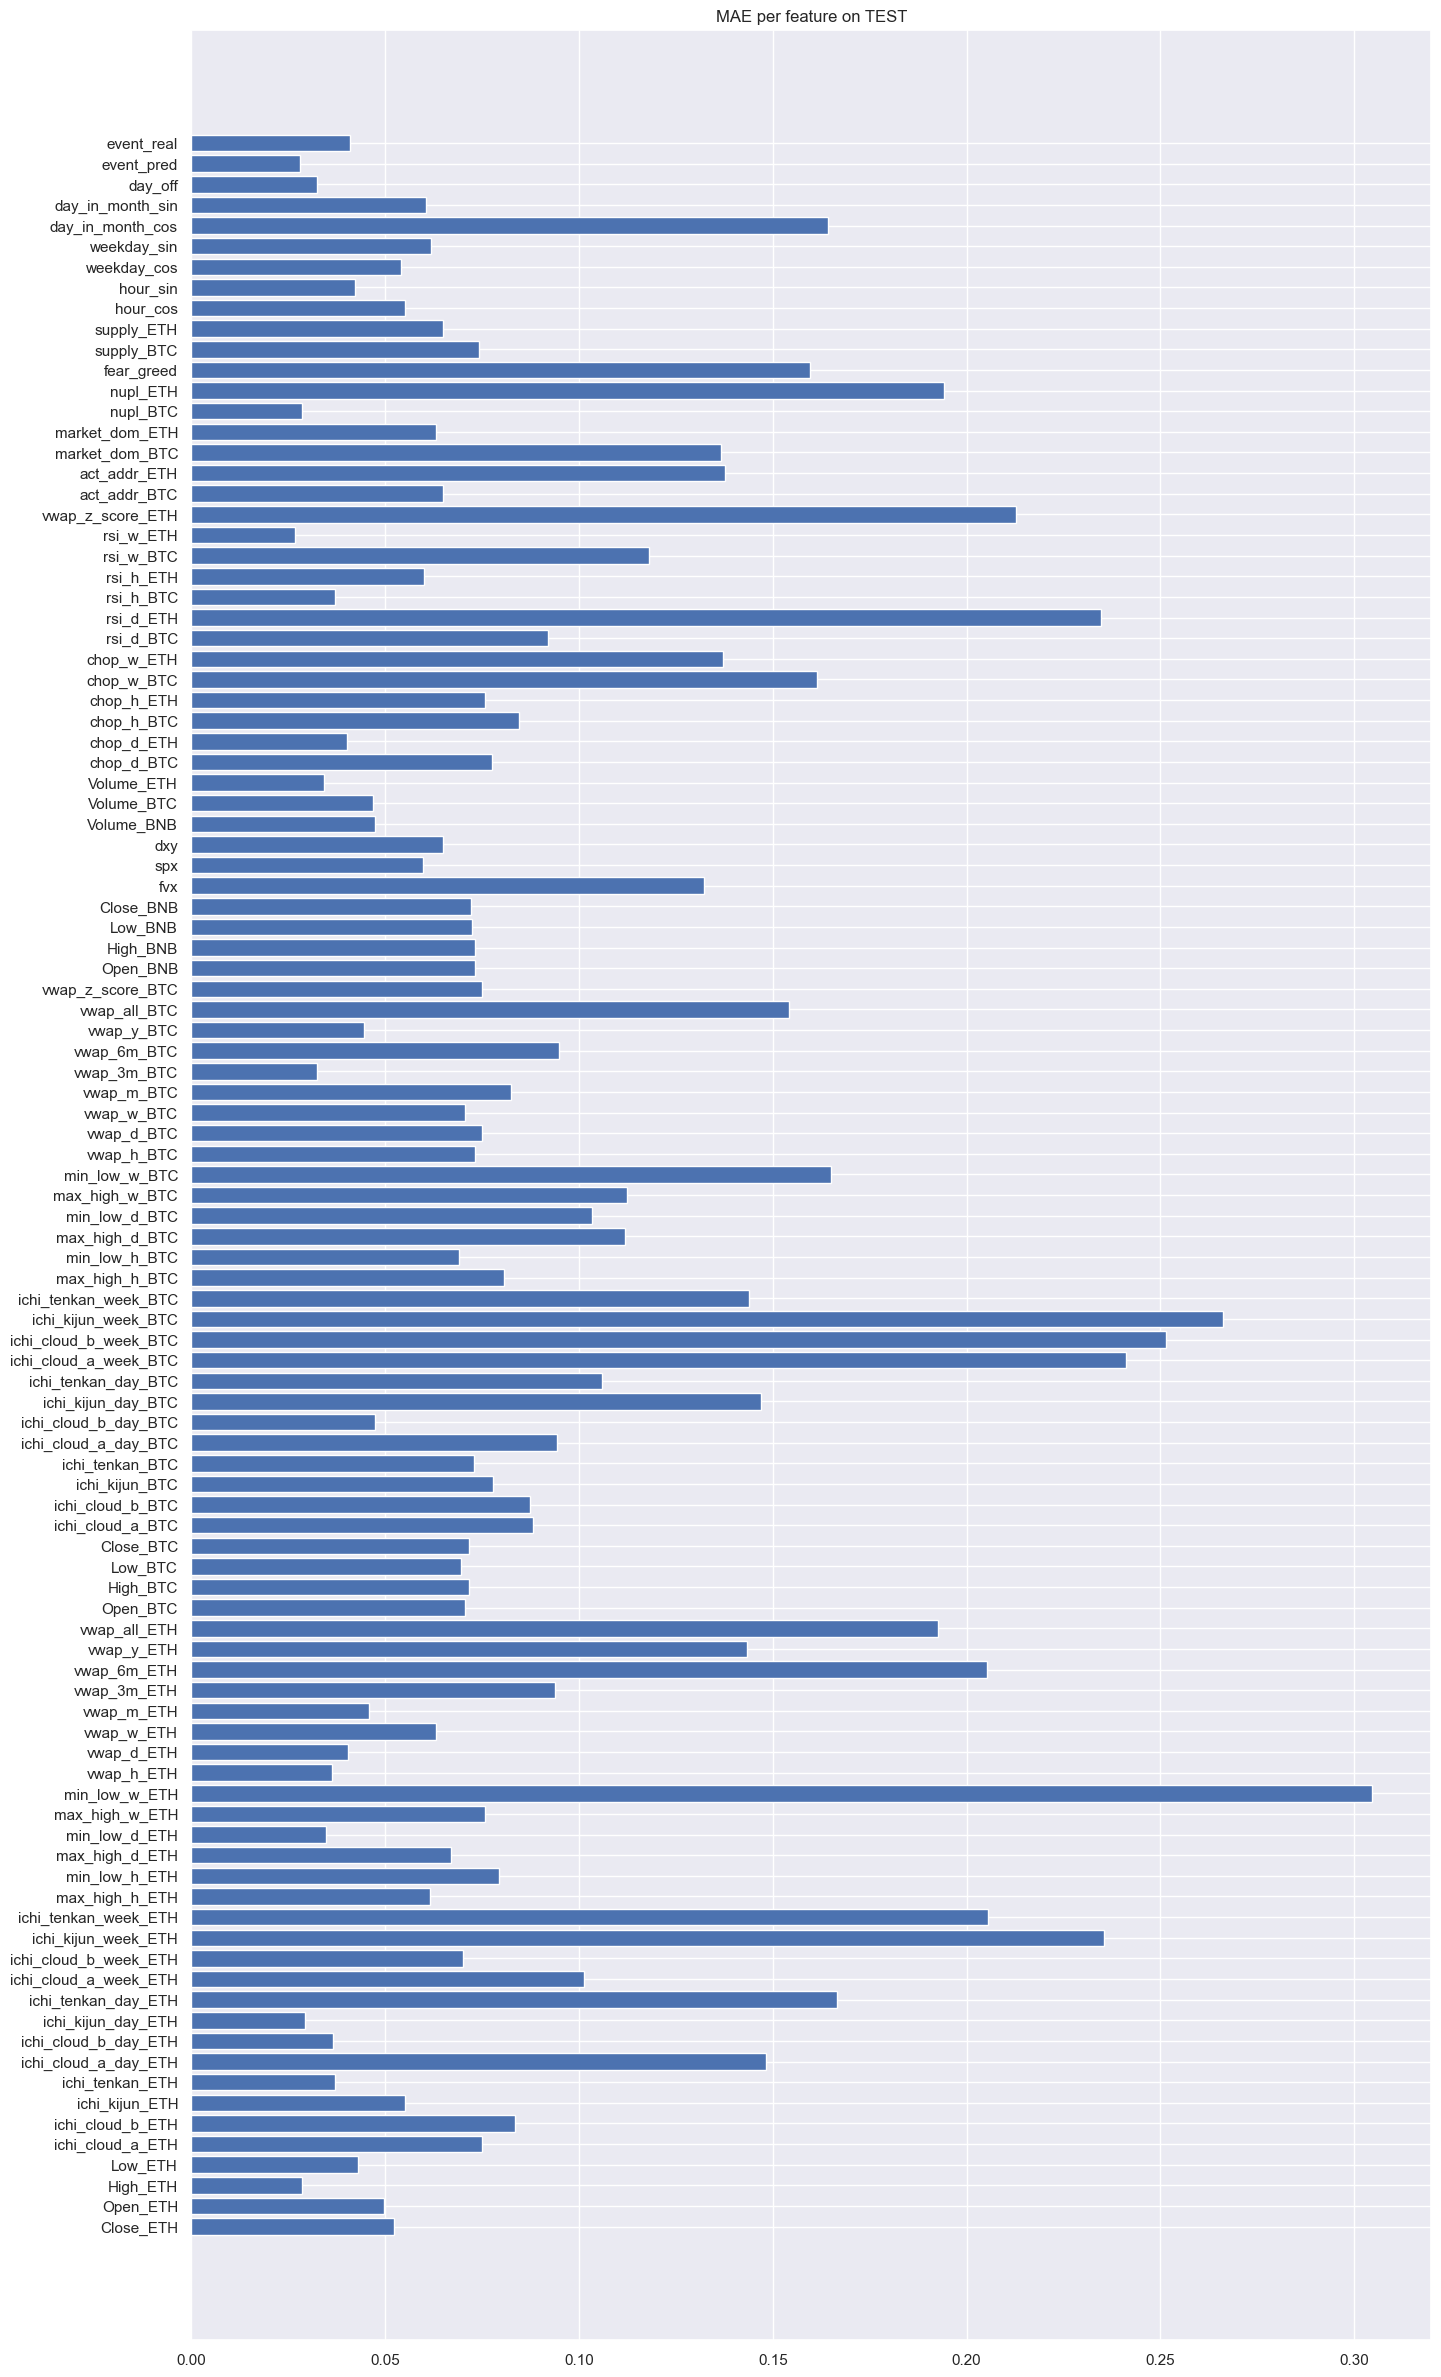

In [118]:
plt.figure(figsize=(16, 30))
plt.barh(df_mae_ae_test_feat.columns, df_mae_ae_test_feat.values[0])
plt.title("MAE per feature on TEST")

In [119]:
df_mae_ae_test_feat.values[0]

array([0.05221965, 0.04976574, 0.02865012, 0.04299112, 0.07489439,
       0.08357121, 0.05517638, 0.03712593, 0.14813806, 0.03665841,
       0.02936228, 0.16646111, 0.1012813 , 0.06998785, 0.23554902,
       0.20557659, 0.06159954, 0.07930252, 0.06699352, 0.03461762,
       0.07568647, 0.30463659, 0.03620548, 0.04052629, 0.06301401,
       0.04594151, 0.09374828, 0.2052434 , 0.14331386, 0.19263884,
       0.0706335 , 0.07168937, 0.06959687, 0.07160145, 0.08820504,
       0.0874886 , 0.07770087, 0.07281269, 0.09428322, 0.04741333,
       0.14692513, 0.10602319, 0.24110728, 0.25153829, 0.26610417,
       0.14385962, 0.080689  , 0.06910465, 0.11188227, 0.10346233,
       0.11230264, 0.16505844, 0.07313923, 0.07488998, 0.07072563,
       0.08255362, 0.03243906, 0.09479469, 0.04452115, 0.15419238,
       0.07495075, 0.07313061, 0.0730767 , 0.07244934, 0.07218912,
       0.13226694, 0.05986268, 0.06481835, 0.04733611, 0.04691862,
       0.03430779, 0.07755495, 0.04019974, 0.08449496, 0.07567

In [120]:
2/df_mae_ae_test_feat.values[0].sum()

0.20810429712711773

In [121]:
df_comp = df_mae_ae_comp.melt(id_vars=["dataset"], value_vars=list_col_select, value_name="MAE")
df_comp

dataset    variable       MAE
0       TRAIN   Close_ETH  0.087786
1       TRAIN   Close_ETH  0.070132
2       TRAIN   Close_ETH  0.061673
3       TRAIN   Close_ETH  0.059284
4       TRAIN   Close_ETH  0.056647
...       ...         ...       ...
14683    TEST  event_real  0.027770
14684    TEST  event_real  0.027934
14685    TEST  event_real  0.027918
14686    TEST  event_real  0.027912
14687    TEST  event_real  0.027917

[14688 rows x 3 columns]

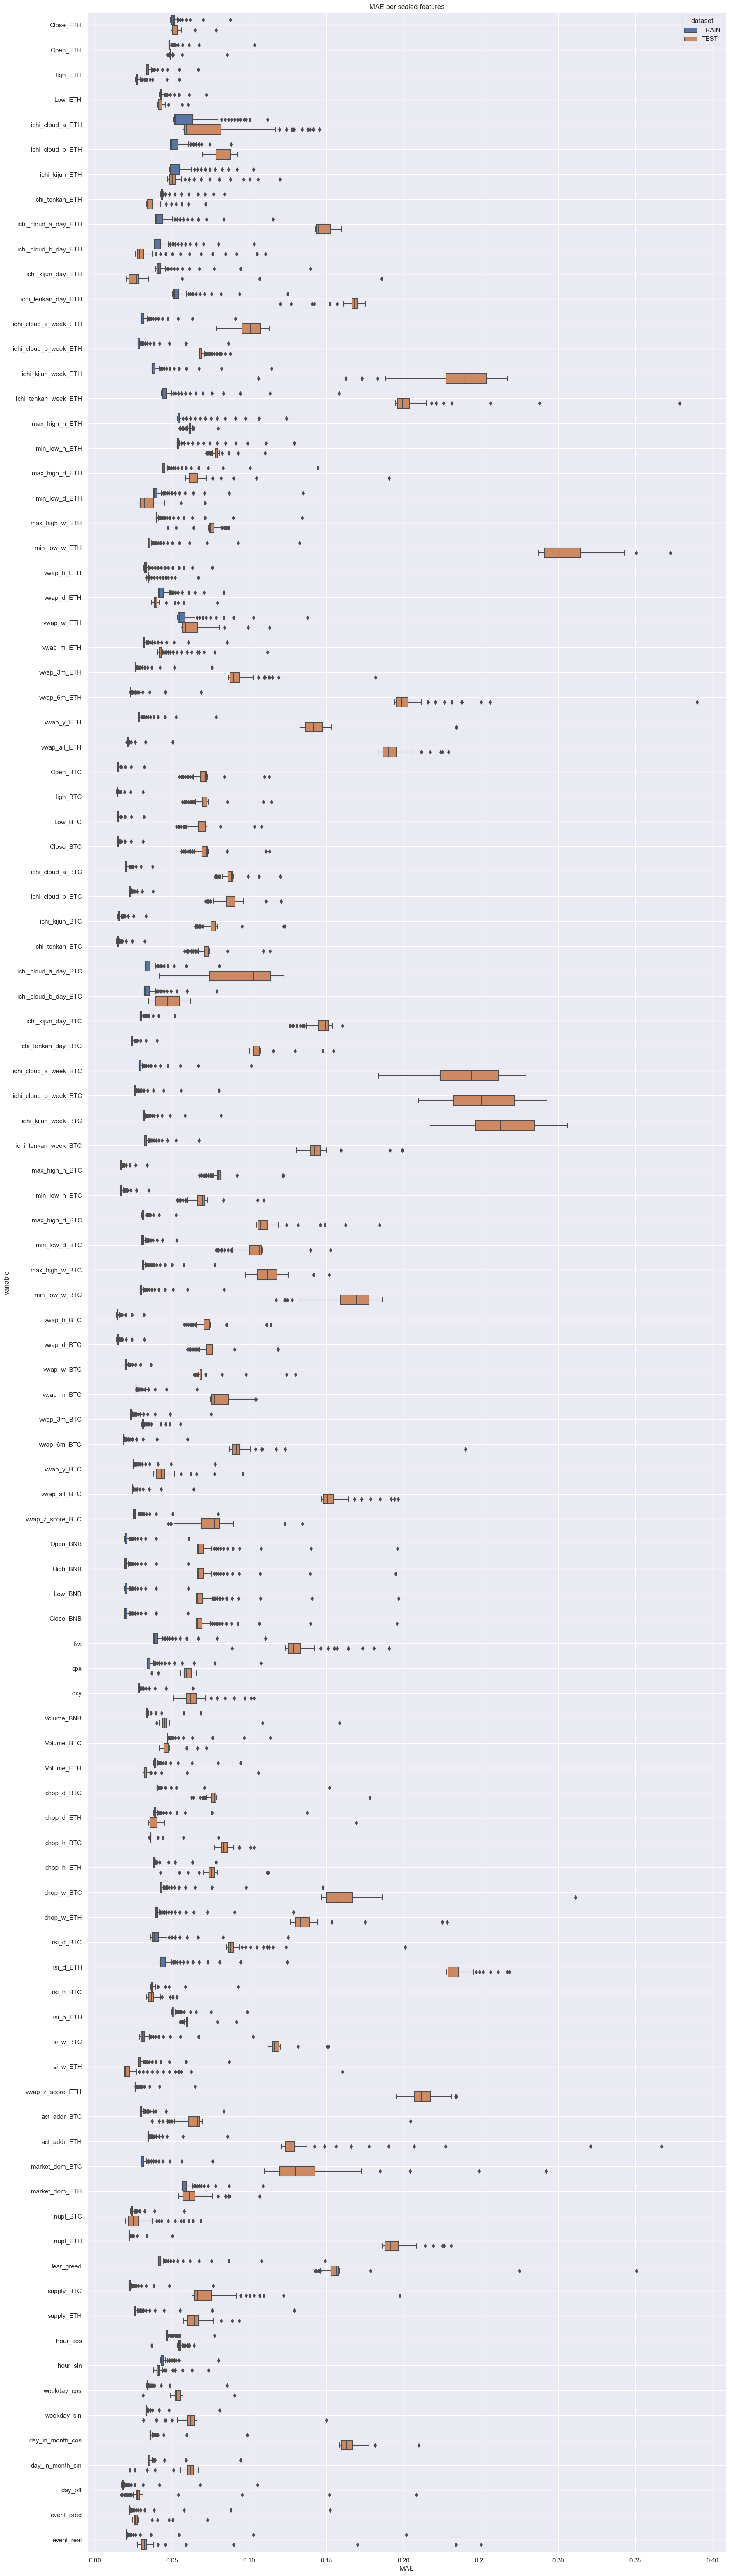

In [122]:
plt.figure(figsize=(20, 80))
sns.boxplot(data=df_comp, x="MAE", y="variable" , hue="dataset")
fig = plt.gcf()
ax = fig.gca()
ax.yaxis.grid(True)
#ax.set_xlim([-30,30])
plt.title("MAE per scaled features")

name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE_MAE - {name_plt}.jpg")
)

#### MSE  per features

In [123]:
# values per feat.
print(X_train_sca_pred.shape) 
print(X_train_sca.shape)
mse_ae_train = np.mean(np.square(X_train_sca_pred - X_train_sca), 0)
print(mse_ae_train.shape)
df_mse_ae_train = pd.DataFrame(mse_ae_train, columns=list_col_select)
df_mse_ae_train.index = [f"lag_{i_lag}" for i_lag in range(len(df_mse_ae_train.index))]

print(X_test_sca_pred.shape) 
print(X_test_sca.shape)
mse_ae_test = np.mean(np.square(X_test_sca_pred - X_test_sca), 0)
print(mse_ae_test.shape)
df_mse_ae_test = pd.DataFrame(mse_ae_test, columns=list_col_select)
df_mse_ae_test.index = [f"lag_{i_lag}" for i_lag in range(len(df_mse_ae_test.index))]

# mean per feat.
mse_ae_train_feat = np.mean(mse_ae_train, 0)[np.newaxis,:]
print(mse_ae_train_feat.shape)
df_mse_ae_train_feat = pd.DataFrame(mse_ae_train_feat, columns=list_col_select)

mse_ae_test_feat = np.mean(mse_ae_test, 0)[np.newaxis,:]
print(mse_ae_test_feat.shape)
df_mse_ae_test_feat = pd.DataFrame(mse_ae_test_feat, columns=list_col_select)

# comp train/test
df_mse_ae_test["dataset"] = "TEST"
df_mse_ae_train["dataset"] = "TRAIN"
df_mse_ae_comp = pd.concat([df_mse_ae_train, df_mse_ae_test], ignore_index=False)

df_mse_ae_test_feat["dataset"] = "TEST"
df_mse_ae_train_feat["dataset"] = "TRAIN"
df_mse_ae_comp_feat = pd.concat([df_mse_ae_train_feat, df_mse_ae_test_feat], ignore_index=False)

df_mse_ae_comp = df_mse_ae_comp.melt(id_vars=["dataset"], value_vars=list_col_select, value_name="MSE")



(89319, 72, 102)
(89319, 72, 102)
(72, 102)
(361, 72, 102)
(361, 72, 102)
(72, 102)
(1, 102)
(1, 102)


In [124]:
df_mse_ae_comp_feat

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0   0.006067  0.005781  0.003043  0.004516          0.007917   
0   0.004698  0.004003  0.001390  0.003011          0.010922   

   ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0          0.006024         0.00697         0.005123              0.003620   
0          0.010114         0.00611         0.002435              0.022847   

   ichi_cloud_b_day_ETH  ...  hour_cos  hour_sin  weekday_cos  weekday_sin  \
0              0.003448  ...  0.003555  0.003195     0.002752     0.002807   
0              0.002208  ...  0.004340  0.003042     0.005139     0.004538   

   day_in_month_cos  day_in_month_sin   day_off  event_pred  event_real  \
0          0.002375          0.002213  0.002075    0.003851    0.004981   
0          0.029525          0.004262  0.002153    0.001298    0.004108   

   dataset  
0    TRAIN  
0     TEST  

[2 rows x 103 columns]

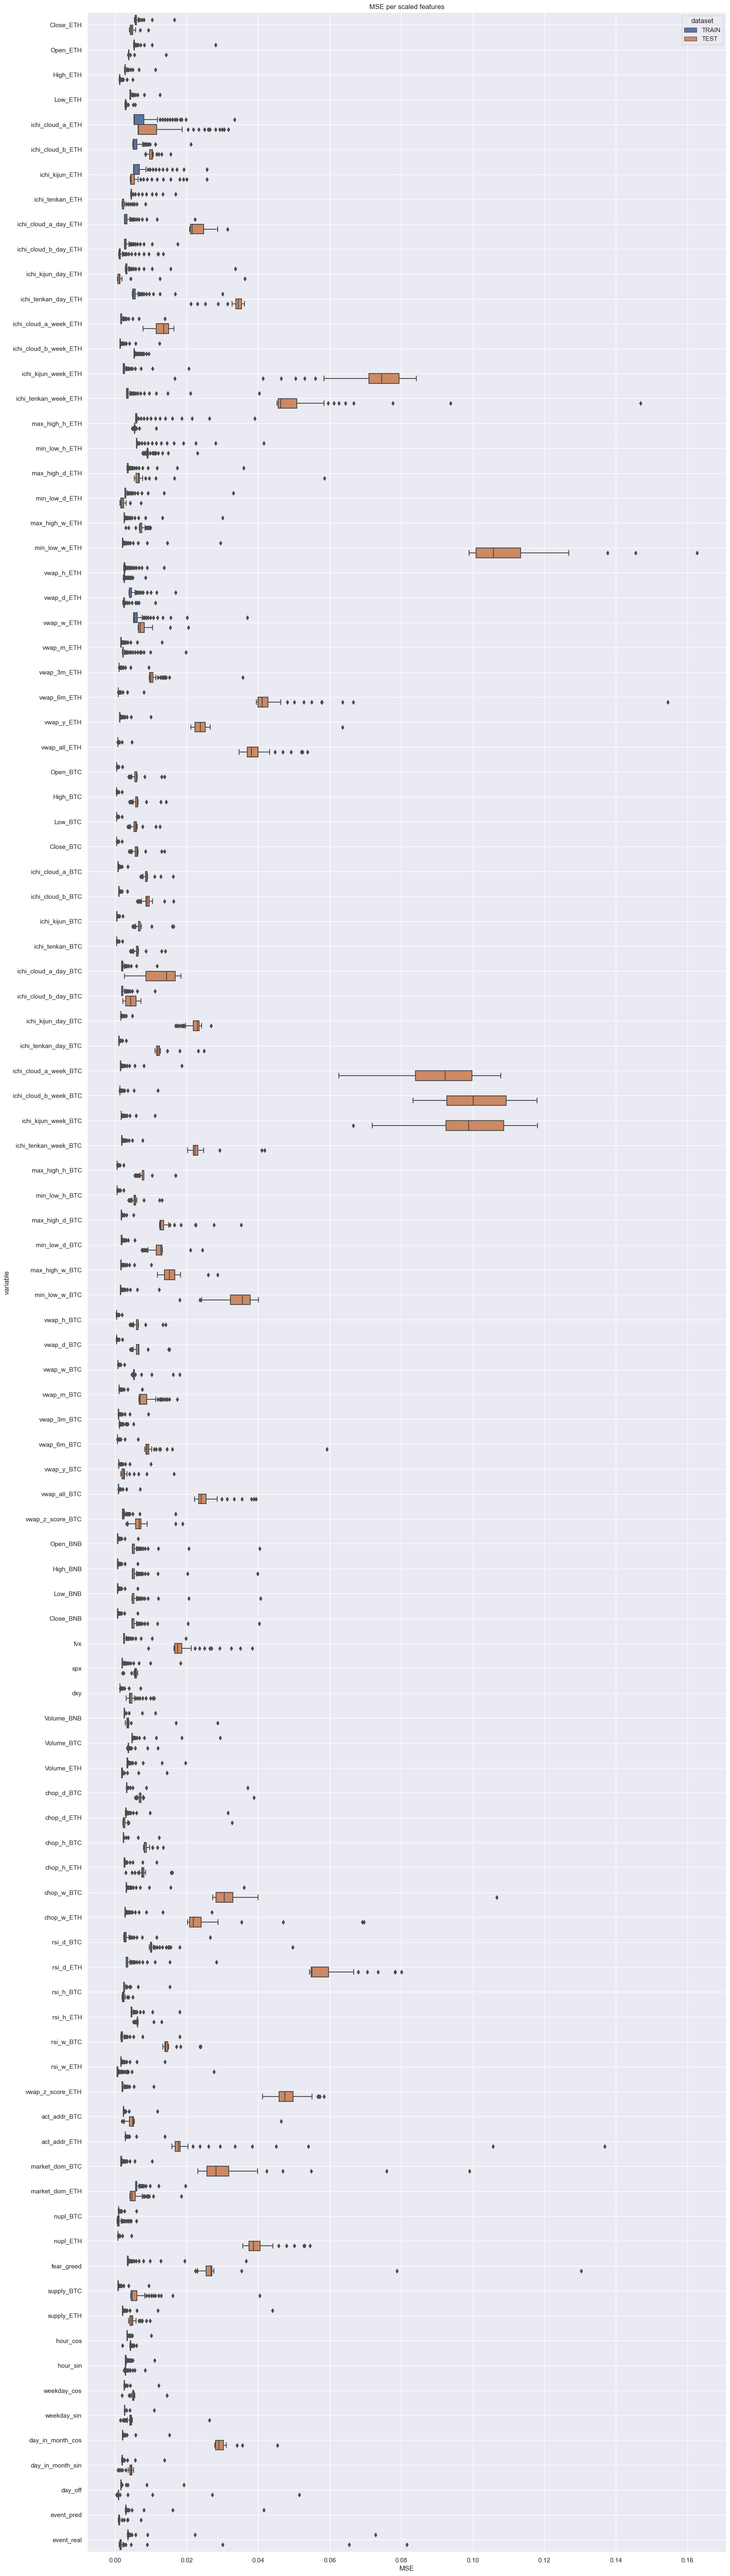

In [125]:
plt.figure(figsize=(20, 80))
sns.boxplot(data=df_mse_ae_comp, x="MSE", y="variable" , hue="dataset")
fig = plt.gcf()
ax = fig.gca()
ax.yaxis.grid(True)
#ax.set_xlim([-30,30])
plt.title("MSE per scaled features")

name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE_MSE - {name_plt}.jpg")
)

Text(0.5, 1.0, 'MSE per feature on TRAIN')

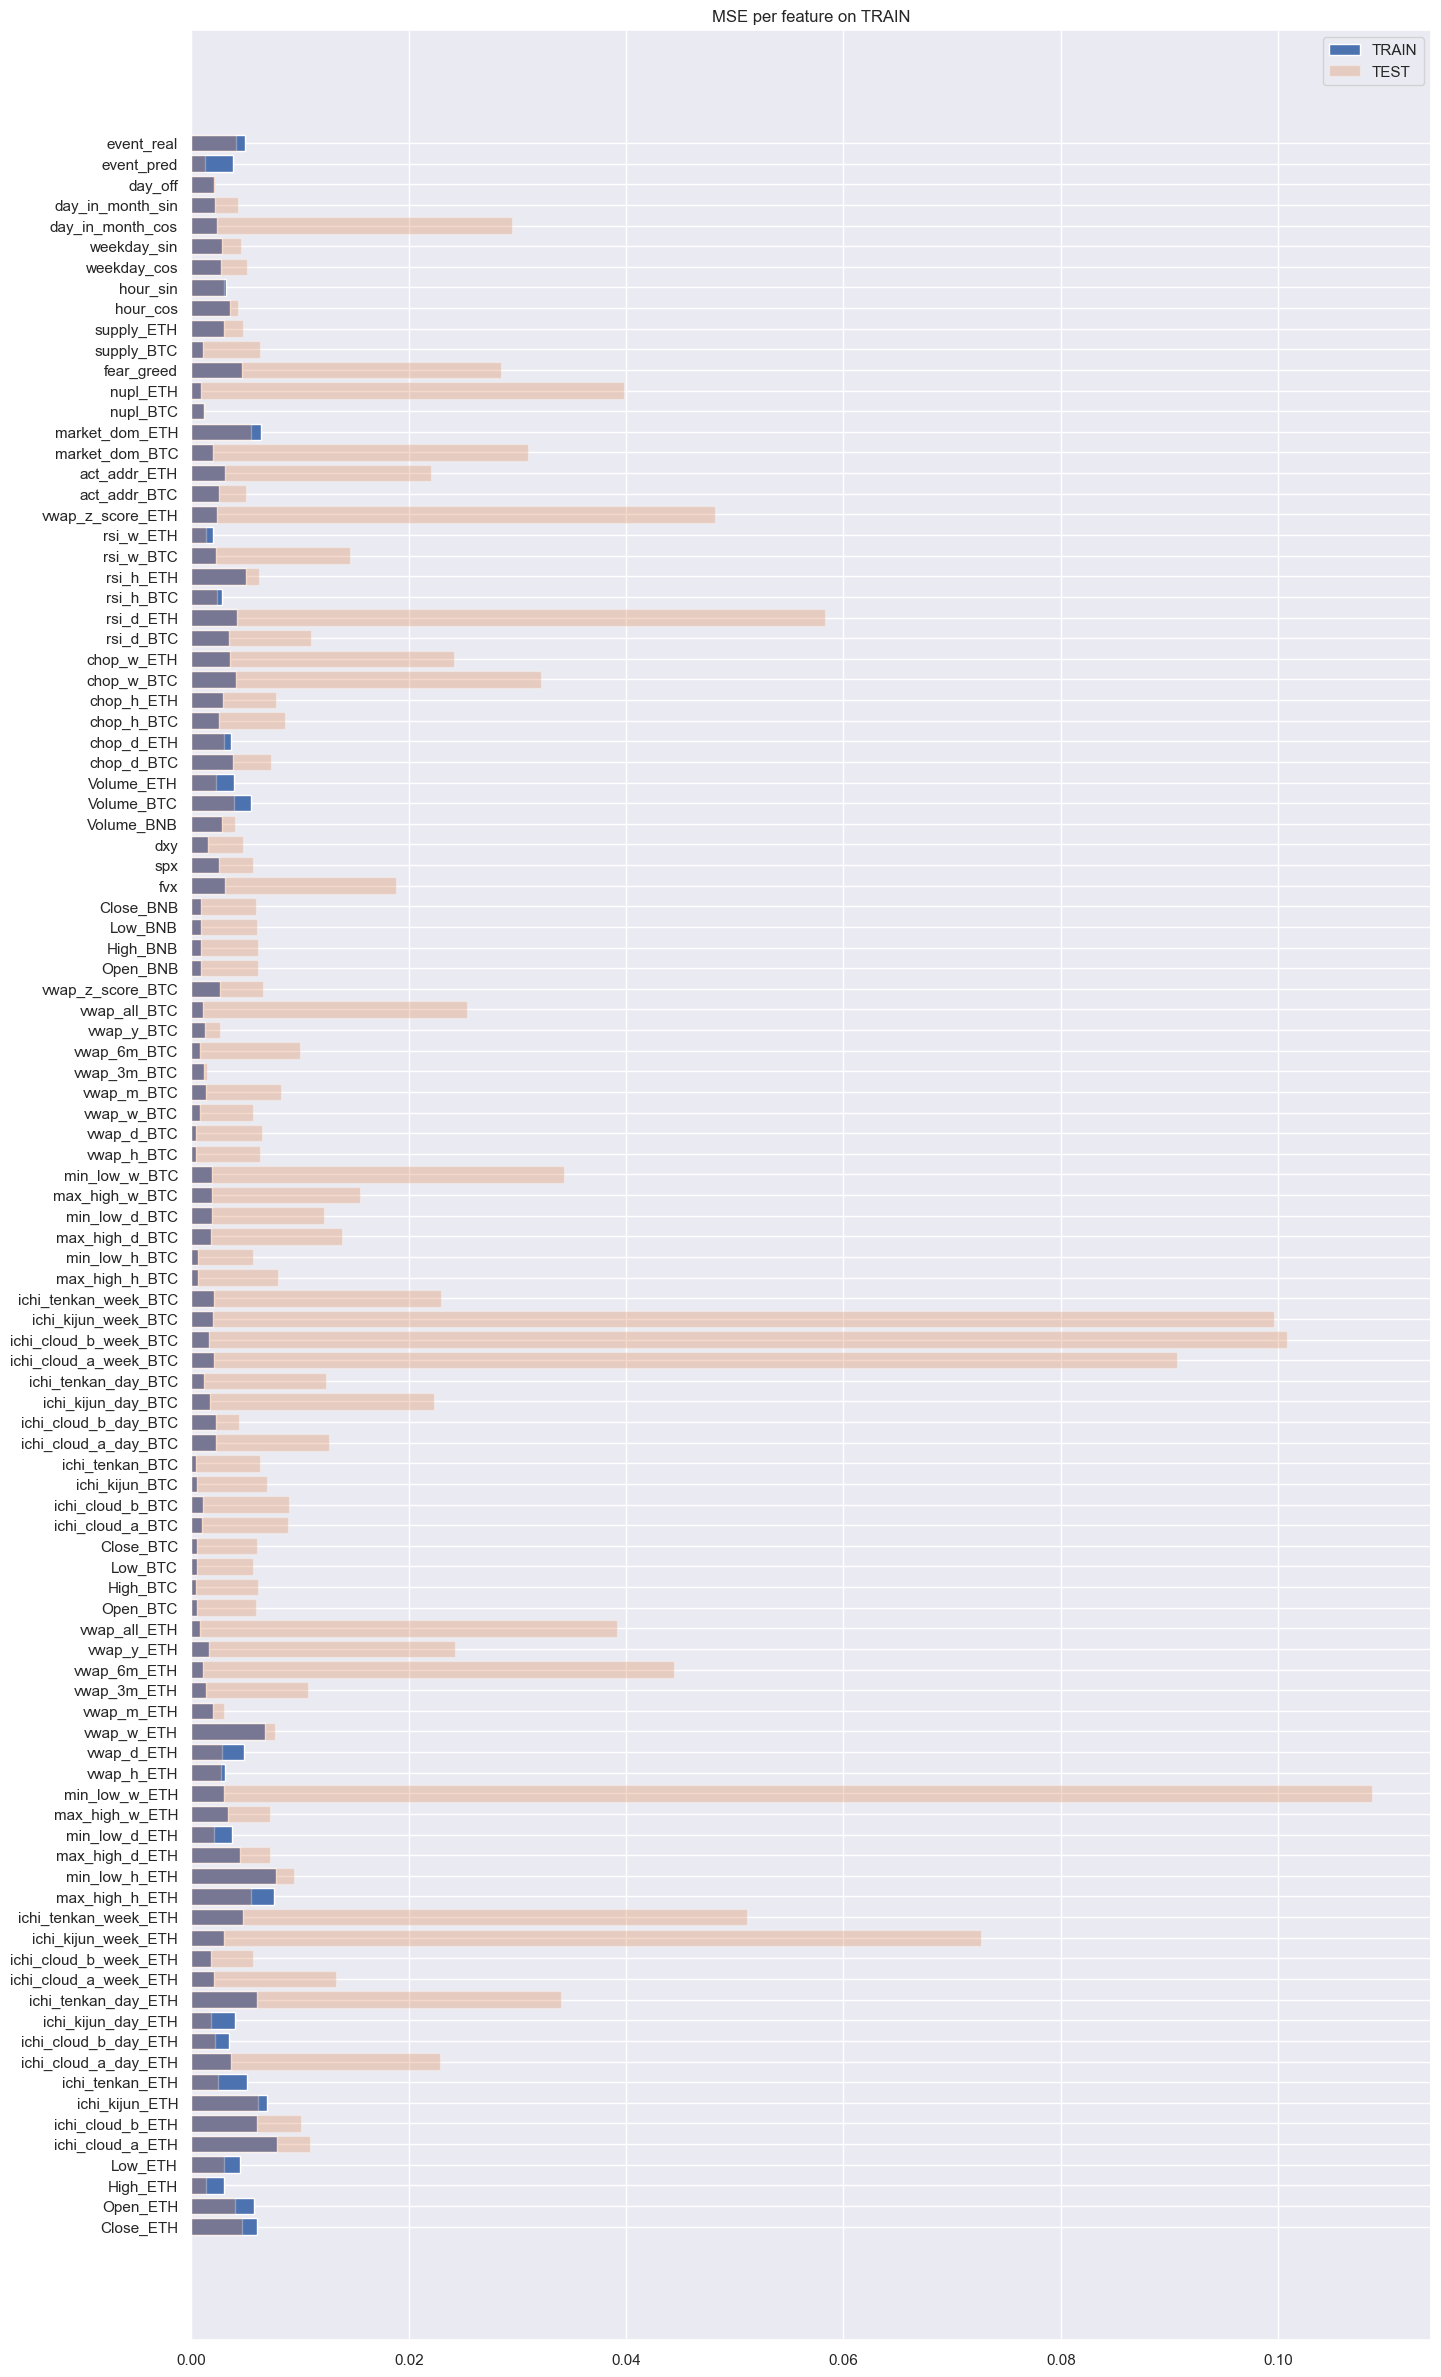

In [126]:
plt.figure(figsize=(16, 30))
plt.barh(list_col_select, df_mse_ae_train_feat.values[0,:-1], label="TRAIN")
plt.barh(list_col_select, df_mse_ae_test_feat.values[0,:-1], label="TEST", alpha=0.3)
plt.legend(loc='upper right')
#plt.barh(df_mse_ae_test_feat.columns, df_mse_ae_test_feat.values[0])
plt.title("MSE per feature on TRAIN")

In [127]:
encoder_model.layers[3].get_weights()

[array([[-0.04137256, -0.00548905, -0.09904756, ..., -0.09863117,
         -0.00297841,  0.13517226],
        [-0.15820561, -0.0559435 , -0.10510155, ..., -0.11053183,
         -0.13586602, -0.10055176],
        [ 0.1379209 , -0.07353617,  0.03712105, ...,  0.0713743 ,
         -0.01339093, -0.09412708],
        ...,
        [-0.07184765,  0.1987892 ,  0.1190377 , ..., -0.15069777,
          0.01994999,  0.11283348],
        [ 0.29454762,  0.19344588,  0.09032694, ..., -0.09903678,
          0.02005003, -0.12510811],
        [ 0.09845767,  0.18563855, -0.10503296, ..., -0.07264107,
         -0.17042778,  0.23134294]], dtype=float32),
 array([-0.06877355, -0.02153983,  0.02296232, -0.03878716, -0.02654185,
         0.01927162, -0.02776895,  0.00677217, -0.09182969,  0.1105286 ,
         0.02593095, -0.01379582, -0.00898091,  0.02066242, -0.03102663,
         0.0197037 ,  0.0438491 , -0.05052204,  0.01989262, -0.02072432,
        -0.09247657,  0.0241174 , -0.03034832, -0.01193617, -0.170

## Prediction Models

### LSTM all features

In [128]:
X_train_sca.shape

(89319, 72, 102)

In [129]:
X_train_sca.shape[-1]

102

In [130]:
X_train_sca.shape[-2:]

(72, 102)

In [131]:
# Init
#NB_TRY = 50
#STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)
if MODE_TRAIN_LSTM:
    EPOCHS = 5
    PATIENCE_PRED = 0
    dropout_rate = 0.05
    n_units = 128
    seed = 0
    tf.keras.backend.clear_session()
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    # optimizer def 
    optim = tf.optimizers.Adam()

    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                    verbose=1, patience=PATIENCE_PRED,
                                    restore_best_weights=True)
    # create model
    multi_step_model_1 = tf.keras.models.Sequential()
    multi_step_model_1.add(tf.keras.layers.LSTM(n_units, 
                        return_sequences=False,
                        input_shape=X_train_sca.shape[-2:],
                        dropout=dropout_rate))
    multi_step_model_1.add(tf.keras.layers.LayerNormalization())
    multi_step_model_1.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
    # compile
    multi_step_model_1.compile(optimizer=optim, loss='mse')
    # fitting
    if PATIENCE_PRED == 0:
        multi_step_history_1 = multi_step_model_1.fit(
            X_train_sca, y_train_sca, epochs=EPOCHS, 
            batch_size=BATCH_SIZE, 
            validation_data=(X_test_sca,y_test_sca), verbose=1
        )
    else:
        multi_step_history_1 = multi_step_model_1.fit(
            X_train_sca, y_train_sca, epochs=EPOCHS, 
            batch_size=BATCH_SIZE, 
            validation_data=(X_test_sca,y_test_sca), verbose=1, callbacks=[es])

    # eval
    mse_curr_1 = np.min(multi_step_history_1.history['val_loss'])
    print("mse_curr_1 = ", mse_curr_1)
    # plot mse
    plot_train_history(multi_step_history_1,
                        'Multi Step Training and validation loss', "data")
    # save mdl
    multi_step_model_1.save(path_mdl_predict_lstm)
    # results
    # _train_sca -> unscaler -> _train -> multiply by  Close price last lag
    y_train_pred_1 = multi_step_model_1.predict(X_train_sca)
    y_train_pred_unscaled_1 = scaler_y.inverse_transform(y_train_pred_1.reshape(-1,y_train_pred_1.shape[-1])).reshape(y_train_pred_1.shape)
    y_train_pred_raw_1 = y_train_pred_unscaled_1 * X_train_raw[:,-1, 0][:, np.newaxis]

    y_test_pred_1 = multi_step_model_1.predict(X_test_sca)
    y_test_pred_unscaled_1 = scaler_y.inverse_transform(y_test_pred_1.reshape(-1,y_test_pred_1.shape[-1])).reshape(y_test_pred_1.shape)
    y_test_pred_raw_1 = y_test_pred_unscaled_1 * X_test_raw[:,-1, 0][:, np.newaxis]
    # plot predict TRAIN
    fig = plt.figure(figsize=(16, 8))
    plt.title("LSTM Prediction on TRAIN data : Close Price at 6th lag")
    plt.plot(y_train_pred_raw_1[:1000, 5], label="pred")
    plt.plot(y_train_raw[:1000, 5], label="TRAIN")
    plt.legend(loc='upper right')
    # plot predict TRAIN
    fig = plt.figure(figsize=(16, 8))
    plt.title("LSTM Prediction on TEST data : Close Price at 6th lag")
    plt.plot(y_test_pred_raw_1[:1000, 5], label="pred")
    plt.plot(y_test_raw[:1000, 5], label="TEST")
    plt.legend(loc='upper right')


### Autoencoder + LSTM reduced features

In [132]:
encoder_model = tf.keras.models.load_model(path_mdl_encoder)
encoder_model.layers

Concatenate 

In [133]:
X_train_encoded = encoder_model.predict(X_train_sca)
X_train_encoded.shape

2792/2792 [==============================] - 32s 11ms/step


(89319, 72, 32)

In [134]:
X_test_encoded = encoder_model.predict(X_test_sca)
X_test_encoded.shape

12/12 [==============================] - 0s 18ms/step


(361, 72, 32)

In [135]:
if MODE_TRAIN_AE:
    scaler_enc = StandardScaler()
    X_train_encoded_sca = scaler_enc.fit_transform(
        X_train_encoded.reshape(
            -1, 
            X_train_encoded.shape[-1]
        )
    ).reshape(X_train_encoded.shape)

    X_test_encoded_sca = scaler_enc.transform(
        X_test_encoded.reshape(
            -1, 
            X_test_encoded.shape[-1]
        )
    ).reshape(X_test_encoded.shape)

    joblib.dump(scaler_enc, path_scaler_enc)
    
else:
    print("reloading scaler_enc...")
    scaler_enc = joblib.load(path_scaler_enc)
    X_train_encoded_sca = scaler_enc.transform(
        X_train_encoded.reshape(
            -1, 
            X_train_encoded.shape[-1]
        )
    ).reshape(X_train_encoded.shape)

    X_test_encoded_sca = scaler_enc.transform(
        X_test_encoded.reshape(
            -1, 
            X_test_encoded.shape[-1]
        )
    ).reshape(X_test_encoded.shape)    



reloading scaler_enc...


In [136]:
"""path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")
joblib.dump(scaler_enc, path_scaler_enc)
sc_enc = joblib.load(path_scaler_enc)
sc_enc.transform(
        X_train_encoded.reshape(
            -1, 
            X_train_encoded.shape[-1]
        )
    ).reshape(X_train_encoded.shape)"""

'path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")\njoblib.dump(scaler_enc, path_scaler_enc)\nsc_enc = joblib.load(path_scaler_enc)\nsc_enc.transform(\n        X_train_encoded.reshape(\n            -1, \n            X_train_encoded.shape[-1]\n        )\n    ).reshape(X_train_encoded.shape)'

In [137]:
"""# scale encoded data
scaler_enc = StandardScaler()
X_train_encoded_sca = scaler_enc.fit_transform(
    X_train_encoded.reshape(
        -1, 
        X_train_encoded.shape[-1]
    )
).reshape(X_train_encoded.shape)

X_test_encoded_sca = scaler_enc.transform(
    X_test_encoded.reshape(
        -1, 
        X_test_encoded.shape[-1]
    )
).reshape(X_test_encoded.shape)"""

'# scale encoded data\nscaler_enc = StandardScaler()\nX_train_encoded_sca = scaler_enc.fit_transform(\n    X_train_encoded.reshape(\n        -1, \n        X_train_encoded.shape[-1]\n    )\n).reshape(X_train_encoded.shape)\n\nX_test_encoded_sca = scaler_enc.transform(\n    X_test_encoded.reshape(\n        -1, \n        X_test_encoded.shape[-1]\n    )\n).reshape(X_test_encoded.shape)'

In [138]:
# _train_sca -> unscaler -> _train -> multiply by  Close price last lag
X_train_ = np.concatenate([X_train_sca[:,:,0:4], X_train_encoded_sca], axis=-1)
X_test_ = np.concatenate([X_test_sca[:,:,0:4], X_test_encoded_sca], axis=-1)

X_train_.shape, X_test_.shape

((89319, 72, 36), (361, 72, 36))

#### Correlations

In [139]:
list_col_enc =  [f"enc_{i_enc}" for i_enc in range(encoding_dim)]
list_col_ae = list_col_select[:4] + list_col_enc
nb_plot = len(list_col_ae)
list_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]
list_col_corr = list_col_ae + list_col_targets

list_corr = []
for i_lag in range(X_train_.shape[1]):

    df = pd.DataFrame(np.hstack((X_train_[:,i_lag,:], y_train)), 
        columns=list_col_corr)
    # Calculer la matrice de corrélation
    corr_matrix = df.corr()
    if len(list_corr) > 0:
        corr_matrix_min = list_corr[-1].combine(corr_matrix, np.minimum)
        corr_matrix_max = list_corr[-1].combine(corr_matrix, np.maximum)
    
    list_corr.append(corr_matrix)



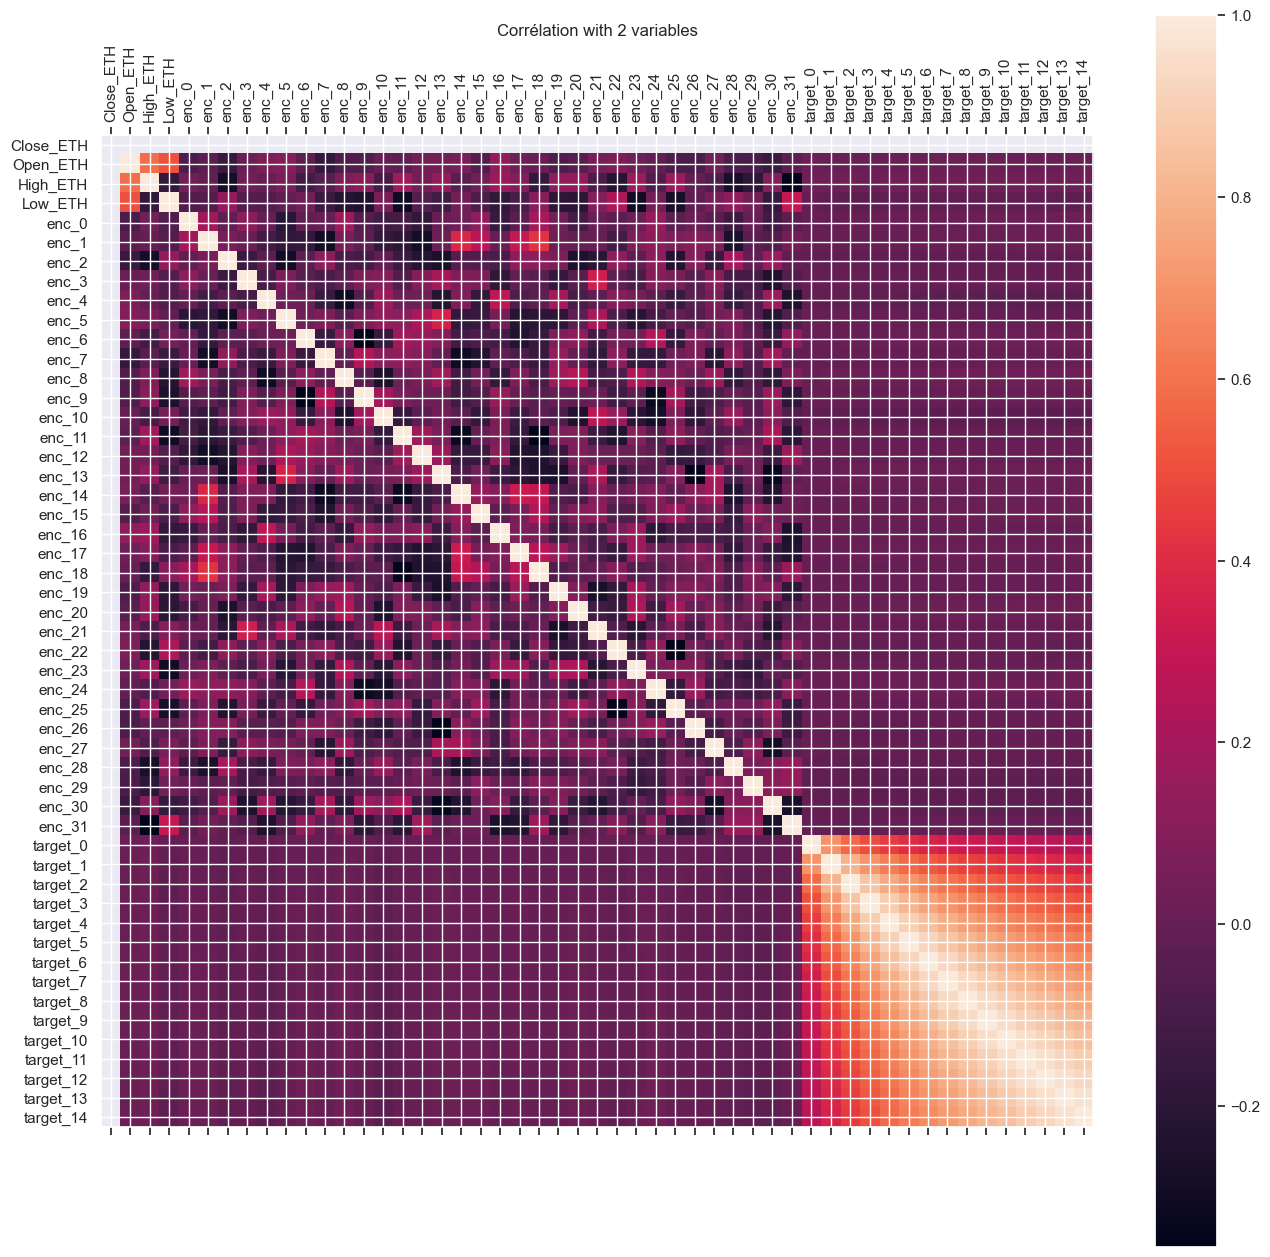

In [140]:
fig = plot_corr(corr_matrix_min)

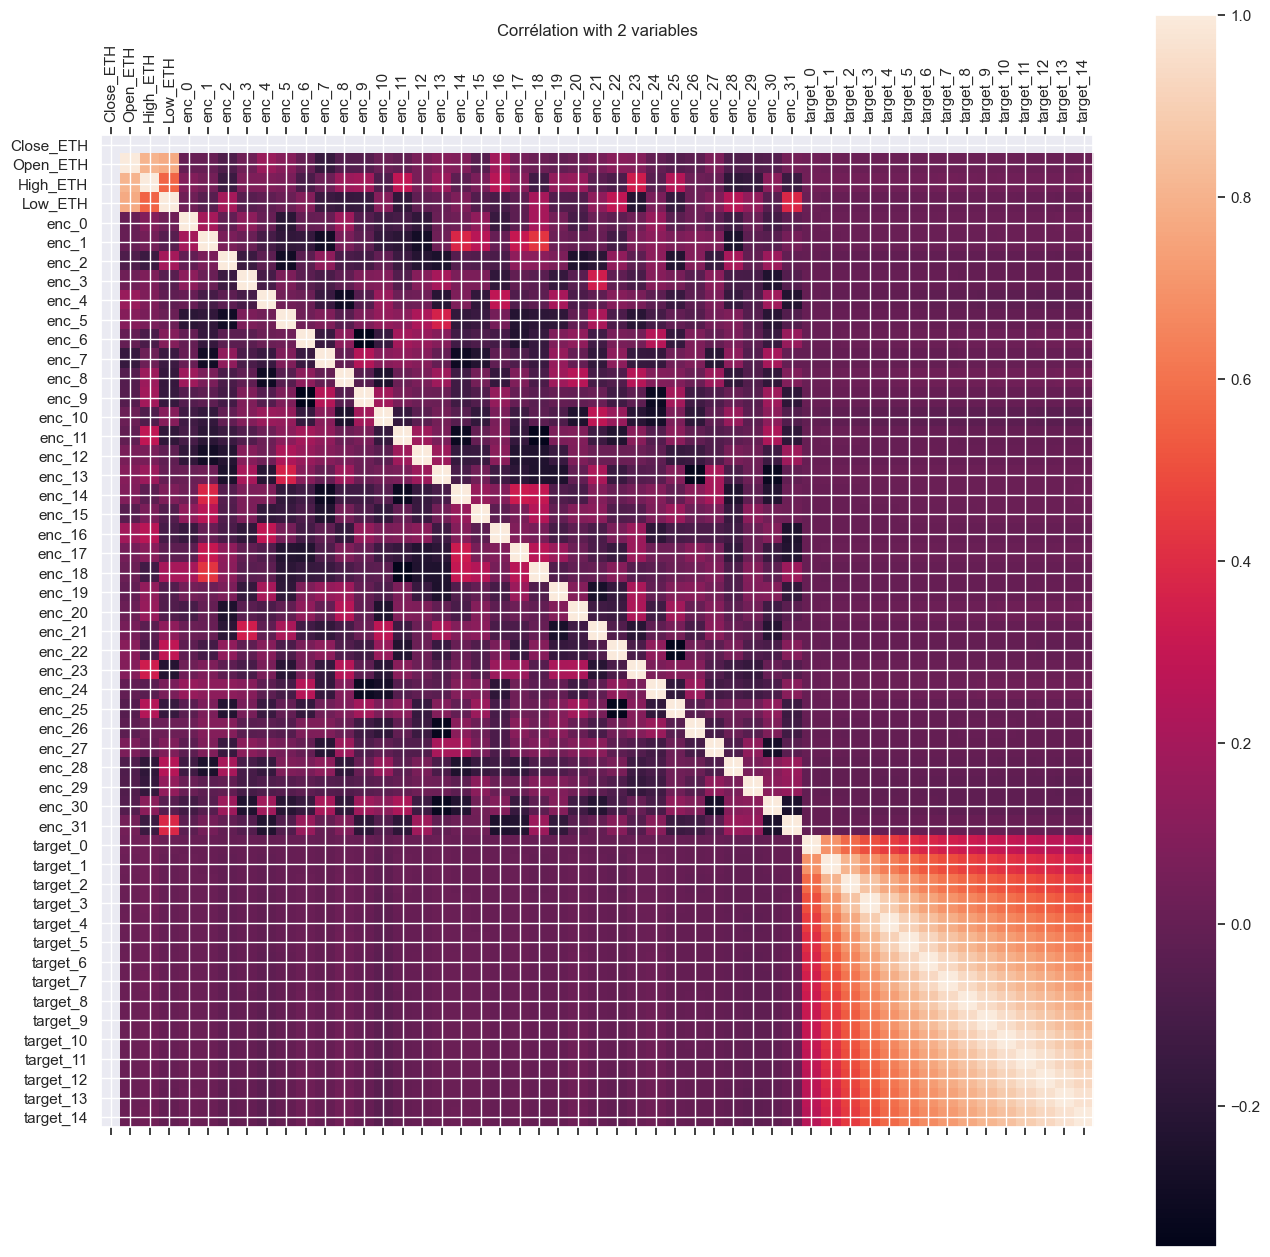

In [141]:
fig = plot_corr(corr_matrix_max) 

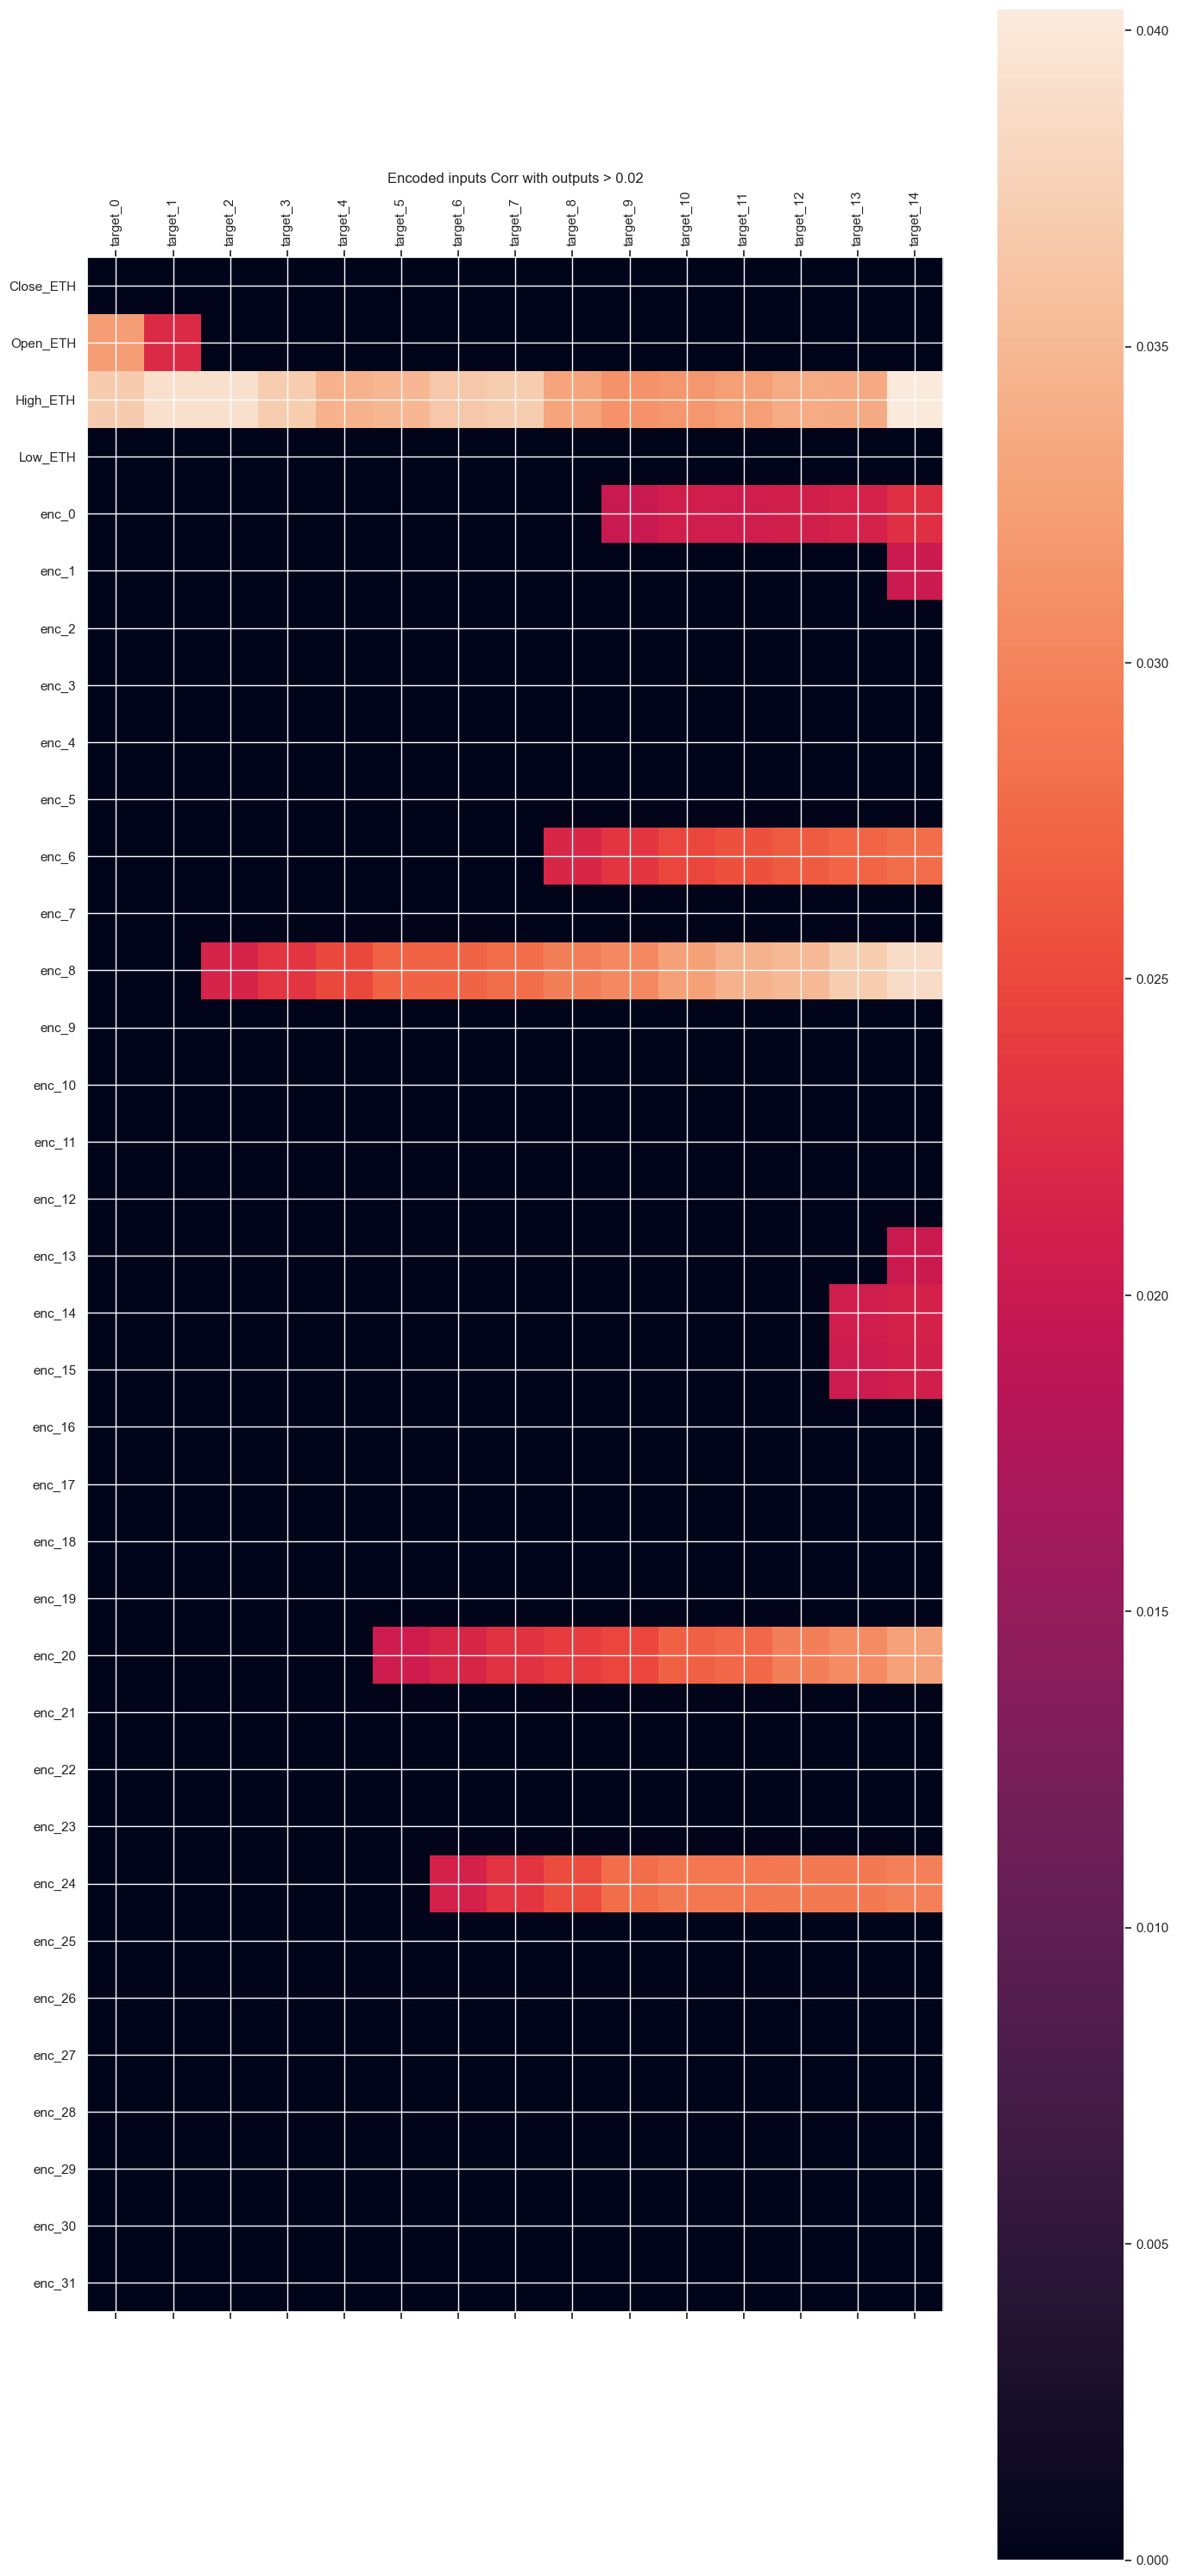

In [142]:
corr_matrix_targets_max = corr_matrix_max.copy().loc[list_col_ae, list_col_targets]
fig = plot_corr(corr_matrix_targets_max.where(corr_matrix_targets_max>0.02, 0), "Encoded inputs Corr with outputs > 0.02")

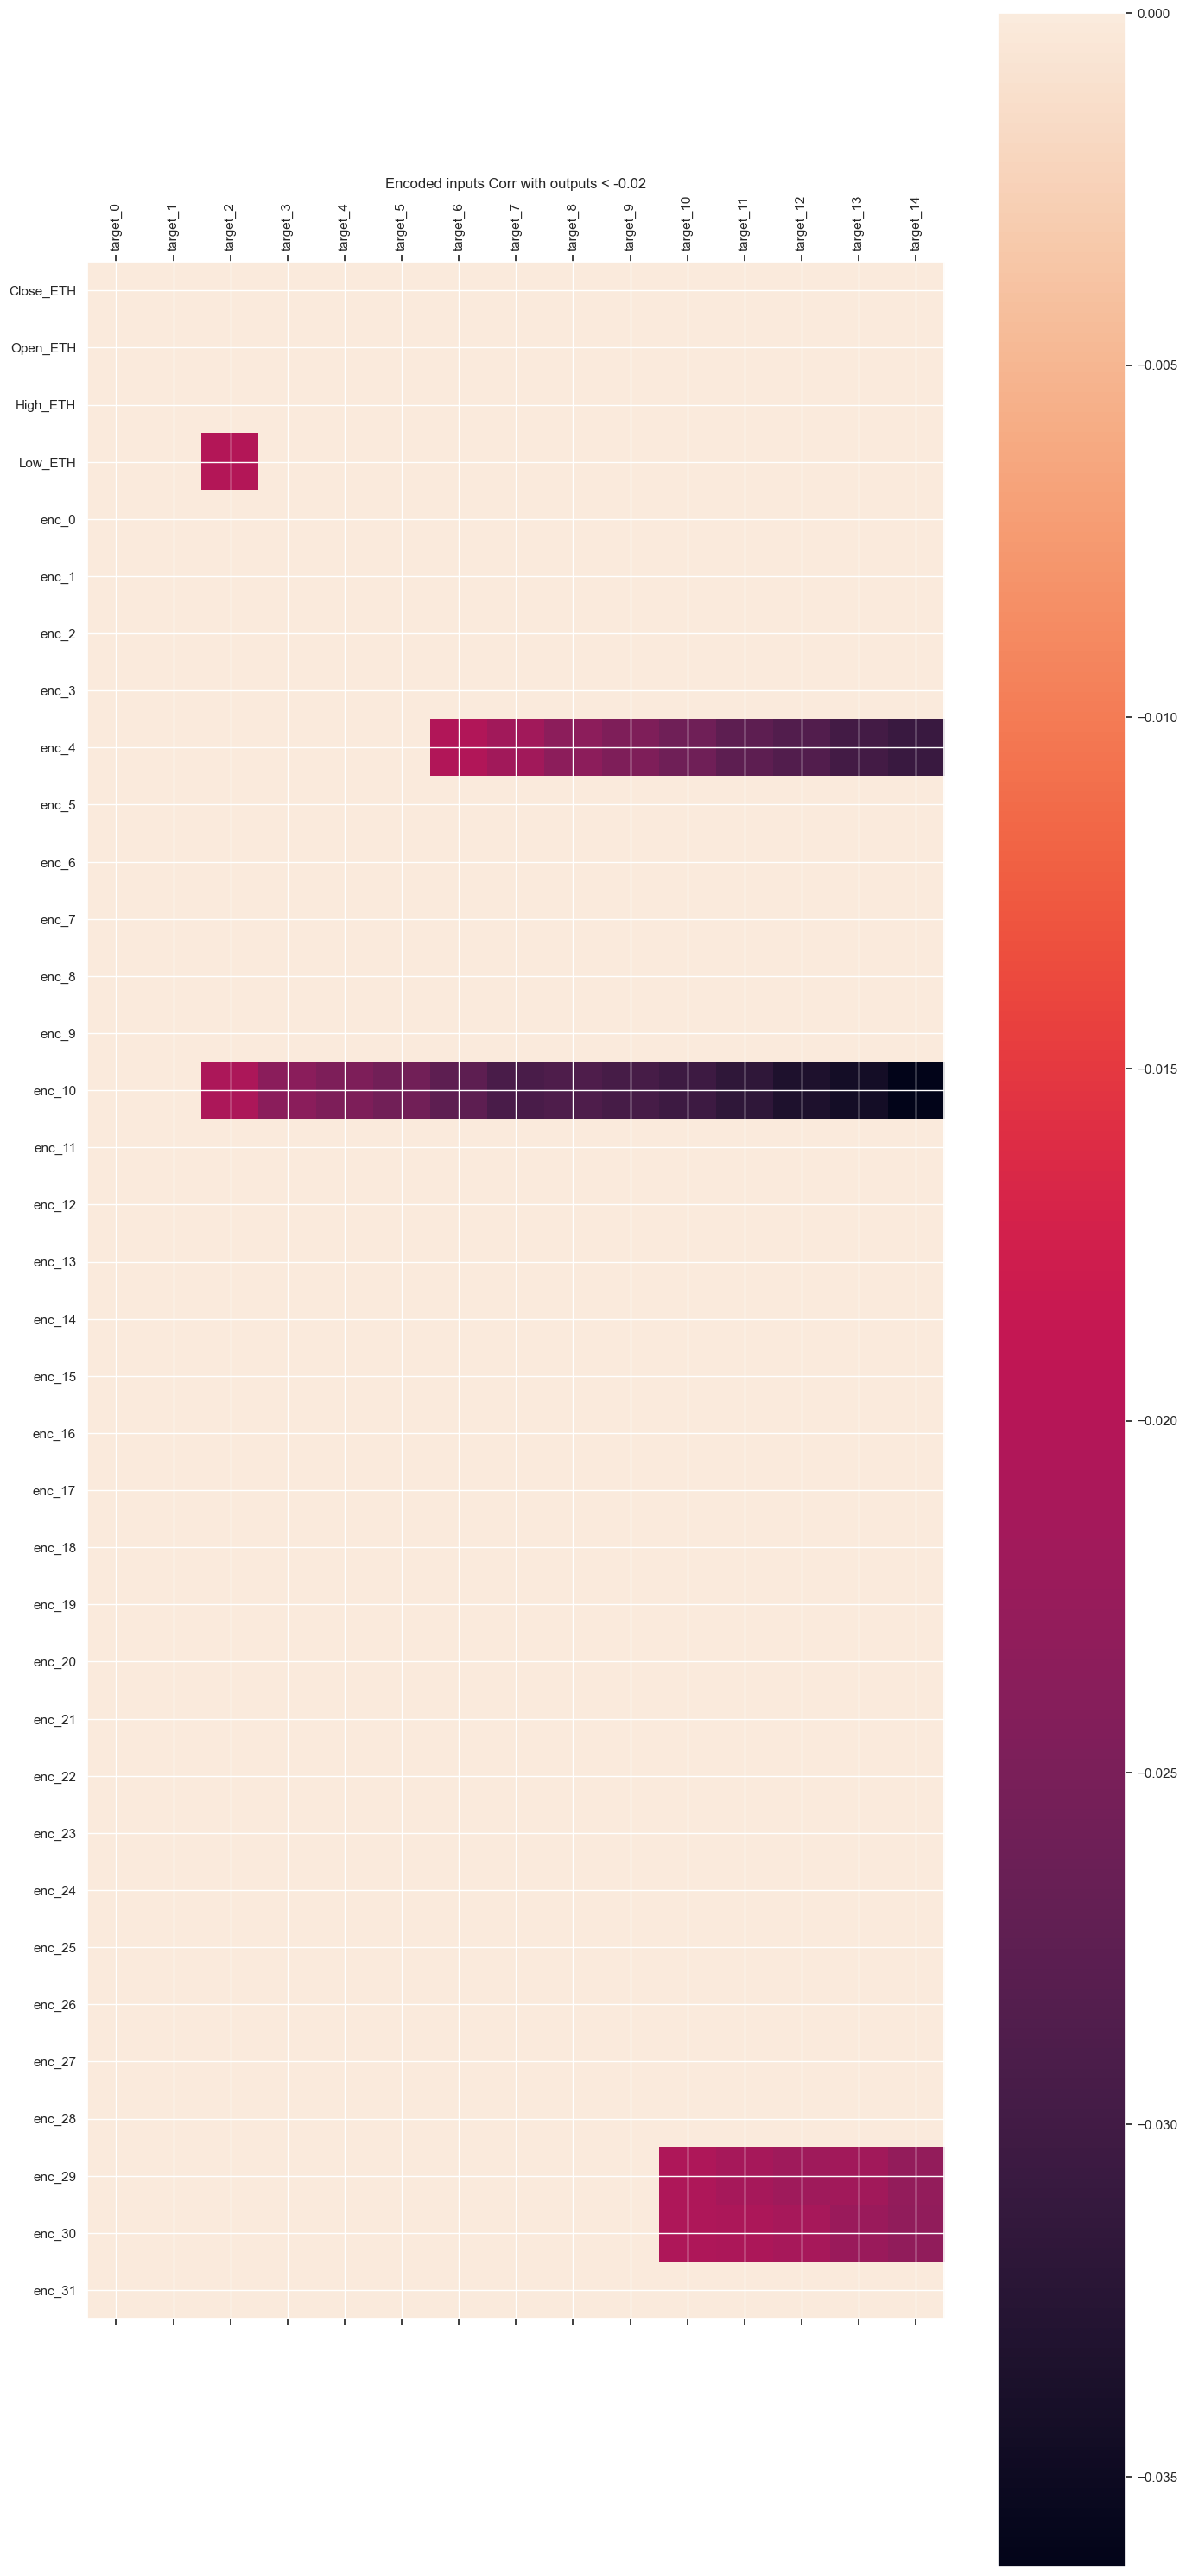

In [143]:
corr_matrix_targets_min = corr_matrix_min.copy().loc[list_col_ae, list_col_targets]
fig = plot_corr(corr_matrix_targets_min.where(corr_matrix_targets_min < -0.02, 0), "Encoded inputs Corr with outputs < -0.02")

In [144]:
"""list_col_enc =  [f"enc_{i_enc}" for i_enc in range(encoding_dim)]
list_col_ae = list_col_select[:4] + list_col_enc
nb_plot = len(list_col_ae)
list_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]
list_col_corr = list_col_ae + list_col_targets

# Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y
#df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train[:,0][:, np.newaxis])), 
#    columns=list_col_select[:nb_plot] + ['target'])
df = pd.DataFrame(np.hstack((X_train_[:,-1,:], y_train)), 
    columns=list_col_corr)
# Calculer la matrice de corrélation
corr_matrix = df.corr()

fig = plot_corr(corr_matrix)"""

'list_col_enc =  [f"enc_{i_enc}" for i_enc in range(encoding_dim)]\nlist_col_ae = list_col_select[:4] + list_col_enc\nnb_plot = len(list_col_ae)\nlist_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]\nlist_col_corr = list_col_ae + list_col_targets\n\n# Créer un DataFrame pandas à partir des données d\'entrée X et de la variable à prédire y\n#df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train[:,0][:, np.newaxis])), \n#    columns=list_col_select[:nb_plot] + [\'target\'])\ndf = pd.DataFrame(np.hstack((X_train_[:,-1,:], y_train)), \n    columns=list_col_corr)\n# Calculer la matrice de corrélation\ncorr_matrix = df.corr()\n\nfig = plot_corr(corr_matrix)'

In [145]:
"""corr_matrix_targets = corr_matrix.copy().loc[list_col_ae, list_col_targets]
fig = plot_corr(corr_matrix_targets.where(corr_matrix_targets>0.02, 0), "Encoded inputs Corr with outputs > 0.02")"""


'corr_matrix_targets = corr_matrix.copy().loc[list_col_ae, list_col_targets]\nfig = plot_corr(corr_matrix_targets.where(corr_matrix_targets>0.02, 0), "Encoded inputs Corr with outputs > 0.02")'

In [146]:
"""fig = plot_corr(
    corr_matrix_targets.where(corr_matrix_targets<-0.02, 0),
    "Encoded inputs Corr with outputs < -0.02",
)"""

'fig = plot_corr(\n    corr_matrix_targets.where(corr_matrix_targets<-0.02, 0),\n    "Encoded inputs Corr with outputs < -0.02",\n)'

#### Auto select features 

In [147]:
MODE_AUTO_SELECT

0

In [148]:
# select corr var [1, 2, 5, 7, 10, 11, 16, 19, 23, 24, 27, 28, 31]
def unique_list(list1):
    x = np.array(list1)
    return list(np.unique(x))

if MODE_AUTO_SELECT == 1:
    #list_col_enc_select = []
    list_i_enc_select = []
    for i_enc , col_enc in enumerate(list_col_enc):
        if (np.any(corr_matrix_targets_min.loc[col_enc].values <  -0.02) |
            np.any(corr_matrix_targets_max.loc[col_enc].values >  0.02)
            ):
            #list_col_enc_select.append(col_enc)
            list_i_enc_select.append(i_enc)
    list_i_enc_select = unique_list(list_i_enc_select)
    # save list
    save_list(list_i_enc_select, path_save_auto_select)

elif MODE_AUTO_SELECT == 2:
    list_i_enc_select = load_list(path_save_auto_select)
else:
    list_i_enc_select = list(range(X_train_encoded_sca.shape[-1]))


print(list_i_enc_select)
print("nb encoded features: ", len(list_i_enc_select))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
nb encoded features:  32


In [149]:
X_train_.shape

(89319, 72, 36)

In [150]:
np.array(list(range(4)) + list(4+ np.array(list_i_enc_select)))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35])

In [151]:
X_train_ = X_train_[:,:, np.array(list(range(4)) + list(4 + np.array(list_i_enc_select)))]
X_test_ = X_test_[:,:, np.array(list(range(4)) + list(4 + np.array(list_i_enc_select)))]

In [152]:
X_train_.shape

(89319, 72, 36)

#### Train

In [153]:
#NB_TRY = 50
#STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)

#dropout_rate = 0.25#0.1
#n_units = 128#32
#reg = L1L2(l1=0.0001, l2=0.0001)

mse_curr_min = None
if MODE_TRAIN_PREDICTOR:
    for n_units in LIST_UNITS_PRED: #[32, 64, 128]: #[128]: #
        for dropout_rate in  LIST_DROPOUT_PRED: #[0.05, 0.15, 0.25]: #[0.1]:
            for seed in LIST_SEEDS:
                tf.keras.backend.clear_session()
                np.random.seed(seed)
                random.seed(seed)
                tf.random.set_seed(seed)
                optim = tf.keras.optimizers.legacy.Adam()
                #optim = tf.keras.optimizers.AdamW()
                if PATIENCE_PRED is not None:
                    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                                    verbose=1, patience=PATIENCE_PRED,
                                                    restore_best_weights=True)
                # create model
                multi_step_model = tf.keras.models.Sequential()
                multi_step_model.add(
                    tf.keras.layers.LSTM(
                        n_units,
                        return_sequences=False,
                        input_shape=X_train_.shape[-2:],
                        #kernel_regularizer=reg,
                        #bias_regularizer=reg,
                    )
                )
                multi_step_model.add(tf.keras.layers.LayerNormalization())
                multi_step_model.add(tf.keras.layers.Dropout(dropout_rate))
                #multi_step_model.add(tf.keras.layers.BatchNormalization())
                multi_step_model.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
                # compile
                multi_step_model.compile(optimizer=optim, loss='mse')
                # fitting
                if PATIENCE_PRED == 0:
                    multi_step_history = multi_step_model.fit(
                        X_train_, y_train_sca, epochs=EPOCHS_PRED,
                        batch_size=BATCH_SIZE, 
                        validation_data=(X_test_, y_test_sca), 
                        verbose=1,
                    )
                else:
                    multi_step_history = multi_step_model.fit(
                        X_train_, y_train_sca, epochs=EPOCHS_PRED,
                        batch_size=BATCH_SIZE, 
                        validation_data=(X_test_, y_test_sca), 
                        verbose=1, 
                        callbacks=[es],
                    )
                # eval
                if PATIENCE_PRED !=0:
                    # mode min val loss
                    i_epoch = np.argmin(multi_step_history.history['val_loss'])
                    mse_curr_train = multi_step_history.history['loss'][i_epoch]
                    mse_curr = multi_step_history.history['val_loss'][i_epoch]
                else:
                    # mode last
                    mse_curr_train = multi_step_history.history['loss'][-1]
                    mse_curr = multi_step_history.history['val_loss'][-1]

                print("MSE TRAIN : ", mse_curr_train)
                print("MSE TEST : ", mse_curr)
                    
                # plot MSE
                name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
                plot_train_history(
                    multi_step_history,
                    f"AE_LSTM MSE - units {n_units} - drop {dropout_rate} -\n AE {name_plt} \n MSE_TEST={mse_curr:2f}",
                    saveFolder="data",
                )

                # save the best
                if mse_curr_min == None:
                    mse_curr_min = mse_curr
                    n_units_min = n_units
                    dropout_rate_min = dropout_rate

                    print("Save model: ", path_mdl_predict_autoenc_lstm)
                    multi_step_model.save(path_mdl_predict_autoenc_lstm)
                else:
                    if mse_curr < mse_curr_min:
                        mse_curr_min = mse_curr
                        n_units_min = n_units
                        dropout_rate_min = dropout_rate
                        print("Save model: ", path_mdl_predict_autoenc_lstm)
                        multi_step_model.save(path_mdl_predict_autoenc_lstm)
    
    n_units = n_units_min#32
    dropout_rate = dropout_rate_min #0.25
    mse_curr = mse_curr_min

    
print("Load model: ", path_mdl_predict_autoenc_lstm)
multi_step_model = tf.keras.models.load_model(path_mdl_predict_autoenc_lstm)
n_units = multi_step_model.layers[0].units#32
dropout_rate = multi_step_model.layers[2].rate#0.25
print(f"Best model: n_units={n_units} / dropout= {dropout_rate}")
print(multi_step_model.summary())

Load model:  data/mdl_predict_autoenc_lstm
Best model: n_units=512 / dropout= 0.2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 512)               1124352   
                                                                 
 layer_normalization (Layer  (None, 512)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 15)                7695      
                                                                 
Total params: 1133071 (4.32 MB)
Trainable params: 1133071 (4.32 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
No

In [154]:
print(f"Best model: n_units={n_units} / dropout= {dropout_rate}")

Best model: n_units=512 / dropout= 0.2


In [155]:
np.min(y_train)

0.8990060972444147

In [156]:
np.max(y_train)

1.087790104524251

#### Results

##### Save mdl

In [157]:
X_train_.shape

(89319, 72, 36)

##### Predict

In [158]:
# _train_sca -> unscaler -> _train -> multiply by  Close price last lag
# predict
y_train_pred = multi_step_model.predict(X_train_)
# unscale
#y_train_pred_unscaled = scaler_y.inverse_transform(y_train_pred.reshape(-1,y_train_pred.shape[-1])).reshape(y_train_pred.shape)
y_train_pred_unscaled = scaler_y.inverse_transform(
    y_train_pred.ravel().reshape(-1, 1)).reshape(y_train_pred.shape)
#  multiply by  Close price last lag
y_train_pred_raw = y_train_pred_unscaled * X_train_raw[:,-1, 0][:, np.newaxis]
# predict
y_test_pred = multi_step_model.predict(X_test_)
# unscale
y_test_pred_unscaled = scaler_y.inverse_transform(
    y_test_pred.ravel().reshape(-1, 1)).reshape(y_test_pred.shape)
#  multiply by  Close price last lag
y_test_pred_raw = y_test_pred_unscaled * X_test_raw[:,-1, 0][:, np.newaxis]

12/12 [==============================] - 1s 42ms/step


##### Plots

In [159]:
print(y_train_raw[0::FUTURE_TARGET,:].ravel().shape)
print(y_train_pred_raw[0::FUTURE_TARGET,:].ravel().shape)

(89325,)
(89325,)


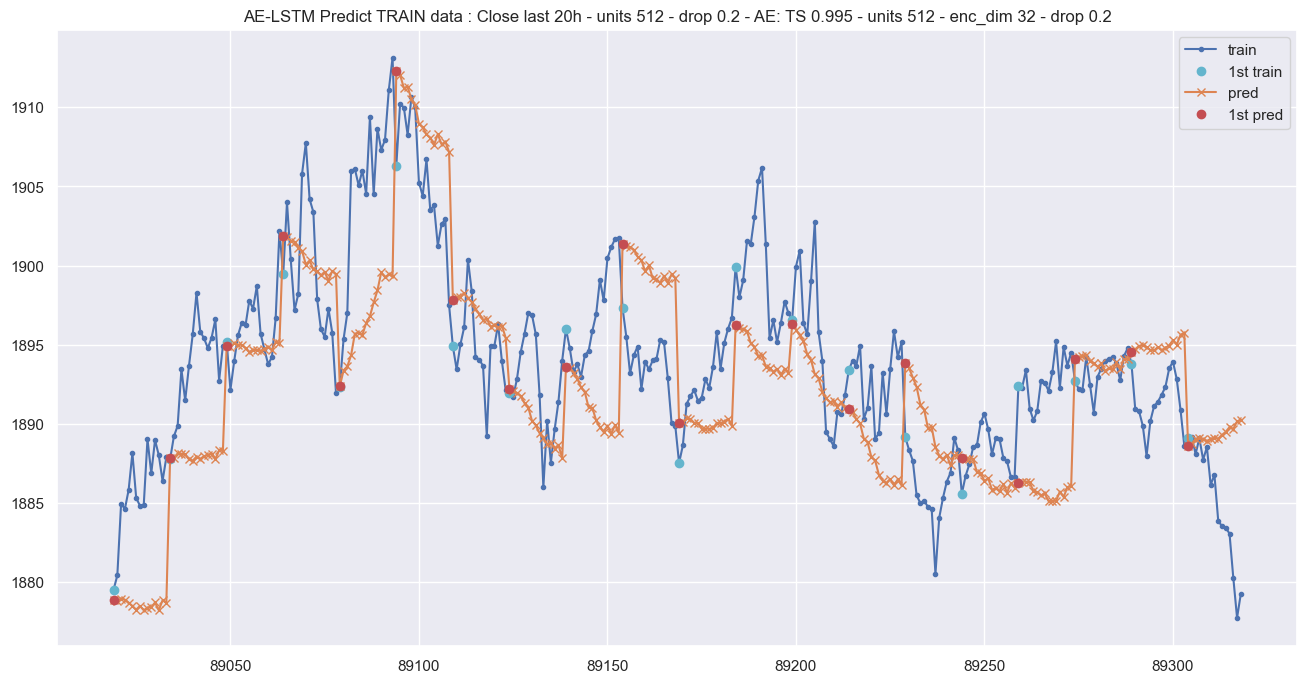

In [160]:
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
fig = plt.figure(figsize=(16, 8))
plt.title(f"AE-LSTM Predict TRAIN data : Close last 20h - units {n_units} - drop {dropout_rate} - AE: {name_plt}")
nb_pred = 20
nb_points = nb_pred*FUTURE_TARGET

x_axis = np.array(range(y_train_raw.shape[0]))
x_axis_1 =  np.flip(np.array(range(y_train_raw.shape[0]-FUTURE_TARGET,0, -FUTURE_TARGET)))
y_train_raw_1 = y_train_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
y_train_pred_raw_1 = y_train_pred_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
plt.plot(x_axis[-nb_points:], y_train_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], '.-', label="train")
plt.plot(x_axis_1[-nb_pred:], y_train_raw_1[-nb_pred:], 'oc', label ='1st train')
plt.plot(x_axis[-nb_points:], y_train_pred_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], 'x-', label="pred")
plt.plot(x_axis_1[-nb_pred:], y_train_pred_raw_1[-nb_pred:], 'or', label ='1st pred')
plt.legend(loc='upper right')
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE pred TRAIN - units {n_units} - drop {dropout_rate} - AE {name_plt}.jpg")
)

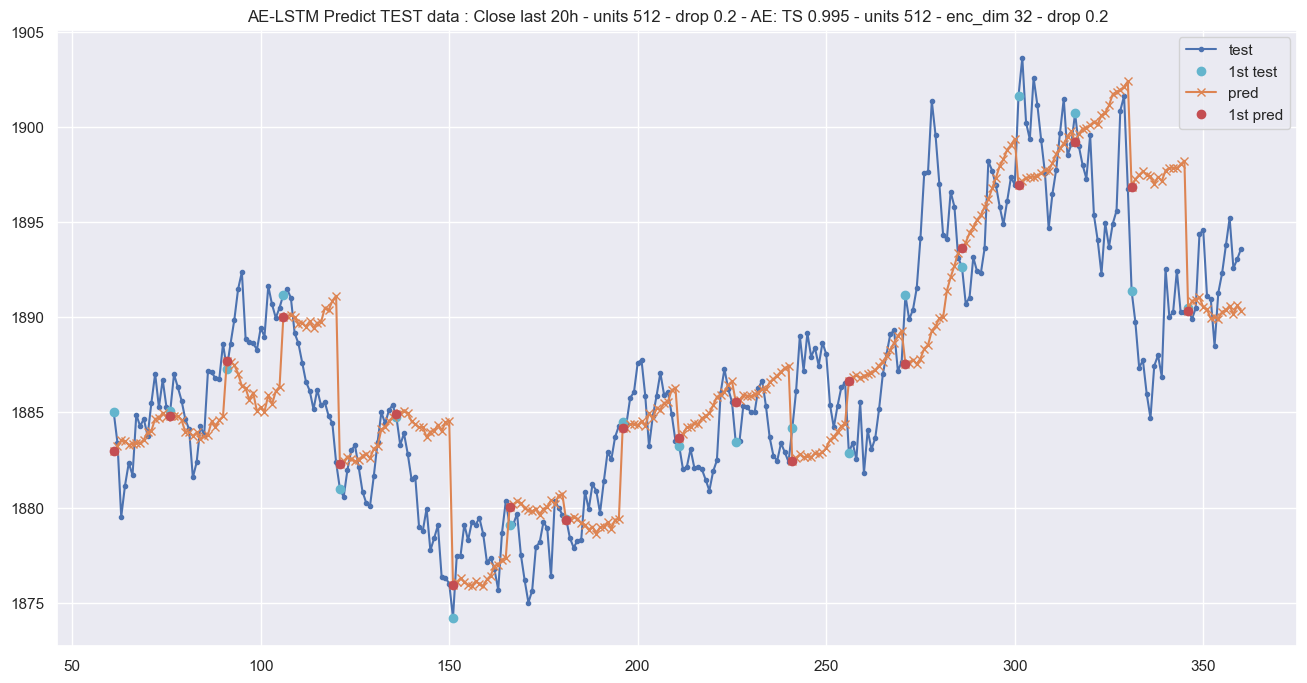

In [161]:
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
fig = plt.figure(figsize=(16, 8))
plt.title(f"AE-LSTM Predict TEST data : Close last 20h - units {n_units} - drop {dropout_rate} - AE: {name_plt}")
nb_pred = 20
nb_points = nb_pred*FUTURE_TARGET

x_axis = np.array(range(y_test_raw.shape[0]))
x_axis_1 =  np.flip(np.array(range(y_test_raw.shape[0]-FUTURE_TARGET,0, -FUTURE_TARGET)))
y_test_raw_1 = y_test_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
y_test_pred_raw_1 = y_test_pred_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
plt.plot(x_axis[-nb_points:], y_test_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], '.-', label="test")
plt.plot(x_axis_1[-nb_pred:], y_test_raw_1[-nb_pred:], 'oc', label ='1st test')
plt.plot(x_axis[-nb_points:], y_test_pred_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], 'x-', label="pred")
plt.plot(x_axis_1[-nb_pred:], y_test_pred_raw_1[-nb_pred:], 'or', label ='1st pred')
plt.legend(loc='upper right')
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE pred TEST - units {n_units} - drop {dropout_rate} - AE {name_plt}.jpg")
)

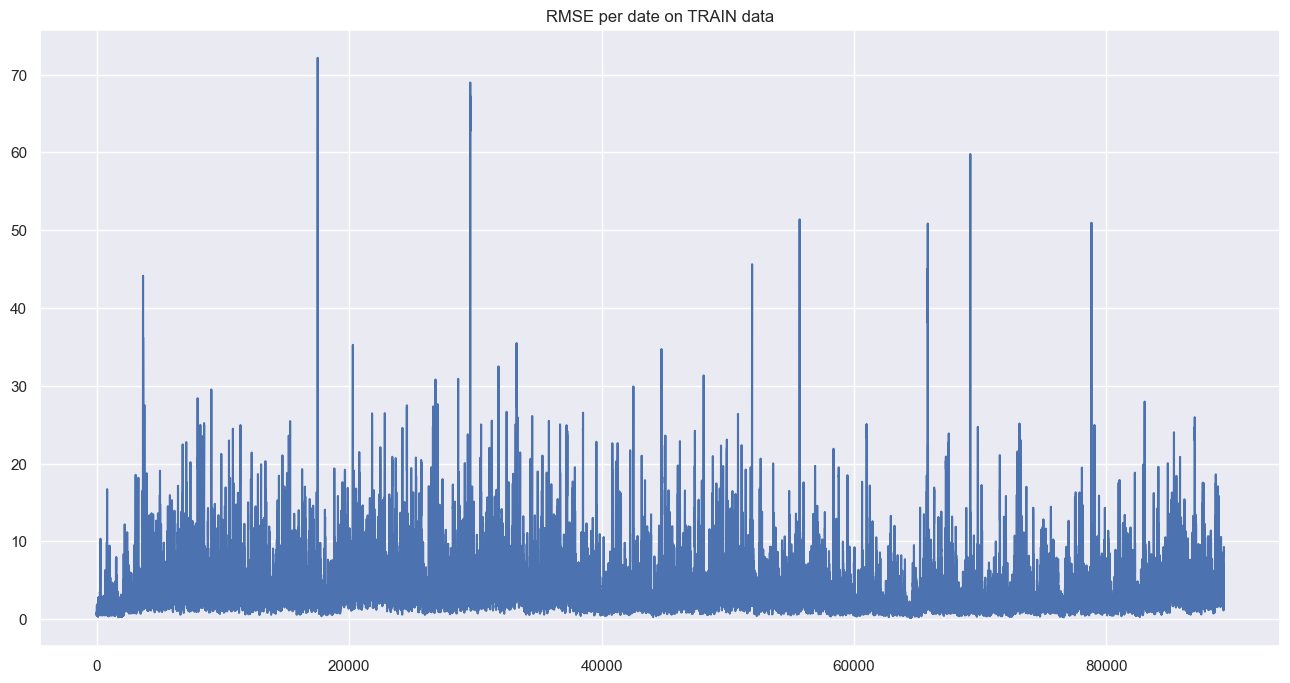

In [162]:
arr_mse_train = np.zeros((y_train_raw.shape[0]))
for i_date in range(y_train_raw.shape[0]):
    arr_mse_train[i_date] = mean_squared_error(
        y_train_raw[i_date], 
        y_train_pred_raw[i_date], 
        squared=False,
    )
fig = plt.figure(figsize=(16, 8))
plt.title("RMSE per date on TRAIN data")
plt.plot(arr_mse_train, label="mse")

Text(0.5, 1.0, 'Distrib. RMSE on TRAIN')

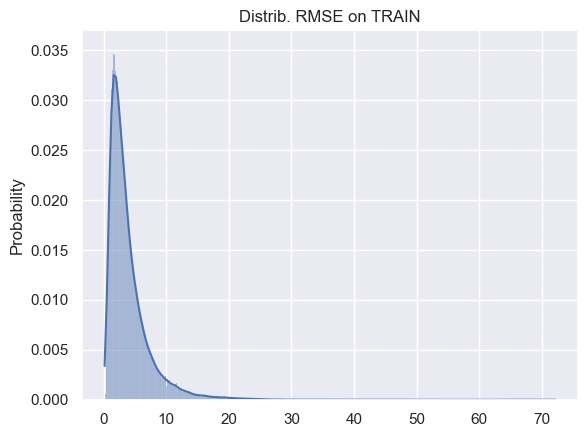

In [163]:
sns.histplot(x=arr_mse_train, stat="probability", kde=True)
fig = plt.gcf()
plt.title("Distrib. RMSE on TRAIN")

Text(0.5, 1.0, 'RMSE on TRAIN: mean= 3.99')

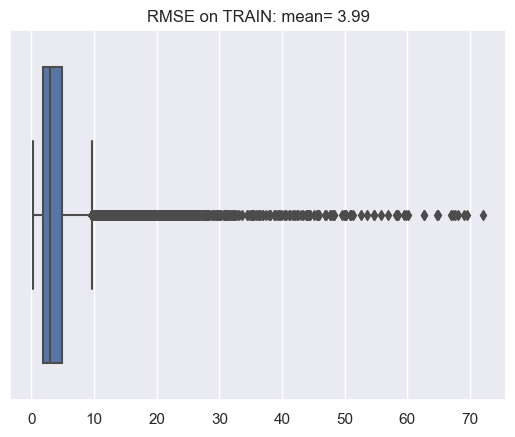

In [164]:

sns.boxplot(x=arr_mse_train)
fig = plt.gcf()
plt.title(f"RMSE on TRAIN: mean= {np.mean(arr_mse_train):.2f}")

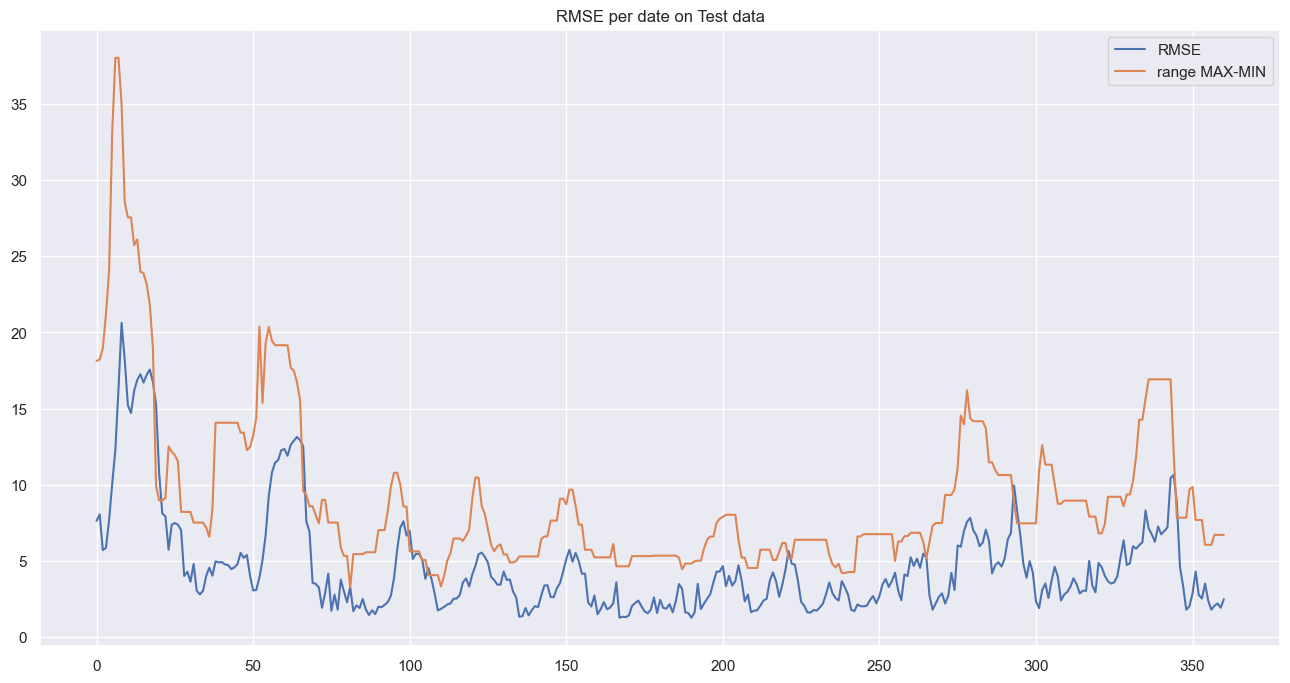

In [165]:
arr_mse = np.zeros((y_test_raw.shape[0]))
arr_range = np.zeros((y_test_raw.shape[0]))
for i_date in range(y_test_raw.shape[0]):
    arr_mse[i_date] = mean_squared_error(
        y_test_raw[i_date], 
        y_test_pred_raw[i_date],
        squared=False,
    )
    arr_range[i_date] = np.max(y_test_raw[i_date]) - np.min(y_test_raw[i_date])
fig = plt.figure(figsize=(16, 8))
plt.title("RMSE per date on Test data")
plt.plot(arr_mse, label="RMSE")
plt.plot(arr_range, label="range MAX-MIN")
plt.legend(loc='upper right')

In [166]:
np.mean(arr_range)

9.219501385041532

<Axes: ylabel='Probability'>

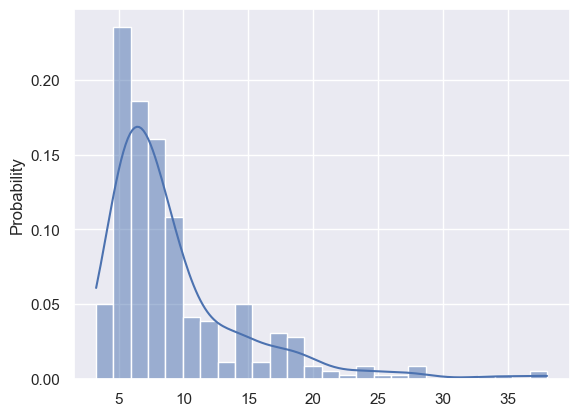

In [167]:
sns.histplot(x=arr_range,  stat="probability", kde=True)

In [168]:
np.mean(3*np.sqrt(np.var(y_test_raw, axis=1)))

8.136469372469229

<Axes: ylabel='Probability'>

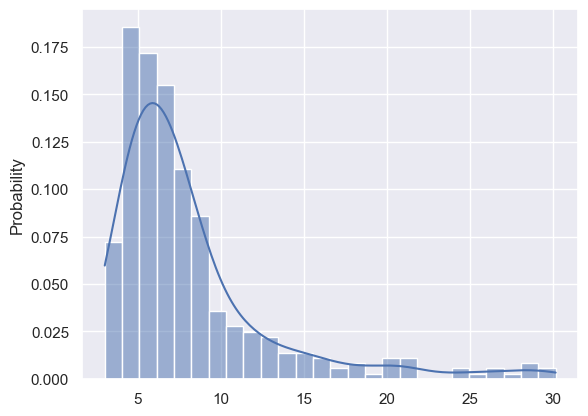

In [169]:
sns.histplot(x=3*np.sqrt(np.var(y_test_raw, axis=1)),  stat="probability", kde=True)

Text(0.5, 1.0, 'probability of RSME on each sequence')

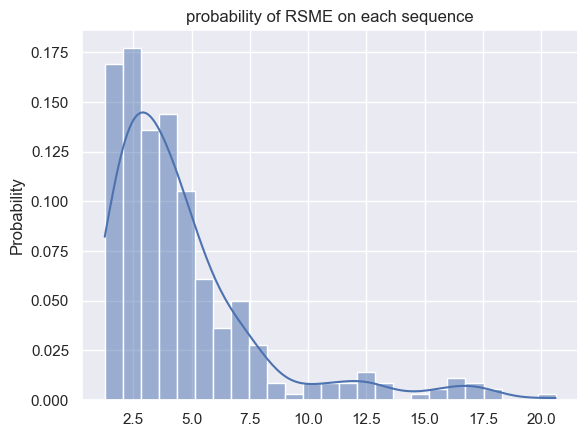

In [170]:
sns.histplot(x=arr_mse,  stat="probability", kde=True)
plt.title("probability of RSME on each sequence")

(0.0, 46.09750692520766)

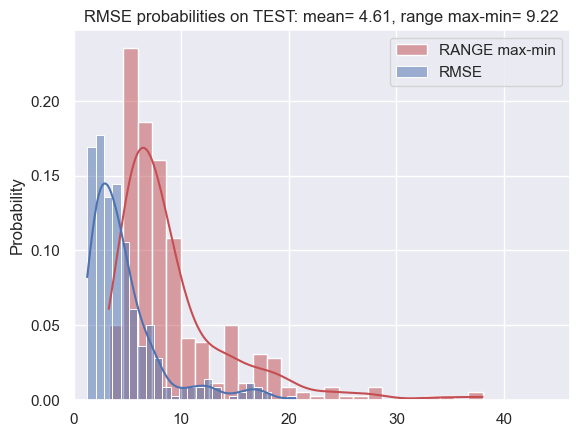

In [171]:
ax = sns.histplot(x=arr_range,  stat="probability", kde=True, label="RANGE max-min", color="r")
sns.histplot(x=arr_mse,  stat="probability", kde=True, label="RMSE", ax=ax)
plt.title(f"RMSE probabilities on TEST: mean= {np.mean(arr_mse):.2f}, range max-min= {np.mean(arr_range):.2f}")
plt.legend(loc='upper right')
ax.set_xlim([0,np.mean(arr_range)*5])

(0.0, 23.04809698420964)

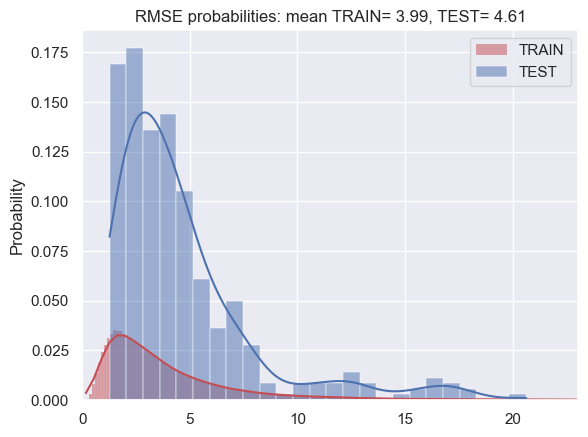

In [172]:
ax = sns.histplot(x=arr_mse_train,  stat="probability", kde=True, label="TRAIN", color="r")
sns.histplot(x=arr_mse,  stat="probability", kde=True, label="TEST", ax=ax)
plt.title(f"RMSE probabilities: mean TRAIN= {np.mean(arr_mse_train):.2f}, TEST= {np.mean(arr_mse):.2f}")
plt.legend(loc='upper right')
ax.set_xlim([0,np.mean(arr_mse)*5])

Text(0.5, 1.0, 'RMSE on TEST: mean= 4.61')

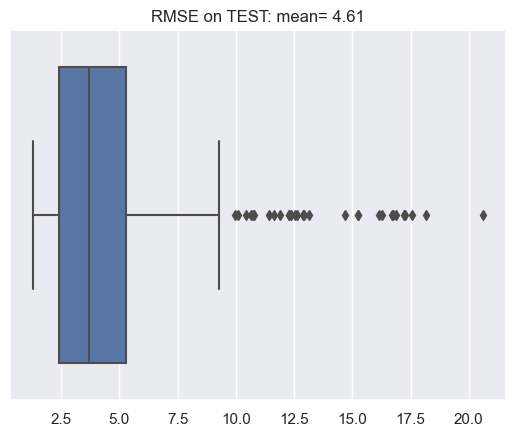

In [173]:
sns.boxplot(x=arr_mse)
fig = plt.gcf()
plt.title(f"RMSE on TEST: mean= {np.mean(arr_mse):.2f}")

In [174]:
print(y_test_raw[-3,:])
print(y_test_pred_raw[-3,:])

[1890.27 1890.25 1890.5  1889.9  1890.47 1894.38 1894.56 1891.09 1890.95
 1888.5  1891.29 1892.31 1893.78 1895.21 1892.57]
[1892.54174399 1892.84855513 1893.10641185 1893.37306683 1892.87833386
 1892.79847272 1892.39544471 1892.55776134 1892.0866032  1892.84133605
 1892.81967879 1893.07370037 1892.80591741 1893.36314058 1892.95593903]


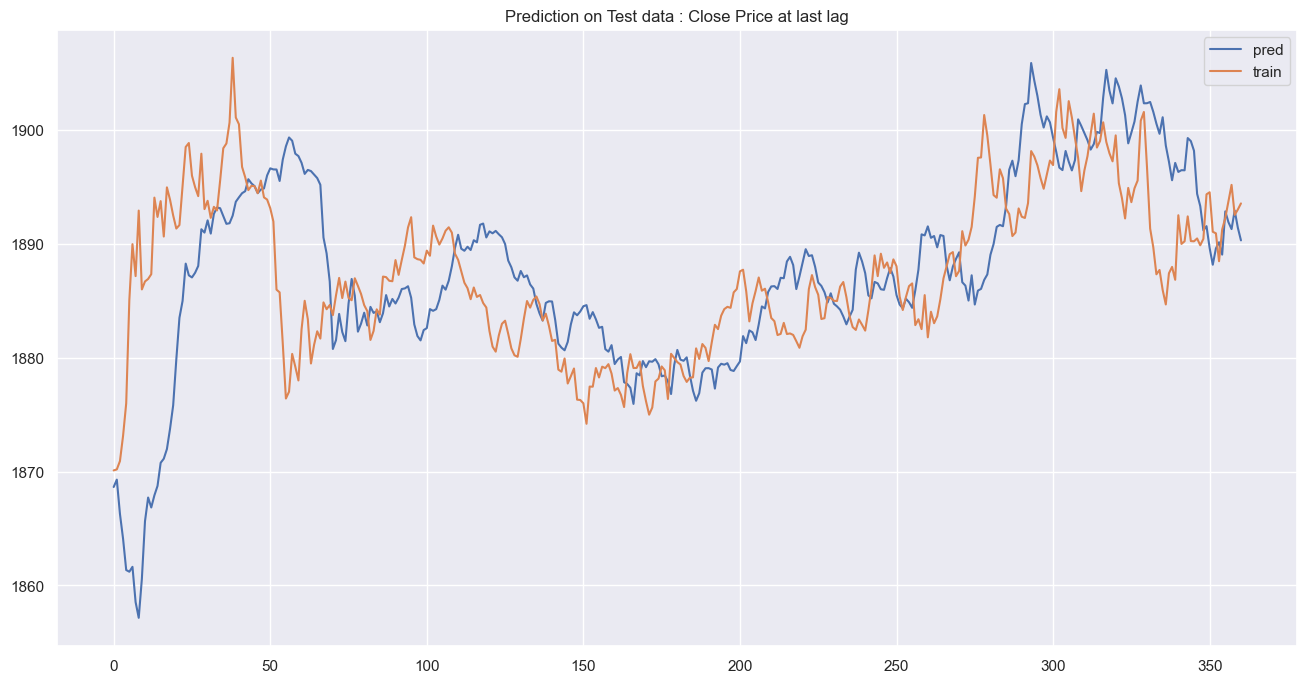

In [175]:
fig = plt.figure(figsize=(16, 8))
plt.title("Prediction on Test data : Close Price at last lag")
plt.plot(y_test_pred_raw[:1000,-1], label="pred")
plt.plot(y_test_raw[:1000, -1], label="train")
plt.legend(loc='upper right')

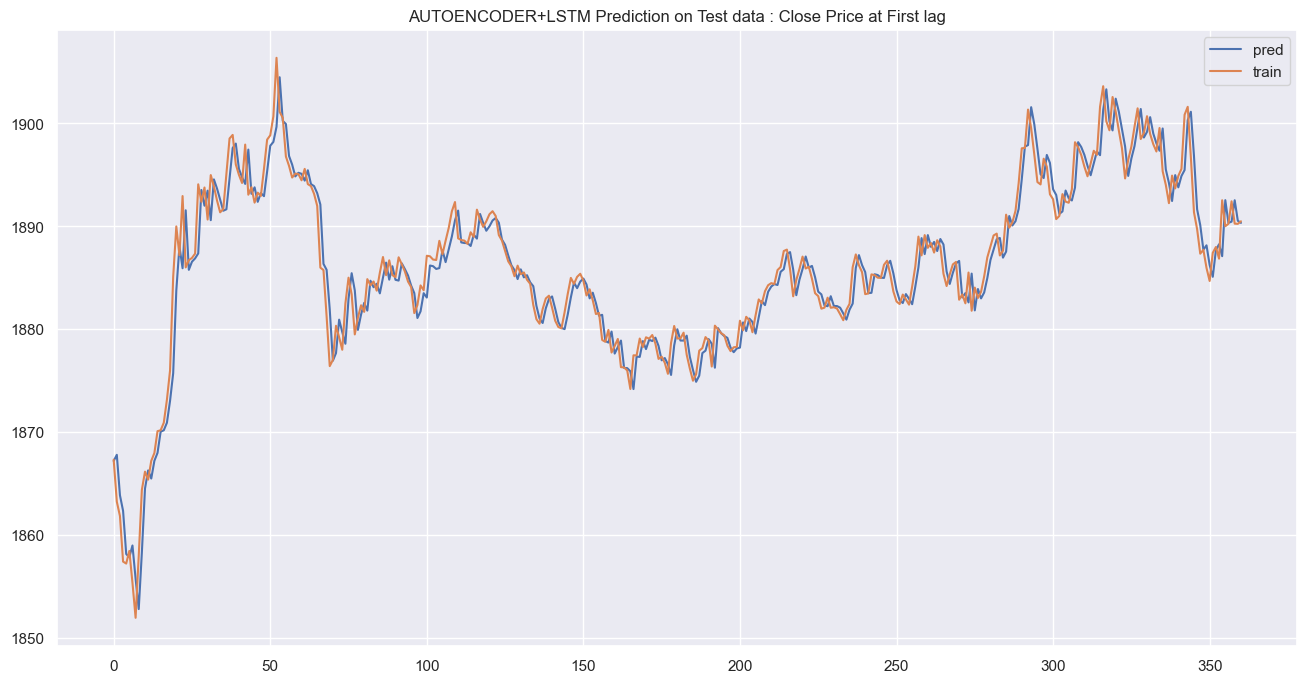

In [176]:
fig = plt.figure(figsize=(16, 8))
plt.title("AUTOENCODER+LSTM Prediction on Test data : Close Price at First lag")
plt.plot(y_test_pred_raw[:1000, 0], label="pred")
plt.plot(y_test_raw[:1000, 0], label="train")
plt.legend(loc='upper right')

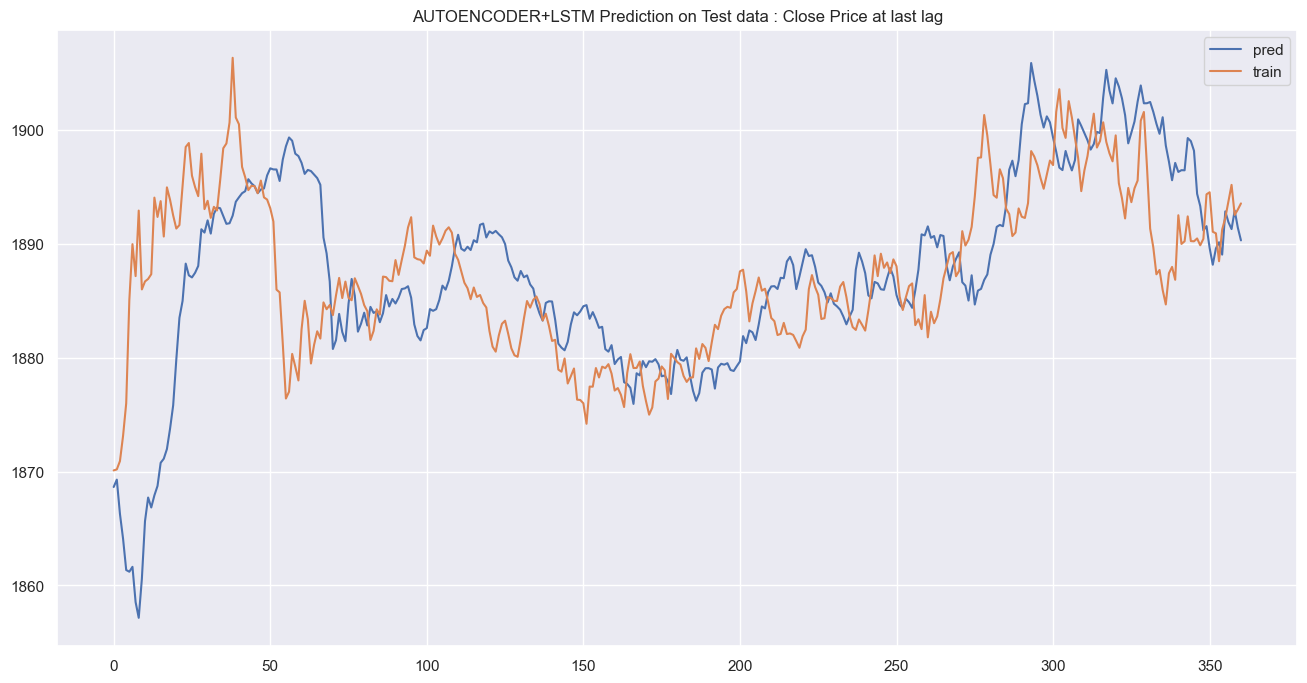

In [177]:

fig = plt.figure(figsize=(16, 8))
plt.title("AUTOENCODER+LSTM Prediction on Test data : Close Price at last lag")
plt.plot(y_test_pred_raw[:1000,-1], label="pred")
plt.plot(y_test_raw[:1000, -1], label="train")
plt.legend(loc='upper right')

## Compare

## Predict last prediction

In [178]:
X_test_sca.shape

(361, 72, 102)

In [179]:
df_feat["Close_ETH"].iloc[-1]

1889.59

In [180]:
df_feat["Close_ETH"].iloc[-1]

1889.59

In [181]:
len(list_i_enc_select)

32

In [182]:
# reload MDLS
#multi_step_model = tf.keras.models.load_model(path_mdl_predict_autoenc_lstm)
#encoder_model = tf.keras.models.load_model(path_mdl_encoder)
print("[batch, lags, features]")
X_last_raw = df_feat[list_col_select].iloc[-PAST_HISTORY:].values[np.newaxis,:]
X_last = X_last_raw.copy()
#list(np.array(list_col_select)[i_col_price_dep])/ df_feat["Close_ETH"].iloc[-1]
print("X_last[0,:,0]:")
print(X_last[0,:,0])
# Scale by ETH price
X_last[:,:,i_col_price_dep] = X_last[:,:,i_col_price_dep] / df_feat["Close_ETH"].iloc[-1]
assert X_last[0,-1,0] == 1, "Scaling by ETH price is not good!"
print("X_last[0,:,0] after divide by price:")
print(X_last[0,:,0])
print(X_last.shape)
# Standardize
X_last_sca = scaler.transform(X_last.reshape(-1,X_last.shape[-1])).reshape(X_last.shape)
print("X_last_sca[0,:,0]:")
print(X_last_sca[0,:,0])
print(X_last_sca.shape)
# Encode
X_last_encoded = encoder_model.predict(X_last_sca)
print("X_last_encoded[0,:,0]:")
print(X_last_encoded[0,:,0])
print(X_last_encoded.shape)
# Standardize encoded
X_last_encoded_sca = scaler_enc.transform(
    X_last_encoded.reshape(
        -1, 
        X_last_encoded.shape[-1]
    )
).reshape(X_last_encoded.shape)
print("X_last_encoded_sca[0,:,0]:")
print(X_last_encoded_sca[0,:,0])
print(X_last_encoded_sca.shape)
print("X_last_sca[0,0,0:4]:")
print(X_last_sca[0,0,0:4])
print("X_last_encoded_sca[0,0,:]:")
print(X_last_encoded_sca[0,0,:])
# Concatenate (auto selected encoded features)
X_last_ = np.concatenate([
        X_last_sca[:,:,0:4], 
        X_last_encoded_sca[:, :, np.array(list_i_enc_select)]
    ],
    axis=-1,
)
print("X_last_[0,0,:]:")
print(X_last_[0,0,:])
print(X_last_.shape)
# Predict
y_last_pred = multi_step_model.predict(X_last_)
print("y_last_pred (scaled):")
print(y_last_pred)
print(y_last_pred.shape)
# Unscale
#scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)
y_last_pred_unscaled = scaler_y.inverse_transform(y_last_pred.ravel().reshape(-1, 1)).reshape(y_last_pred.shape)
print("y_last_pred_unscaled:")
print(y_last_pred_unscaled)
print(y_last_pred_unscaled.shape)
# Multiply by price
y_last_pred_raw = y_last_pred_unscaled * df_feat["Close_ETH"].iloc[-1]
print("y_last_pred_raw:")
print(y_last_pred_raw)
print(y_last_pred_raw.shape)
nb_last_hour = 12
list_pred = list(y_last_pred_raw.squeeze()[-nb_last_hour:])
print("list_pred:")
print(list_pred)
print(len(list_pred))


[batch, lags, features]
X_last[0,:,0]:
[1892.41 1892.3  1893.61 1898.18 1897.7  1896.93 1895.81 1894.87 1896.12
 1897.35 1896.95 1901.62 1903.62 1900.22 1899.34 1902.57 1901.14 1899.32
 1897.59 1894.66 1896.48 1897.75 1899.67 1901.47 1898.49 1899.07 1900.71
 1898.98 1897.99 1897.28 1899.56 1895.36 1894.04 1892.26 1894.94 1893.69
 1894.91 1895.59 1900.85 1901.62 1896.73 1891.37 1889.73 1887.35 1887.73
 1885.97 1884.7  1887.44 1888.   1886.87 1892.54 1890.02 1890.25 1892.44
 1890.27 1890.25 1890.5  1889.9  1890.47 1894.38 1894.56 1891.09 1890.95
 1888.5  1891.29 1892.31 1893.78 1895.21 1892.57 1893.04 1893.58 1889.59]
X_last[0,:,0] after divide by price:
[1.00149239 1.00143417 1.00212745 1.00454596 1.00429194 1.00388444
 1.00329172 1.00279426 1.00345578 1.00410671 1.00389502 1.00636646
 1.00742489 1.00562556 1.00515985 1.00686922 1.00611244 1.00514927
 1.00423372 1.00268312 1.00364629 1.0043184  1.00533449 1.00628708
 1.00471002 1.00501696 1.00588487 1.00496933 1.00444541 1.00406967
 1.0

In [183]:
X_last_encoded_sca.shape

(1, 72, 32)

In [184]:
list_i_enc_select

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31]

In [185]:
X_last_encoded_sca[:,:, np.array(list_i_enc_select)].shape

(1, 72, 32)

In [186]:
X_last_sca[:,:,0:4].shape

(1, 72, 4)

In [187]:
X_train_.shape

(89319, 72, 36)

In [188]:
df_feat

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
89849  1699485900000   1893.78   1895.48  1893.78    1895.21    631.7886   
89850  1699486200000   1895.21   1895.64  1892.22    1892.57    764.3963   
89851  1699486500000   1892.56   1893.85  1892.03    1893.04    536.4546   
89852  1699486800000   1893.03   1894.33  1892.22    1893.58    879.8833   
89853  1699487100000   1893.57   1898.49  1888.27    1889.59   4428.4056   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1730.155069       1729.729634   
1      2023-01-01 00:05:00       1730.155069       1729.729634   
2      2023-01-01 00:10:00       1730.155069       1729.729634   
3      2023-01-01 00:15:00       1730.155069       1729.729634   
4      2023-01-01 00:20:00       1730.155069       1729.729634   
...                    ...               ...               ...   
89849  2023-11-08 23:25:00       1897.370000       1897.275000   
89850  2023-11-08 23:30:00       1896.025000       1896.075000   
89851  2023-11-08 23:35:00       1894.935000       1894.985000   
89852  2023-11-08 23:40:00       1894.015000       1894.065000   
89853  2023-11-08 23:45:00       1894.015000       1894.065000   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
0            1194.710  ...         0.0            0.0           0.0   
1            1194.710  ...         0.0            0.0           0.0   
2            1194.710  ...         0.0            0.0           0.0   
3            1194.710  ...         0.0            0.0           0.0   
4            1194.710  ...         0.0            0.0           0.0   
...               ...  ...         ...            ...           ...   
89849        1889.565  ...         NaN            NaN           NaN   
89850        1889.565  ...         NaN            NaN           NaN   
89851        1889.565  ...         NaN            NaN           NaN   
89852        1889.565  ...         NaN            NaN           NaN   
89853        1890.750  ...         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
89849               NaN         0.0               NaN         0.0      0.0   
89850               NaN         0.0               NaN         0.0      0.0   
89851               NaN         0.0               NaN         0.0      0.0   
89852               NaN         0.0               NaN         0.0      0.0   
89853               NaN         0.0               NaN         0.0      0.0   

                      date  train  
0      2023-01-02 05:00:00   True  
1      2023-01-02 05:00:00   True  
2      2023-01-02 05:00:00   True  
3      2023-01-02 05:00:00   True  
4      2023-01-02 05:00:00   True  
...                    ...    ...  
89849                  NaN  False  
89850                  NaN  False  
89851                  NaN  False  
89852                  NaN  False  
89853                  NaN  False  

[89854 rows x 136 columns]

In [189]:
mode_lstm_simple = False
if mode_lstm_simple:
    # TODO : finish pred
    X_last_raw = df_feat[list_col_select].iloc[-PAST_HISTORY:].values[np.newaxis,:]
    # divided price
    X_last = X_last_raw / df_feat["Close_ETH"].iloc[-1]
    # scaler
    X_last_sca = scaler.transform(X_last.reshape(-1,X_last.shape[-1])).reshape(X_last.shape)
    y_last_pred = multi_step_model_1.predict(X_last_sca)
    y_last_pred_unscaled = scaler_y.inverse_transform(y_last_pred.reshape(-1,y_last_pred.shape[-1])).reshape(y_last_pred.shape)
    y_last_pred_raw = y_last_pred_unscaled * df_feat["Close_ETH"].iloc[-1]
    print(y_last_pred_raw)
    nb_last_pred = 12
    list_pred = list(y_last_pred_raw.squeeze()[-nb_last_pred:])
    print(list_pred)

In [190]:
y_last_pred_unscaled

array([[0.9997898 , 1.000296  , 1.0004479 , 1.0006015 , 1.0002664 ,
        0.99996954, 0.99971116, 0.9997837 , 0.9995952 , 0.9999042 ,
        0.99981153, 0.99967045, 0.99963063, 0.99985844, 0.99994415]],
      dtype=float32)

In [191]:
df_feat["Close_ETH"].iloc[-1]

1889.59

In [192]:
y_last_pred_raw

array([[1889.1927, 1890.1493, 1890.4363, 1890.7266, 1890.0934, 1889.5325,
        1889.0442, 1889.1813, 1888.8251, 1889.4089, 1889.2339, 1888.9673,
        1888.892 , 1889.3225, 1889.4844]], dtype=float32)

In [193]:
y_last_pred_raw.shape

(1, 15)

## Save last prediction

In [194]:
list_pred

[1890.7266,
 1890.0934,
 1889.5325,
 1889.0442,
 1889.1813,
 1888.8251,
 1889.4089,
 1889.2339,
 1888.9673,
 1888.892,
 1889.3225,
 1889.4844]

In [195]:
save_list(list_pred, path_save_pred_vals)

In [196]:
list_pred_reload = load_list(path_save_pred_vals)
from numpy.testing import assert_almost_equal
assert_almost_equal(list_pred_reload,list_pred, decimal=3)
#"Reload prediction list not good!"

In [197]:
list_pred_reload

[1890.7266,
 1890.0934,
 1889.5325,
 1889.0442,
 1889.1813,
 1888.8251,
 1889.4089,
 1889.2339,
 1888.9673,
 1888.892,
 1889.3225,
 1889.4844]